# Road Infrastructure Climate Risk Assessment Framework
## RICRAF Climate Risk Framework Application
---

## Overview

This notebook computes Climate Risk Scores and categorises each road link into Climate Risk Level as described in the article **Climate Risk Assessment of Road Infrastructure under Multi-Stressor Conditions in Victoria, Australia**. It:

- Applies the multi-stressor framework to quantify hazard, exposure, and vulnerability at road link scale across 23,117 km of Victoria's road network.
- Generates Climate Risk Scores (CRiskS) under current climate conditions and future warming levels up to 3.0°C.
- Produces confusion matrices and statistical evaluations for validation.
- Creates static maps (PNG) and interactive HTML maps (Kepler.gl) for visualisation.

### Key Features

- **Input**:
  - Fused dataset from data fusion stage (`gdf_road_clim_cln_final_withfuture.geojson`)
  → [Zenodo DOI: 10.5281/zenodo.17379391](https://doi.org/10.5281/zenodo.17379391)

- **Output**:
  - Processed CRiskS GeoJSON
  - Climate Risk Level
  - Static maps (PNG)
  - Interactive HTML map (`Kepler.gl`)

- **Reproducibility**: All paths relative, seeds set, dependencies pinned. All steps are scripted with modular functions from `src/`.

- **Transferability**: Modular for other regions (change CRS, predictors).

- **Dependencies**: Listed in `requirements.txt` (e.g. geopandas==1.0.1).


### Usage Instructions
1. Install dependencies: `pip install -r requirements.txt`.
2. Run cells sequentially.
3. Outputs are saved to `data/interim/` and `data/processed/`.

For full documentation, see the [RICRAF Application Paper](https://doi.org/TBD) (submitted to *Transportation Research Part D: Transport and Environment*).


**Notes:**
- This notebook assumes some datasets prepared from `ricraf_development.ipynb` are available in `data/processed/model_dev`.
- All spatial operations use EPSG:3111 (GDA94 / Vicgrid) for Victoria, Australia. Adapt CRS for other regions.
- This notebook emphasises reproducibility: Use virtual environments and document all steps.
- For large datasets, ensure sufficient memory (e.g. 16GB+ RAM).
- Final model uses **7,419 links** (after filtering + ML prep).
- Future GWLs (1.5°C, 2.0°C, 3.0°C) included for scalability
- Citation: If using this code or data, cite the associated papers and this repository (DOI via Zenodo).


**Dependencies:**
- Python 3.12+
- geopandas==1.0.1
- pandas==2.2.3
- numpy==2.1.3
- shapely==2.0.6
- contextily==1.6.2
- loguru==0.7.3
- libpysal==4.13.0
- esda==2.7.0
- statsmodels==0.14.4
- matplotlib-scalebar==0.9.0

Install via `requirements.txt` or uncomment the installation cells below.


In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import r2_score, cohen_kappa_score
from scipy.stats import chi2_contingency, spearmanr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from loguru import logger

# Setup logging
logger.add("../logs/ricraf_application.log", rotation="500 MB")
logger.info("Starting RICRAF Application Notebook")

# Compute Climate Risk Scores for Different Scenarios

In [27]:
# COMPUTE CLIMATE RISK AND ASSIGN RISK LEVELS - 5H x 5E x 5V & 5L x 5C - 4 Categories
# "gdf_road_clim_cln_final_cra_calc.geojson" is generated in "ricraf_development.ipynb"
# Ensure "..\data\processed\model_app\climate_risk_matrix_input_5h5e5v_4cat.csv" is available

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime
from loguru import logger

# ------------------------------------------------------------
#  Prep: Compute normalisation factors for the three CR components
# ------------------------------------------------------------
import os
import geopandas as gpd
import pandas as pd

run_id_dev = "model_dev"
outputs_id_dev = "out_crisks"
scenario_id_dev = "current"
output_dir_dev = f"../data/processed/{run_id_dev}/{outputs_id_dev}"
data_path = os.path.join(output_dir_dev, f"climate_risk_scores_gwl-{scenario_id_dev}_{run_id_dev}.csv")
gdf = gpd.read_file(data_path)

# Define and remove outlier
outlier_condition = (gdf['road_link_id'] == "5093_1")
gdf_filtered = gdf[~outlier_condition].copy()

# Ensure the three columns are numeric
cols = ["Hazard_sum-current", "Exposure_sum-current", "Vulnerability_sum-current"]
gdf_filtered[cols] = gdf_filtered[cols].astype(float)

# Compute maxima (after outlier removal)
max_hazard = gdf_filtered["Hazard_sum-current"].max()
max_exposure = gdf_filtered["Exposure_sum-current"].max()
max_vulnerability = gdf_filtered["Vulnerability_sum-current"].max()

# Normalisation factors = 1 / max_value
hazard_norm_fac = 1.0 / max_hazard
exposure_norm_fac = 1.0 / max_exposure
vulnerability_norm_fac = 1.0 / max_vulnerability

print("# CR Component Normalisation Factors")
print(f"hazard_norm_fac = {hazard_norm_fac}")
print(f"exposure_norm_fac = {exposure_norm_fac}")
print(f"vulnerability_norm_fac = {vulnerability_norm_fac}")

# # (Optional) Show the max values that were used
# print("\n# Underlying maxima (after outlier removal)")
# print(f"max Hazard_sum-current = {max_hazard}")
# print(f"max Exposure_sum-current = {max_exposure}")
# print(f"max Vulnerability_sum-current = {max_vulnerability}")
# ------------------------------------------------------------


# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
os.makedirs(output_dir, exist_ok=True)
path_cra_calc = os.path.join(output_dir, f"../../{run_id_dev}/gdf_road_clim_cln_final_cra_calc.geojson")  #from `model_dev`
path_shap_weights = os.path.join(output_dir, f"../../{run_id_dev}/shap_weights_{run_id_dev}.json")  #from `model_dev`
path_norm_params = os.path.join(output_dir, f"../../{run_id_dev}/normalization_params_{run_id_dev}.json")  #from `model_dev`
validate_performance = True  # For "current" scenario only
scenario_id = "current"  # Update scenario ["current", "1.5", "2.0", "3.0"]
# validate_performance = False
# scenario_id = "3.0"

matrix_path = f"../data/processed/{run_id}/climate_risk_matrix_input_5h5e5v_4cat.csv"

# Load CRA_Calc Dataset (prepared during model_dev)
gdf = gpd.read_file(path_cra_calc)

# Load Pre-Processed Dataset for ML to get distress codes)
path_preproc = os.path.join(output_dir, f"../../model_dev/gdf_road_clim_cln_final_model_dev.geojson")  #from `model_dev`
logger.info(f"Loading distress data from {path_preproc}")
gdf_distress = gpd.read_file(path_preproc)
logger.info(f"Loaded distress dataset with {len(gdf_distress)} segments")
logger.info(f"Distress dataset columns: {list(gdf_distress.columns)}")

# Validate input data
distress_cols = ["road_link_id", "Roughness_Code", "Rutting_Code", "Cracking_Code"]
missing_distress_cols = [col for col in distress_cols if col not in gdf_distress.columns]
if missing_distress_cols:
    raise ValueError(f"Missing distress columns: {missing_distress_cols}")

# Check for geometry column in gdf_cra
geometry_col = gdf.geometry.name if gdf.geometry is not None else None
if geometry_col is None:
    raise ValueError(f"No geometry column found in CRA dataset. Available columns: {list(gdf.columns)}")
logger.info(f"Using geometry column from CRA dataset: {geometry_col}")

# SHAP weights configuration
SHAP_WEIGHTS = {
    "Hazard": ["Thermal_Diff-current", "tx40_gwl-current", "spi3_gwl-current", "tn02_gwl-current", "rx5d_gwl-current"],
    "Exposure": ["ALLVEHS_AA", "HATI_Categ_Code", "TRUCKS_AAD"],
    "Vulnerability": ["SEAL_WIDTH", "Surface_Ty_Code", "RMA_CLSFCN_Code", "Texture__L_Code"]
}

# Risk level mapping functions
def map_distress_cat(score):
    if score < 0.25:
        return "Category 1"
    elif score <= 0.50:
        return "Category 2"
    elif score <= 0.75:
        return "Category 3"
    else:
        return "Category 4"

def map_crs_level(score):
    if score < 0.05:
        return "Category 1"
    elif score <= 0.10:
        return "Category 2"
    elif score <= 0.15:
        return "Category 3"
    else:
        return "Category 4"

def map_hazard_exposure_level_norm(score):
    if score < 0.2:
        return "Very Unlikely"
    elif score <= 0.4:
        return "Unlikely"
    elif score <= 0.6:
        return "Possible"
    elif score <= 0.8:
        return "Likely"
    else:
        return "Almost Certain"

def map_vulnerability_level_norm(score):
    if score < 0.2:
        return "Insignificant"
    elif score <= 0.4:
        return "Minor"
    elif score <= 0.6:
        return "Moderate"
    elif score <= 0.8:
        return "Major"
    else:
        return "Catastrophic"

def map_likelihood_norm(score):
    if score < 0.04:
        return "Very Unlikely"
    elif score <= 0.16:
        return "Unlikely"
    elif score <= 0.36:
        return "Possible"
    elif score <= 0.64:
        return "Likely"
    else:
        return "Almost Certain"

def map_consequence_norm(score):
    if score < 0.2:
        return "Insignificant"
    elif score <= 0.4:
        return "Minor"
    elif score <= 0.6:
        return "Moderate"
    elif score <= 0.8:
        return "Major"
    else:
        return "Catastrophic"

print(f"[{datetime.now()}] ---- CRAF Compute Climate Risk Scores (gwl-{scenario_id}) ----")

# Load data
print(f"[{datetime.now()}] Loading data...")
gdf = gpd.read_file(path_cra_calc)
with open(path_shap_weights, "r") as f:
    shap_weights = json.load(f)["Mean_Abs_SHAP"]
with open(path_norm_params, "r") as f:
    normalization_params = json.load(f)

# Validate input data
print(f"[{datetime.now()}] Validating input data...")
required_cols = ["road_link_id"] + [f.replace("current", scenario_id) for f in
                                    [item for sublist in SHAP_WEIGHTS.values() for item in sublist]]
missing_cols = [col for col in required_cols if col not in gdf.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Initialise DataFrame with additional columns
df = gdf[required_cols].copy()
base_features = [item for sublist in SHAP_WEIGHTS.values() for item in sublist]
for feature in base_features:
    base_name = feature
    scenario_name = feature.replace("current", scenario_id)
    df[f"{base_name}_shap"] = shap_weights.get(base_name, 0)
    df[f"{base_name}_min"] = normalization_params[base_name]["min"]
    df[f"{base_name}_max"] = normalization_params[base_name]["max"]
    df[scenario_name] = df[scenario_name]

# Normalise features and compute contributions
print(f"[{datetime.now()}] Normalising features for CRA...")
for comp, features in SHAP_WEIGHTS.items():
    for feature in features:
        base_name = feature
        scenario_name = feature.replace("current", scenario_id)
        df[f"{base_name}_norm"] = (df[scenario_name] - df[f"{base_name}_min"]) / (
                df[f"{base_name}_max"] - df[f"{base_name}_min"])
        df[f"{base_name}_contrib"] = df[f"{base_name}_shap"] * df[f"{base_name}_norm"]
    shap_sum = df[[f"{f}_shap" for f in features]].sum(axis=1).iloc[0]
    df[f"{comp}_sum-{scenario_id}"] = df[[f"{f}_contrib" for f in features]].sum(axis=1)


# Normalisation for component sums
df[f"Hazard_sum_norm-{scenario_id}"] = df[f"Hazard_sum-{scenario_id}"] * hazard_norm_fac
df[f"Exposure_sum_norm-{scenario_id}"] = df[f"Exposure_sum-{scenario_id}"] * exposure_norm_fac
df[f"Vulnerability_sum_norm-{scenario_id}"] = df[f"Vulnerability_sum-{scenario_id}"] * vulnerability_norm_fac

# Compute CRS
print(f"[{datetime.now()}] Computing Climate Risk Scores...")
df[f"CRS-{scenario_id}"] = df[f"Hazard_sum-{scenario_id}"] * df[f"Exposure_sum-{scenario_id}"] * df[
    f"Vulnerability_sum-{scenario_id}"]
df[f"CRS_Level-{scenario_id}"] = df[f"CRS-{scenario_id}"].apply(map_crs_level)

# Map to component risk levels
print(f"[{datetime.now()}] Mapping component scores to risk levels...")

df[f"Hazard_sum_norm_Level-{scenario_id}"] = df[f"Hazard_sum_norm-{scenario_id}"].apply(map_hazard_exposure_level_norm)
df[f"Exposure_sum_norm_Level-{scenario_id}"] = df[f"Exposure_sum_norm-{scenario_id}"].apply(
    map_hazard_exposure_level_norm)
df[f"Vulnerability_sum_norm_Level-{scenario_id}"] = df[f"Vulnerability_sum_norm-{scenario_id}"].apply(
    map_vulnerability_level_norm)

# Compute & Map Likelihood and Consequence
df[f"Likelihood_norm-{scenario_id}"] = df[f"Hazard_sum_norm-{scenario_id}"] * df[f"Exposure_sum_norm-{scenario_id}"]
df[f"Consequence_norm-{scenario_id}"] = df[f"Vulnerability_sum_norm-{scenario_id}"]

df[f"Likelihood_norm Level-{scenario_id}"] = df[f"Likelihood_norm-{scenario_id}"].apply(map_likelihood_norm)
df[f"Consequence_norm Level-{scenario_id}"] = df[f"Consequence_norm-{scenario_id}"].apply(map_consequence_norm)

# Load climate risk matrix (Components)
matrix_df = pd.read_csv(matrix_path)
risk_matrix = {(row["Hazard_Level"], row["Exposure_Level"], row["Vulnerability_Level"]): row["Climate_Risk_Level"]
               for _, row in matrix_df.iterrows()}


def map_climate_risk_from_matrix_norm(row):
    hazard_norm = row[f"Hazard_sum_norm_Level-{scenario_id}"]
    exposure_norm = row[f"Exposure_sum_norm_Level-{scenario_id}"]
    vulnerability_norm = row[f"Vulnerability_sum_norm_Level-{scenario_id}"]
    return risk_matrix.get((hazard_norm, exposure_norm, vulnerability_norm), "Unknown")
df[f"CR_Level_comp_norm-{scenario_id}"] = df.apply(map_climate_risk_from_matrix_norm, axis=1)

# Validation (conditional execution)
if validate_performance:
    print(f"[{datetime.now()}] Performing validation...")
    # Resolve duplicates in distress data by averaging
    df_distress = gdf_distress[distress_cols].groupby("road_link_id").mean().reset_index()
    df = df.merge(df_distress, on="road_link_id", how="inner")

    # Load original dataset with outliers filtering prepared in model_dev to get raw distress data
    path_filtered_output = os.path.join(output_dir, f"../../model_dev/gdf_road_clim_cln_final_withfuture_filtered.geojson")
    gdf_final = gpd.read_file(path_filtered_output)
    distress_cols_o = ['Roughness_', 'Rutting_Ca', 'Cracking_C', 'road_link_id']
    df = df.merge(gdf_final[distress_cols_o], on="road_link_id", how="inner")

    # Compute Distress_Score
    df[["Norm_Roughness", "Norm_Rutting", "Norm_Cracking"]] = (df[distress_cols[1:]] - df[distress_cols[1:]].min()) / (
            df[distress_cols[1:]].max() - df[distress_cols[1:]].min())
    weights = [0.20, 0.40, 0.40]  # Cracking, Roughness, Rutting accuracies
    df["Distress_Score"] = (weights[0] * df["Norm_Cracking"] +
                            weights[1] * df["Norm_Roughness"] +
                            weights[2] * df["Norm_Rutting"]
                            ) / sum(weights)
    # df["Distress_Score"] = (df["Norm_Cracking"] + df["Norm_Roughness"] + df["Norm_Rutting"]) / 3
    df["Distress_Score_Level"] = df["Distress_Score"].apply(map_distress_cat)


    # Create "Distress_Score_max" column
    df["Distress_Score_max"] = df[["Norm_Roughness", "Norm_Rutting", "Norm_Cracking"]].max(axis=1, skipna=True)
    df["Distress_Score_max_Level"] = df["Distress_Score_max"].apply(map_distress_cat)

    # Create "Ro-Ru-Cr" column
    df["Ro-Ru-Cr"] = df["Roughness_"].fillna('').str[0] + "-" + \
                     df["Rutting_Ca"].fillna('').str[0] + "-" + \
                     df["Cracking_C"].fillna('').str[0]

    # Statistical validation
    validation_metrics = {}
    for col in [f"CRS-{scenario_id}",
                f"Hazard_sum-{scenario_id}",
                f"Exposure_sum-{scenario_id}",
                f"Vulnerability_sum-{scenario_id}",
                f"Hazard_sum_norm-{scenario_id}",
                f"Exposure_sum_norm-{scenario_id}",
                f"Vulnerability_sum_norm-{scenario_id}"
                ]:
        corr, p_value = spearmanr(df["Distress_Score"], df[col])
        X = df[[col]].values
        y = df["Distress_Score"].values
        lin_reg = LinearRegression().fit(X, y)
        y_pred = lin_reg.predict(X)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mask = y == 0
        eps = 1e-10
        mape = np.mean(np.abs((y - y_pred) / (np.where(mask, np.nan, y) + eps)) * 100)
        # mape = np.mean(np.abs((y - y_pred) / np.where(mask, np.nan, y)) * 100)
        validation_metrics[col] = {"Spearman_corr": corr, "R2": r2, "RMSE": rmse, "MAPE": mape}
        print(f"[{datetime.now()}] Validation for {col}: "
              f"Spearman={corr:.3f} "
              f"R2={r2:.3f}, RMSE={rmse:.3f}, MAPE={mape:.3f}%")

# Prepare output DataFrame
output_cols = ["road_link_id"]
output_cols.extend([f for f in required_cols if f != "road_link_id" and f != "link_length_km"])
for feature in base_features:
    output_cols.extend([f"{feature}_shap", f"{feature}_min", f"{feature}_max", f"{feature}_norm", f"{feature}_contrib"])
for comp in SHAP_WEIGHTS.keys():
    output_cols.extend([f"{comp}_sum-{scenario_id}",
                        # f"{comp}_sum_Level-{scenario_id}",
                        f"{comp}_sum_norm-{scenario_id}",
                        f"{comp}_sum_norm_Level-{scenario_id}",
                        ])
output_cols.extend([f"CRS-{scenario_id}",
                    f"CRS_Level-{scenario_id}",
                    # f"CR_Level_comp-{scenario_id}",
                    f"CR_Level_comp_norm-{scenario_id}",
                    f"Likelihood_norm-{scenario_id}",
                    f"Likelihood_norm Level-{scenario_id}",
                    f"Consequence_norm-{scenario_id}",
                    f"Consequence_norm Level-{scenario_id}",
                    ])

if validate_performance:
    output_cols.extend(["Distress_Score", "Distress_Score_Level",
                        "Norm_Roughness", "Norm_Rutting", "Norm_Cracking",
                        'Roughness_', 'Rutting_Ca', 'Cracking_C',
                        "Distress_Score_max", "Distress_Score_max_Level", "Ro-Ru-Cr"
                        ])
climate_scores = df[output_cols].copy()


# Save normalisation details
norm_details = {comp: {f: normalization_params[f] for f in features if f in normalization_params} for comp, features in SHAP_WEIGHTS.items()}
with open(os.path.join(output_dir, f"norm_details_gwl-{scenario_id}_{run_id}.json"), "w") as f:
    json.dump(norm_details, f)

# Save outputs
output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")
climate_scores.to_csv(output_path, index=False)
print(f"[{datetime.now()}] Saved climate risk scores to {output_path}")

print(f"[{datetime.now()}] Climate risk score computation completed for gwl-{scenario_id} scenario.")


# CR Component Normalisation Factors
hazard_norm_fac = 1.8898162325093297
exposure_norm_fac = 1.1837572312939364
vulnerability_norm_fac = 1.3376986238442914


2025-11-02 01:51:56.416 | INFO     | __main__:<module>:81 - Loading distress data from ../data/processed/model_app/out_cra\../../model_dev/gdf_road_clim_cln_final_model_dev.geojson
2025-11-02 01:51:57.414 | INFO     | __main__:<module>:83 - Loaded distress dataset with 7419 segments
2025-11-02 01:51:57.415 | INFO     | __main__:<module>:84 - Distress dataset columns: ['ALLVEHS_AA', 'TRUCKS_AAD', 'SEAL_WIDTH', 'HATI_Categ_Code', 'Surface_Ty_Code', 'Texture__L_Code', 'RMA_CLSFCN_Code', 'Thermal_Diff-current', 'tx40_gwl-current', 'tn02_gwl-current', 'rx5d_gwl-current', 'spi3_gwl-current', 'Roughness_Code', 'Rutting_Code', 'Cracking_Code', 'road_link_id', 'link_length', 'geometry']
2025-11-02 01:51:57.415 | INFO     | __main__:<module>:96 - Using geometry column from CRA dataset: geometry


[2025-11-02 01:51:57.416546] ---- CRAF Compute Climate Risk Scores (gwl-current) ----
[2025-11-02 01:51:57.416546] Loading data...
[2025-11-02 01:51:58.492473] Validating input data...
[2025-11-02 01:51:58.510379] Normalising features for CRA...
[2025-11-02 01:51:58.522413] Computing Climate Risk Scores...
[2025-11-02 01:51:58.524158] Mapping component scores to risk levels...
[2025-11-02 01:51:58.568751] Performing validation...
[2025-11-02 01:51:59.881406] Validation for CRS-current: Spearman=0.467 R2=0.280, RMSE=0.162, MAPE=nan%
[2025-11-02 01:51:59.881406] Validation for Hazard_sum-current: Spearman=-0.073 R2=0.005, RMSE=0.190, MAPE=nan%
[2025-11-02 01:51:59.890624] Validation for Exposure_sum-current: Spearman=0.438 R2=0.322, RMSE=0.157, MAPE=nan%
[2025-11-02 01:51:59.890624] Validation for Vulnerability_sum-current: Spearman=0.256 R2=0.058, RMSE=0.185, MAPE=nan%
[2025-11-02 01:51:59.892629] Validation for Hazard_sum_norm-current: Spearman=-0.073 R2=0.005, RMSE=0.190, MAPE=nan%
[2

## Generate Confusion Matrices (Current Scenario Only) - including 5 Likelihood & 5 Consequence with 4 Categories

In [14]:
# GENERATE CONFUSION MATRICES - 5 Likelihood & 5 Consequence (Four Categories)
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from datetime import datetime
import os
from sklearn.metrics import r2_score, cohen_kappa_score
from scipy.stats import chi2_contingency, spearmanr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
scenario_id = "current"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")

# Define categories (4 levels)
distress_categories = ["Category 1", "Category 2", "Category 3", "Category 4"]

# Load geospatial data
print(f"[{datetime.now()}] Loading geospatial data from {data_path}...")
try:
    gdf = gpd.read_file(data_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Geospatial data not found at {data_path}")

# Convert relevant columns to numeric, coercing errors to NaN
numeric_columns = ['Distress_Score', f'CRS-{scenario_id}']
for col in numeric_columns:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')


# Map Climate Risk Level to equivalent categories
climate_risk_map = {'Low': 'Category 1', 'Medium': 'Category 2', 'High': 'Category 3', 'Extreme': 'Category 4'}
# gdf[f'Cat_CR_comp-{scenario_id}'] = gdf[f'CR_Level_comp-{scenario_id}'].map(climate_risk_map)
gdf[f'Cat_CR_comp_norm-{scenario_id}'] = gdf[f'CR_Level_comp_norm-{scenario_id}'].map(climate_risk_map)
# gdf[f'Cat_CR_lc_norm-{scenario_id}'] = gdf[f'CR_Level_lc_norm-{scenario_id}'].map(climate_risk_map)


# Filter for 4 distress categories
category_columns = ['Distress_Score_Level',
                    f'CRS_Level-{scenario_id}',
                    # f'Cat_CR_comp-{scenario_id}',
                    f'Cat_CR_comp_norm-{scenario_id}',
                    # f'Cat_CR_lc_norm-{scenario_id}'
                    ]
for col in category_columns:
    gdf = gdf[gdf[col].isin(distress_categories)]

# Drop rows with NaN values in key columns
gdf = gdf.dropna(subset=numeric_columns + category_columns)

# Validate data
if gdf.empty:
    raise ValueError("No data remains after filtering for 4 distress categories.")

# Step 1: Print category counts
print(f"[{datetime.now()}] Category Counts:")
for col in category_columns:
    print(f"\nCounts for {col}:")
    counts = gdf[col].value_counts().reindex(distress_categories, fill_value=0)
    for category, count in counts.items():
        print(f"{category}: {count}")
    total = counts.sum()
    print(f"Total: {total}")

# Step 2: Compare categories
print(f"[{datetime.now()}] Comparing categories...")
categories = [f'CRS_Level-{scenario_id}',
              # f'Cat_CR_comp-{scenario_id}',
              f'Cat_CR_comp_norm-{scenario_id}',
              # f'Cat_CR_lc_norm-{scenario_id}'
              ]

for cat in categories:
    # Create contingency table for display (integer counts)
    contingency_display = pd.crosstab(gdf['Distress_Score_Level'], gdf[cat], margins=False)
    contingency_display = contingency_display.reindex(index=distress_categories, columns=distress_categories, fill_value=0)

    # Create contingency table for chi-squared test (with pseudo-counts)
    contingency_chi2 = contingency_display + 0.5

    # Plot heatmap with integer counts
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_display, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel(cat)
    plt.ylabel('Distress_Score_Level')
    plt.title(f'Confusion Matrix: Distress_Score_Level vs {cat} (4 Categories)')
    output_file = os.path.join(output_dir, f'confusion_matrix_{cat.replace("-", "_")}_4cat.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    # Statistical analysis using contingency table with pseudo-counts
    kappa = cohen_kappa_score(gdf['Distress_Score_Level'], gdf[cat])
    chi2, _, _, _ = chi2_contingency(contingency_chi2)
    n = contingency_chi2.sum().sum()
    min_dim = min(contingency_chi2.shape) - 1
    cramers_v = np.sqrt(chi2 / (n * min_dim)) if n * min_dim > 0 else 0
    match_rate = (gdf['Distress_Score_Level'] == gdf[cat]).mean()

    print(f"\n{cat} Evaluation:")
    print(f"Cohen's Kappa: {kappa:.4f}")
    if kappa > 0.6:
        print("Substantial agreement (kappa > 0.6)")
    elif kappa > 0.4:
        print("Moderate agreement (0.4 < kappa <= 0.6)")
    elif kappa > 0.2:
        print("Fair agreement (0.2 < kappa <= 0.4)")
    else:
        print("Slight or no agreement (kappa <= 0.2)")
    print(f"Cramér's V: {cramers_v:.4f}")
    if cramers_v > 0.5:
        print("Strong association (Cramér’s V > 0.5)")
    elif cramers_v > 0.3:
        print("Moderate association (0.3 < Cramér’s V <= 0.5)")
    elif cramers_v > 0.1:
        print("Weak association (0.1 < Cramér’s V <= 0.3)")
    else:
        print("Negligible association (Cramér’s V <= 0.1)")
    print(f"Per-Link Match Rate: {match_rate:.4f}")
    if match_rate > 0.8:
        print("High match rate (> 80%)")
    elif match_rate > 0.6:
        print("Moderate match rate (60-80%)")
    else:
        print("Low match rate (<= 60%)")
    print("Note: Pseudo-count of 0.5 added to contingency table for chi-squared test to handle zero frequencies.")

# Step 3: Statistical evaluation
print(f"[{datetime.now()}] Evaluating categorizations...")

# Spearman’s Rank Correlation for raw values
spearman_corr_cra, spearman_p_cra = spearmanr(gdf['Distress_Score'], gdf[f'CRS-{scenario_id}'])
print(f"\nSpearman's Rank Correlation (Raw Values):")
print(f"CRS-{scenario_id}: Correlation coefficient {spearman_corr_cra:.4f}, p-value {spearman_p_cra:.4f}")
if spearman_p_cra < 0.05:
    print(f"CRS-{scenario_id}: Significant correlation (p < 0.05): {'Strong' if abs(spearman_corr_cra) > 0.5 else 'Moderate' if abs(spearman_corr_cra) > 0.3 else 'Weak'}")
else:
    print("CRS-current: No significant correlation (p >= 0.05)")

print(f"[{datetime.now()}] Analysis complete. Outputs saved in {output_dir}")


[2025-11-01 22:08:22.618733] Loading geospatial data from ../data/processed/model_app/out_cra\climate_risk_scores_gwl-current_model_app.csv...
[2025-11-01 22:08:23.975835] Category Counts:

Counts for Distress_Score_Level:
Category 1: 5166
Category 2: 1804
Category 3: 417
Category 4: 32
Total: 7419

Counts for CRS_Level-current:
Category 1: 6323
Category 2: 1068
Category 3: 27
Category 4: 1
Total: 7419

Counts for Cat_CR_comp_norm-current:
Category 1: 4809
Category 2: 2033
Category 3: 536
Category 4: 41
Total: 7419
[2025-11-01 22:08:24.000046] Comparing categories...

CRS_Level-current Evaluation:
Cohen's Kappa: 0.2831
Fair agreement (0.2 < kappa <= 0.4)
Cramér's V: 0.2313
Weak association (0.1 < Cramér’s V <= 0.3)
Per-Link Match Rate: 0.7338
Moderate match rate (60-80%)
Note: Pseudo-count of 0.5 added to contingency table for chi-squared test to handle zero frequencies.

Cat_CR_comp_norm-current Evaluation:
Cohen's Kappa: 0.3626
Fair agreement (0.2 < kappa <= 0.4)
Cramér's V: 0.2994
W

## Generate Climate Risk Matrix with Counts (5H x 5E x 5V with 4 Categories)

[2025-11-01 23:09:55.226028] Loading climate risk matrix from ../data/processed/model_app/out_cra\../climate_risk_matrix_input_5h5e5v_4cat.csv...
[2025-11-01 23:09:55.228035] Loading climate risk scores from ../data/processed/model_app/out_cra\climate_risk_scores_gwl-3.0_model_app.csv...
[2025-11-01 23:09:55.294991] Counts for each risk level (normalised):
Low: 687
Medium: 4312
High: 867
Extreme: 1553
[2025-11-01 23:09:55.418906] Saving 5x5x5 normalised heatmaps to ../data/processed/model_app/out_cra\climate_risk_matrix_with_counts_5x5x5_3.0_model_app.png...


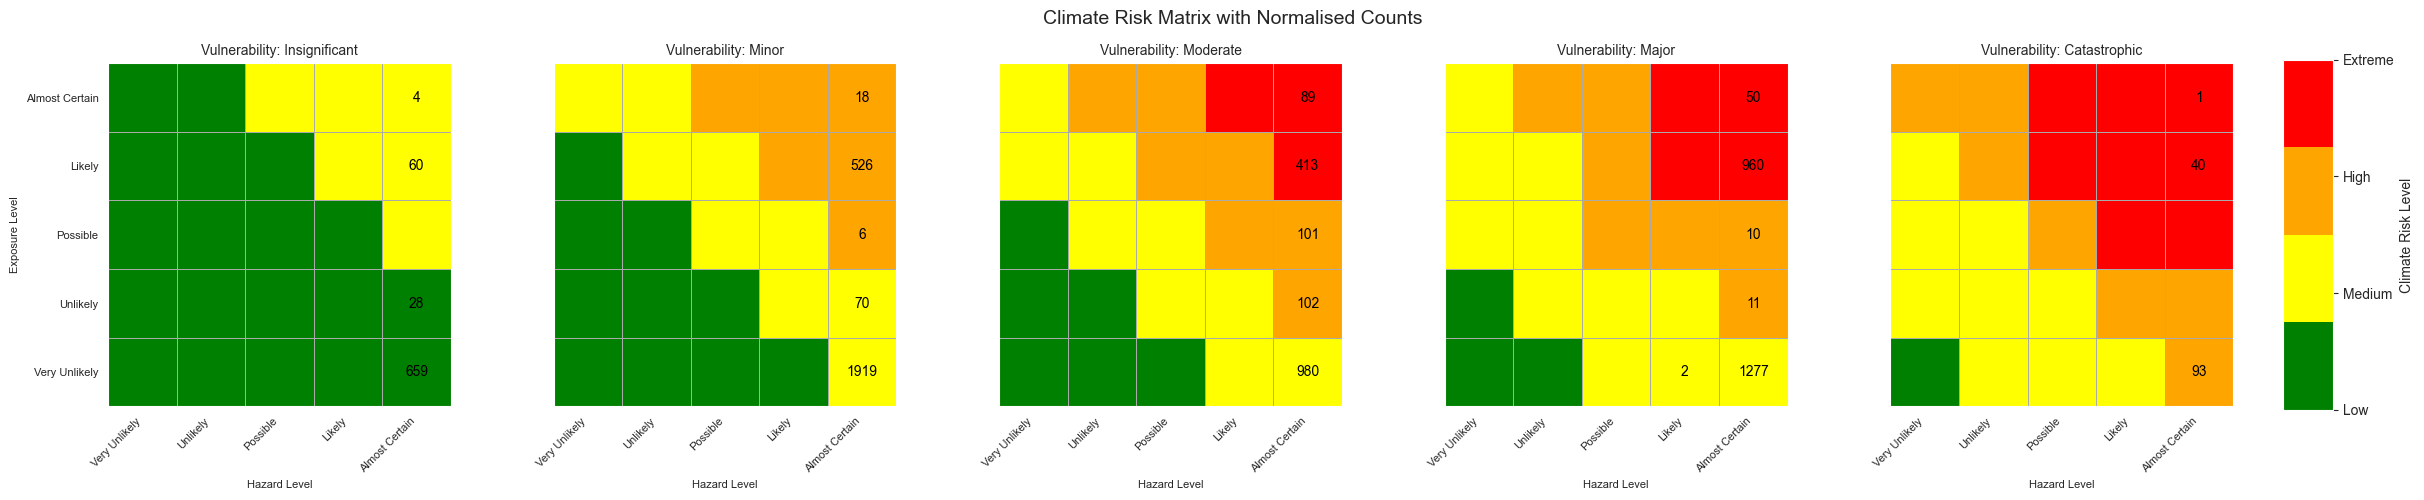

[2025-11-01 23:09:56.281912] Visualisation saved to ../data/processed/model_app/out_cra\climate_risk_matrix_with_counts_5x5x5_3.0_model_app.png


In [24]:
# GENERATE RISK MATRIX WITH COUNTS (5H x 5E x 5V with 4 Categories)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from datetime import datetime

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
scenario_id = "current"  # Update scenario ["current", "1.5", "2.0", "3.0"]
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
risk_matrix_path = os.path.join(output_dir, "../climate_risk_matrix_input_5h5e5v_4cat.csv")
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")
output_path = os.path.join(output_dir, f"climate_risk_matrix_with_counts_5x5x5_{scenario_id}_{run_id}.png")

# Define categories (5 levels)
hazard_exposure_categories = ["Very Unlikely", "Unlikely", "Possible", "Likely", "Almost Certain"]
vulnerability_consequence_categories = ["Insignificant", "Minor", "Moderate", "Major", "Catastrophic"]
risk_levels = ["Low", "Medium", "High", "Extreme"]

# Define custom color palette based on risk levels
# colors = ["#4EA72E", "#FFC000", "#E97132", "#FF0000"]  # Green, Yellow, Orange, Red
colors = ["#008000", "#FFFF00", "#FFA500", "#FF0000"]  # Green to Red
cmap = ListedColormap(colors)

# Load data
print(f"[{datetime.now()}] Loading climate risk matrix from {risk_matrix_path}...")
try:
    risk_df = pd.read_csv(risk_matrix_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Climate risk matrix not found at {risk_matrix_path}")

print(f"[{datetime.now()}] Loading climate risk scores from {data_path}...")
try:
    score_df = pd.read_csv(data_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Climate risk scores not found at {data_path}")

# Filter data for 5x5 matrix levels (original)
risk_df = risk_df[
    (risk_df["Hazard_Level"].isin(hazard_exposure_categories)) &
    (risk_df["Exposure_Level"].isin(hazard_exposure_categories)) &
    (risk_df["Vulnerability_Level"].isin(vulnerability_consequence_categories))
    ]

# Filter data for 5x5 matrix levels (normalised)
score_df_norm = score_df[
    (score_df[f"Hazard_sum_norm_Level-{scenario_id}"].isin(hazard_exposure_categories)) &
    (score_df[f"Exposure_sum_norm_Level-{scenario_id}"].isin(hazard_exposure_categories)) &
    (score_df[f"Vulnerability_sum_norm_Level-{scenario_id}"].isin(vulnerability_consequence_categories))
    ]

# Validate data
if score_df_norm.empty:
    raise ValueError("No data remains after filtering for 5x5x5 matrix levels (normalised).")

# Calculate counts for each combination (normalised)
count_df_norm = score_df_norm.groupby([
    f"Hazard_sum_norm_Level-{scenario_id}",
    f"Exposure_sum_norm_Level-{scenario_id}",
    f"Vulnerability_sum_norm_Level-{scenario_id}"
]).size().reset_index(name="Count")

# Calculate and print counts for each risk level (normalised)
print(f"[{datetime.now()}] Counts for each risk level (normalised):")
count_risk_norm = count_df_norm.merge(
    risk_df[["Hazard_Level", "Exposure_Level", "Vulnerability_Level", "Climate_Risk_Level"]],
    left_on=[f"Hazard_sum_norm_Level-{scenario_id}", f"Exposure_sum_norm_Level-{scenario_id}", f"Vulnerability_sum_norm_Level-{scenario_id}"],
    right_on=["Hazard_Level", "Exposure_Level", "Vulnerability_Level"],
    how="left"
)
risk_counts_norm = count_risk_norm.groupby("Climate_Risk_Level")["Count"].sum().reindex(risk_levels, fill_value=0)
for level in risk_levels:
    print(f"{level}: {int(risk_counts_norm.get(level, 0))}")

# Map risk levels to numerical values for coloring
risk_to_value = {level: i for i, level in enumerate(risk_levels)}
risk_df["Risk_Value"] = risk_df["Climate_Risk_Level"].map(risk_to_value)

# Generate normalised risk matrix with counts
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)
axes = axes.flatten()

for idx, vuln in enumerate(vulnerability_consequence_categories):
    # Filter risk matrix for current Vulnerability level
    df_vuln = risk_df[risk_df["Vulnerability_Level"] == vuln]

    # Create 5x5 matrix for Risk_Value
    z = np.zeros((5, 5))
    for i, hazard in enumerate(hazard_exposure_categories):
        for j, exposure in enumerate(hazard_exposure_categories):
            row = df_vuln[
                (df_vuln["Hazard_Level"] == hazard) &
                (df_vuln["Exposure_Level"] == exposure)
                ]
            if not row.empty:
                z[j, i] = row["Risk_Value"].iloc[0]

    # Define mesh grid for pcolormesh
    x = np.arange(-0.5, 5, 1)
    y = np.arange(-0.5, 5, 1)
    X, Y = np.meshgrid(x, y)

    # Plot heatmap with pcolormesh
    pc = axes[idx].pcolormesh(X, Y, z, cmap=cmap, vmin=0, vmax=3, edgecolors='#AAAAAA', linewidths=0.5)
    axes[idx].set_aspect('equal')  # Enforce square aspect ratio

    # Add counts as annotations
    for i, hazard in enumerate(hazard_exposure_categories):
        for j, exposure in enumerate(hazard_exposure_categories):
            row = count_df_norm[
                (count_df_norm[f"Hazard_sum_norm_Level-{scenario_id}"] == hazard) &
                (count_df_norm[f"Exposure_sum_norm_Level-{scenario_id}"] == exposure) &
                (count_df_norm[f"Vulnerability_sum_norm_Level-{scenario_id}"] == vuln)
                ]
            count = row["Count"].iloc[0] if not row.empty else 0
            axes[idx].text(i, j, str(count) if count > 0 else "", ha="center", va="center",
                           color="black" if z[j, i] < 2 else "black", fontsize=10,
                           bbox=dict(facecolor="none", edgecolor="none", pad=2))

    # Set title and labels
    axes[idx].set_title(f"Vulnerability: {vuln}", fontsize=10)
    axes[idx].set_xticks(np.arange(5))
    axes[idx].set_xticklabels(hazard_exposure_categories, rotation=45, ha="right", fontsize=8)
    axes[idx].set_yticks(np.arange(5))
    axes[idx].set_yticklabels(hazard_exposure_categories, fontsize=8)
    axes[idx].set_xlabel("Hazard Level", fontsize=8)
    if idx == 0:
        axes[idx].set_ylabel("Exposure Level", fontsize=8)

# Add colorbar outside the subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax)
cbar.set_ticks(range(4))
cbar.set_label("Climate Risk Level", fontsize=10)
cbar.set_ticklabels(risk_levels, fontsize=10)

# Adjust layout manually
fig.subplots_adjust(left=0.05, right=0.90, top=0.85, bottom=0.15, wspace=0.3)

# Add overall title
fig.suptitle("Climate Risk Matrix with Normalised Counts", fontsize=14, y=0.95)

# Save figure
print(f"[{datetime.now()}] Saving 5x5x5 normalised heatmaps to {output_path}...")
plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"[{datetime.now()}] Visualisation saved to {output_path}")


# CRA Results Analysis

In [25]:
# COMBINE ALL CRA FOR SCENARIOS
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime

# run_id_dev = "model_dev"
# outputs_id_dev = "out_crisks"
# scenario_id_dev = "current"
# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
path_cra_calc = os.path.join(output_dir, f"../../{run_id_dev}/gdf_road_clim_cln_final_cra_calc.geojson")  #from `model_dev`
scenario_ids = ["current", "1.5", "2.0", "3.0"]

print(f"[{datetime.now()}] ---- Combining CRA Outputs into Geospatial Dataset ----")

# Load geospatial data
print(f"[{datetime.now()}] Loading geospatial data...")
gdf = gpd.read_file(path_cra_calc)
gdf = gdf[["road_link_id", "RGN_LONG_N",
           "link_length", "link_length_km", "FLOW",
           "geometry",
           ]]
print(f"[{datetime.now()}] Loaded {len(gdf)} records from gdf_road_clim_cln_final_cra_calc.geojson")

# Validate road_link_id uniqueness
if gdf["road_link_id"].duplicated().sum() > 0:
    raise ValueError("Duplicate road_link_id values found in geospatial data")

# Initialize merged DataFrame
merged_gdf = gdf.copy()

# Define columns to extract from each scenario
base_cols = [
    "road_link_id",

    "Hazard_sum-{scenario_id}", "Hazard_sum_norm-{scenario_id}", "Hazard_sum_norm_Level-{scenario_id}",
    "Exposure_sum-{scenario_id}", "Exposure_sum_norm-{scenario_id}", "Exposure_sum_norm_Level-{scenario_id}",
    "Vulnerability_sum-{scenario_id}", "Vulnerability_sum_norm-{scenario_id}", "Vulnerability_sum_norm_Level-{scenario_id}",

    "CRS-{scenario_id}", "CRS_Level-{scenario_id}",
    "CR_Level_comp_norm-{scenario_id}",

    "Likelihood_norm-{scenario_id}", "Likelihood_norm Level-{scenario_id}",
    "Consequence_norm-{scenario_id}", "Consequence_norm Level-{scenario_id}",
    # "CR_Level_lc_norm-{scenario_id}",
]

current_extra_cols = ["Distress_Score", "Distress_Score_Level", "Norm_Roughness", "Norm_Rutting", "Norm_Cracking",
                      "Roughness_", "Rutting_Ca", "Cracking_C",
                      "Distress_Score_max", "Distress_Score_max_Level", "Ro-Ru-Cr"
                      ]

# Merge CR data for each scenario
for scenario_id in scenario_ids:
    print(f"[{datetime.now()}] Processing scenario gwl-{scenario_id}...")
    path_cra_scores = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv")
    if not os.path.exists(path_cra_scores):
        raise FileNotFoundError(f"CR scores file not found: {path_cra_scores}")

    # Load CRA scores
    df = pd.read_csv(path_cra_scores)

    # Select columns
    cols = [col.format(scenario_id=scenario_id) for col in base_cols]
    if scenario_id == "current":
        cols.extend(current_extra_cols)

    # Validate columns
    missing_cols = [col for col in cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in gwl-{scenario_id} data: {missing_cols}")

    # Subset DataFrame
    df = df[cols]

    # Validate road_link_id uniqueness
    if df["road_link_id"].duplicated().sum() > 0:
        raise ValueError(f"Duplicate road_link_id values found in gwl-{scenario_id} data")

    # Merge with geospatial data
    merged_gdf = merged_gdf.merge(df, on="road_link_id", how="left")
    print(f"[{datetime.now()}] Merged {len(df)} records for gwl-{scenario_id}")

# Validate merged data
print(f"[{datetime.now()}] Validating merged data...")
if merged_gdf["road_link_id"].duplicated().sum() > 0:
    raise ValueError("Duplicate road_link_id values found in merged data")
missing_values = merged_gdf.isna().sum()
if missing_values.sum() > 0:
    print(f"[{datetime.now()}] Warning: Missing values detected:")
    print(missing_values[missing_values > 0])

# Save combined dataset
output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}.geojson")
merged_gdf.to_file(output_path, driver="GeoJSON")
output_path_csv = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}.csv")
merged_gdf.drop(columns='geometry').to_csv(output_path_csv, index=False)

print(f"[{datetime.now()}] Saved combined CRS dataset to {output_path}")
print(f"[{datetime.now()}] CRS output combination completed for all scenarios.")

# Offset Output Road Links by 40m
from src.ricraf_dev import offset_line
merged_gdf_offset = merged_gdf.copy()

# Offset 40m to the left
merged_gdf_offset['geometry'] = merged_gdf_offset.apply(
    lambda row: offset_line(row['geometry'], 40, row.get('road_link_id')),
    axis=1
)
offset_output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_offset.geojson")
merged_gdf_offset.to_file(offset_output_path, driver="GeoJSON")
print(f"[{datetime.now()}] Saved offset dataset to {offset_output_path}")


[2025-11-02 00:32:45.096563] ---- Combining CRA Outputs into Geospatial Dataset ----
[2025-11-02 00:32:45.096563] Loading geospatial data...
[2025-11-02 00:32:46.172220] Loaded 7419 records from gdf_road_clim_cln_final_cra_calc.geojson
[2025-11-02 00:32:46.174220] Processing scenario gwl-current...
[2025-11-02 00:32:46.283610] Merged 7419 records for gwl-current
[2025-11-02 00:32:46.283610] Processing scenario gwl-1.5...
[2025-11-02 00:32:46.384585] Merged 7419 records for gwl-1.5
[2025-11-02 00:32:46.384585] Processing scenario gwl-2.0...
[2025-11-02 00:32:46.471320] Merged 7419 records for gwl-2.0
[2025-11-02 00:32:46.471320] Processing scenario gwl-3.0...
[2025-11-02 00:32:46.548669] Merged 7419 records for gwl-3.0
[2025-11-02 00:32:46.548669] Validating merged data...
[2025-11-02 00:32:49.194947] Saved combined CRS dataset to ../data/processed/model_app/out_cra\climate_risk_scores_gwl-all_model_app.geojson
[2025-11-02 00:32:49.194947] CRS output combination completed for all scenar

In [30]:
# MONOTONIC TREND CHECK (future scenarios)
from scipy.stats import kendalltau
import numpy as np

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
path_csv = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}.csv")
df = pd.read_csv(path_csv)

print(f"\n[{datetime.now()}] ---- Trend checks across warming levels ----")
scenarios = ["current", "1.5", "2.0", "3.0"]
means   = [df[f"CRS-{s}"].mean() for s in scenarios]
medians = [df[f"CRS-{s}"].median() for s in scenarios]

print("Mean CRiskS :", dict(zip(scenarios, means)))
print("Median CRiskS:", dict(zip(scenarios, medians)))

# Kendall τ on the *sequence* of means (non-parametric monotonicity)
tau, p_tau = kendalltau(range(len(means)), means)
print(f"Kendall τ = {tau:.3f} (p = {p_tau:.3f})")

# Save to a JSON for the paper
trend_res = {
    "means": dict(zip(scenarios, means)),
    "medians": dict(zip(scenarios, medians)),
    "kendall_tau": tau,
    "kendall_p": p_tau
}
with open(os.path.join(output_dir, "trend_check_all_scenarios.json"), "w") as f:
    json.dump(trend_res, f, indent=2)


# ZERO-RISK EDGE CASE CHECK
zero_risk_threshold = 0.10  # >10% → warn
zero_summary = pd.DataFrame({
    "Scenario": scenario_ids,
    "ZeroLinks": [(df[f"CRS-{s}"] == 0).sum() for s in scenario_ids],
    "ZeroPct": [(df[f"CRS-{s}"] == 0).sum() / len(df) * 100 for s in scenario_ids]
})
zero_summary.to_csv(os.path.join(output_dir, "zero_risk_summary.csv"), index=False)
print(zero_summary)

for _, row in zero_summary.iterrows():
    if row["ZeroPct"] > zero_risk_threshold * 100:
        logger.warning(f"High zero-risk ({row['ZeroPct']:.1f}%) in {row['Scenario']}. Check predictors.")


# ZERO-RISK EDGE CASE CHECK
zero_risk_threshold = 0.10   # >10 % of links → raise warning

for scenario_id in scenario_ids:
    crs_col = f"CRS-{scenario_id}"
    zero_cnt = (df[crs_col] == 0).sum()
    zero_pct = zero_cnt / len(df) * 100

    print(f"gwl-{scenario_id}: {zero_cnt} links with CRiskS = 0 ({zero_pct:.2f} %)")

    if zero_pct > zero_risk_threshold * 100:
        logger.warning(
            f"High proportion of zero-risk links ({zero_pct:.1f} %) in {scenario_id}. "
            "Check predictor coverage (e.g. missing AADT, surface type)."
        )
    # Save flag for the paper
    df[f"ZeroRiskFlag-{scenario_id}"] = (df[crs_col] == 0).astype(int)

# Export a summary table
zero_summary = pd.DataFrame({
    "Scenario": scenario_ids,
    "ZeroLinks": [(df[f"CRS-{s}"] == 0).sum() for s in scenario_ids],
    "ZeroPct"  : [(df[f"CRS-{s}"] == 0).sum() / len(df) * 100 for s in scenario_ids]
})
zero_summary.to_csv(os.path.join(output_dir, "zero_risk_summary.csv"), index=False)




[2025-11-02 02:00:04.054061] ---- Trend checks across warming levels ----
Mean CRiskS : {'current': np.float64(0.01699149780662096), '1.5': np.float64(0.02644372670697885), '2.0': np.float64(0.03798803101696796), '3.0': np.float64(0.057493250935503046)}
Median CRiskS: {'current': 0.003726433485379, '1.5': 0.0060472155421829, '2.0': 0.0089741058372074, '3.0': 0.0138842630076212}
Kendall τ = 1.000 (p = 0.083)
gwl-current: 0 links with CRiskS = 0 (0.00 %)
gwl-1.5: 0 links with CRiskS = 0 (0.00 %)
gwl-2.0: 0 links with CRiskS = 0 (0.00 %)
gwl-3.0: 0 links with CRiskS = 0 (0.00 %)


# VISUALISATION - Plot Thermatic Maps

In [26]:
# # Plot Thermatic Maps
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
from datetime import datetime
import numpy as np
from pyproj import Transformer
from shapely.geometry import Point

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
# os.makedirs(output_dir, exist_ok=True)
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_offset.geojson")
scenario_ids = ["current", "1.5", "2.0", "3.0"]

# Load geospatial data
print(f"[{datetime.now()}] Loading geospatial data...")
gdf = gpd.read_file(data_path)

# Ensure GeoDataFrame is in EPSG:3111
if gdf.crs != "EPSG:3111":
    gdf = gdf.to_crs("EPSG:3111")

# Define required columns
required_cols = ["road_link_id", "geometry", "Roughness_", "Rutting_Ca", "Cracking_C",
                 "Norm_Roughness", "Norm_Rutting", "Norm_Cracking", "Distress_Score",
                 "Distress_Score_Level",
                 ]
for scenario_id in scenario_ids:
    required_cols.extend([
        f"CRS_Level-{scenario_id}",
        f"CR_Level_comp_norm-{scenario_id}",
        f"Hazard_sum_norm_Level-{scenario_id}",
        f"Exposure_sum_norm_Level-{scenario_id}",
        f"Vulnerability_sum_norm_Level-{scenario_id}",
        # f"Likelihood_norm Level-{scenario_id}",
        # f"Consequence_norm Level-{scenario_id}",
        f"CR_Level_comp_norm-{scenario_id}",
    ])

# Validate required columns
missing_cols = [col for col in required_cols if col not in gdf.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

# Validate categorical values
roughness_valid = ["Good (for <3.4IRI)", "Fair (for 3.4IRI to < 4.2IRI)",
                   "Poor (for 4.2IRI to < 5.3IRI)", "Very Poor (for >= 5.3IRI)"]
rutting_valid = ["Good (for <10mm)", "Fair (for 10mm to < 15mm)",
                 "Poor (for 15mm to < 20mm)", "Very Poor (for >= 20mm)"]
cracking_valid = ["Good (for <10%)", "Poor (for >= 10%)"]
hazard_exposure_valid = ["Very Unlikely", "Unlikely", "Possible", "Likely", "Almost Certain"]
vulnerability_valid = ["Insignificant", "Minor", "Moderate", "Major", "Catastrophic"]
cat_valid = ["Category 1", "Category 2", "Category 3", "Category 4"]
level_valid = ["Low", "Medium", "High", "Extreme"]

# Validate existing categorical columns
if not gdf["Roughness_"].isin(roughness_valid).all():
    raise ValueError("Invalid categories in Roughness_")
if not gdf["Rutting_Ca"].isin(rutting_valid).all():
    raise ValueError("Invalid categories in Rutting_Ca")
if not gdf["Cracking_C"].isin(cracking_valid).all():
    raise ValueError("Invalid categories in Cracking_C")
if not gdf["Distress_Score_Level"].isin(cat_valid).all():
    raise ValueError("Invalid categories in Cat_Distress_Score")

# Validate new categorical columns
for scenario_id in scenario_ids:
    if not gdf[f"Hazard_sum_norm_Level-{scenario_id}"].isin(hazard_exposure_valid).all():
        raise ValueError(f"Invalid categories in Hazard_sum_norm_Level-{scenario_id}")
    if not gdf[f"Exposure_sum_norm_Level-{scenario_id}"].isin(hazard_exposure_valid).all():
        raise ValueError(f"Invalid categories in Exposure_sum_norm_Level-{scenario_id}")
    if not gdf[f"Vulnerability_sum_norm_Level-{scenario_id}"].isin(vulnerability_valid).all():
        raise ValueError(f"Invalid categories in Vulnerability_norm_sum_norm_Level-{scenario_id}")
    if not gdf[f"CRS_Level-{scenario_id}"].isin(cat_valid).all():
        raise ValueError(f"Invalid categories in CRS_Level-{scenario_id}")
    if not gdf[f"CR_Level_comp_norm-{scenario_id}"].isin(level_valid).all():
        raise ValueError(f"Invalid categories in CR_Level_comp_norm-{scenario_id}")

# Validate continuous values
continuous_cols = ["Distress_Score", "Norm_Roughness", "Norm_Rutting", "Norm_Cracking"]
for col in continuous_cols:
    if not gdf[col].between(0, 1).all():
        raise ValueError(f"Values in {col} must be between 0 and 1")
if not gdf["CRS-current"].between(0, 0.199424).all():
    raise ValueError("Values in CRA-current must be between 0 and 0.128988")

# Define colour schemes for categorical variables
two_colours = ["#008000", "#FF0000"]  # Green, Red
four_colours = ["#008000", "#FFFF00", "#FFA500", "#FF0000"]  # Green to Red
five_colours = ["#008000", "#80FF00", "#FFFF00", "#FFA500", "#FF0000"]  # Green to Red with Yellow

# Define category orders
roughness_categories = ["Good (for <3.4IRI)", "Fair (for 3.4IRI to < 4.2IRI)",
                        "Poor (for 4.2IRI to < 5.3IRI)", "Very Poor (for >= 5.3IRI)"]
rutting_categories = ["Good (for <10mm)", "Fair (for 10mm to < 15mm)",
                      "Poor (for 15mm to < 20mm)", "Very Poor (for >= 20mm)"]
cracking_categories = ["Good (for <10%)", "Poor (for >= 10%)"]
hazard_exposure_categories = ["Very Unlikely", "Unlikely", "Possible", "Likely", "Almost Certain"]
vulnerability_categories = ["Insignificant", "Minor", "Moderate", "Major", "Catastrophic"]
cat_categories = ["Category 1", "Category 2", "Category 3", "Category 4"]
level_categories = ["Low", "Medium", "High", "Extreme"]

# Create colour mappings for categorical variables
roughness_color_map = dict(zip(roughness_categories, range(len(roughness_categories))))
rutting_color_map = dict(zip(rutting_categories, range(len(rutting_categories))))
cracking_color_map = dict(zip(cracking_categories, range(len(cracking_categories))))
cat_distress_color_map = dict(zip(cat_categories, range(len(cat_categories))))

hazard_exposure_color_map = dict(zip(hazard_exposure_categories, range(len(hazard_exposure_categories))))
vulnerability_color_map = dict(zip(vulnerability_categories, range(len(vulnerability_categories))))
crs_level_color_map = dict(zip(cat_categories, range(len(cat_categories))))
cr_level_comp_color_map = dict(zip(level_categories, range(len(level_categories))))

# Create numerical columns for categorical plotting
gdf["Roughness_idx"] = gdf["Roughness_"].map(roughness_color_map)
gdf["Rutting_idx"] = gdf["Rutting_Ca"].map(rutting_color_map)
gdf["Cracking_idx"] = gdf["Cracking_C"].map(cracking_color_map)
gdf["Distress_Level_idx"] = gdf["Distress_Score_Level"].map(cat_distress_color_map)
# gdf["Cat_CRA_idx"] = gdf["Cat_CRA-current_r2"].map(cat_cra_map)

for scenario_id in scenario_ids:
    gdf[f"Hazard_sum_norm_Level-{scenario_id}_idx"] = gdf[f"Hazard_sum_norm_Level-{scenario_id}"].map(hazard_exposure_color_map)
    gdf[f"Exposure_sum_norm_Level-{scenario_id}_idx"] = gdf[f"Exposure_sum_norm_Level-{scenario_id}"].map(hazard_exposure_color_map)
    gdf[f"Vulnerability_sum_norm_Level-{scenario_id}_idx"] = gdf[f"Vulnerability_sum_norm_Level-{scenario_id}"].map(vulnerability_color_map)
    gdf[f"Likelihood_norm Level_{scenario_id}_idx"] = gdf[f"Likelihood_norm Level-{scenario_id}"].map(hazard_exposure_color_map)
    gdf[f"Consequence_norm Level-{scenario_id}_idx"] = gdf[f"Consequence_norm Level-{scenario_id}"].map(vulnerability_color_map)
    gdf[f"CRS_Level-{scenario_id}_idx"] = gdf[f"CRS_Level-{scenario_id}"].map(crs_level_color_map)
    gdf[f"CR_Level_comp_norm-{scenario_id}_idx"] = gdf[f"CR_Level_comp_norm-{scenario_id}"].map(cr_level_comp_color_map)

# Define Melbourne CBD coordinates and transform to EPSG:3111
melbourne_cbd_wgs84 = (-37.812400, 144.962300)  # (latitude, longitude)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3111", always_xy=True)
cbd_x, cbd_y = transformer.transform(melbourne_cbd_wgs84[1], melbourne_cbd_wgs84[0])

# Create a 20 km radius buffer (40 km diameter)
buffer_radius = 20000  # meters
cbd_point = Point(cbd_x, cbd_y)
buffer = cbd_point.buffer(buffer_radius)
gdf_zoomed = gdf[gdf.geometry.within(buffer)]

# Define bounds for zoomed plots (±20,000 meters from CBD point)
zoom_bounds = (cbd_x - buffer_radius, cbd_x + buffer_radius, cbd_y - buffer_radius, cbd_y + buffer_radius)

# Create custom colormaps for categorical variables
roughness_cmap = mcolors.ListedColormap(four_colours)
rutting_cmap = mcolors.ListedColormap(four_colours)
cracking_cmap = mcolors.ListedColormap(two_colours)
hazard_exposure_cmap = mcolors.ListedColormap(five_colours)
vulnerability_cmap = mcolors.ListedColormap(five_colours)
crs_level_cmap = mcolors.ListedColormap(four_colours)
cat_distress_cmap = mcolors.ListedColormap(four_colours)
cr_level_comp_cmap = mcolors.ListedColormap(four_colours)

# Create normalisation for categorical color mapping
roughness_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(four_colours) + 1) - 0.5, ncolors=len(four_colours))
rutting_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(four_colours) + 1) - 0.5, ncolors=len(four_colours))
cracking_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(two_colours) + 1) - 0.5, ncolors=len(two_colours))
cat_distress_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(four_colours) + 1) - 0.5, ncolors=len(four_colours))
hazard_exposure_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(five_colours) + 1) - 0.5, ncolors=len(five_colours))
vulnerability_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(five_colours) + 1) - 0.5, ncolors=len(five_colours))
crs_level_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(four_colours) + 1) - 0.5, ncolors=len(four_colours))
cr_level_comp_norm = mcolors.BoundaryNorm(boundaries=np.arange(len(four_colours) + 1) - 0.5, ncolors=len(four_colours))

# Define continuous colormap (green to red with yellow in the middle)
continuous_cmap = mcolors.LinearSegmentedColormap.from_list(
    "green_to_red", ["#008000", "#80FF00", "#FFFF00", "#FFA500", "#FF0000"]
)

# Plotting function
def plot_thematic_map(gdf, column, title, cmap, norm=None, categories=None, filename=None, bounds=None):
    fig, ax = plt.subplots(figsize=(10, 8))
    # Plot with appropriate parameters based on data type
    if norm is not None and categories is not None:
        # Categorical plot
        plot = gdf.plot(column=column, cmap=cmap, norm=norm, ax=ax, linewidth=1.0)
        cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
        cb = fig.colorbar(plot.get_children()[0], cax=cax, label="Category")
        cb.set_ticks(np.arange(len(categories)))
        cb.set_ticklabels(categories)
    else:
        # Continuous plot
        if column == "CRS-current":
            plot = gdf.plot(column=column, cmap=cmap, ax=ax, linewidth=1.0, vmin=0, vmax=0.128988)
            cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
            cb = fig.colorbar(plot.get_children()[0], cax=cax, label=title)
            cb.set_ticks(np.linspace(0, 0.128988, 5))  # Evenly spaced ticks for CRA-current
        else:
            plot = gdf.plot(column=column, cmap=cmap, ax=ax, linewidth=1.0, vmin=0, vmax=1)
            cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
            cb = fig.colorbar(plot.get_children()[0], cax=cax, label=title)
            cb.set_ticks(np.linspace(0, 1, 5))  # Evenly spaced ticks for other continuous variables

    # Set plot bounds if provided (for zoomed plots)
    if bounds is not None:
        ax.set_xlim(bounds[0], bounds[1])
        ax.set_ylim(bounds[2], bounds[3])

    # Set title and remove axes
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_axis_off()

    # Save plot
    output_path = os.path.join(output_dir, "thematic_maps", filename)
    os.makedirs(os.path.join(output_dir, "thematic_maps"), exist_ok=True)
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()

# Generate thematic maps
print(f"[{datetime.now()}] Generating thematic maps...")

# Categorical maps (original)
plot_thematic_map(
    gdf,
    "Roughness_idx",
    "Road Surface Roughness by Category",
    roughness_cmap,
    roughness_norm,
    roughness_categories,
    "cat_roughness_map.png"
)
plot_thematic_map(
    gdf,
    "Rutting_idx",
    "Road Surface Rutting by Category",
    rutting_cmap,
    rutting_norm,
    rutting_categories,
    "cat_rutting_map.png"
)
plot_thematic_map(
    gdf,
    "Cracking_idx",
    "Road Surface Cracking by Category",
    cracking_cmap,
    cracking_norm,
    cracking_categories,
    "cat_cracking_map.png"
)
# Continuous maps (original)
plot_thematic_map(
    gdf,
    "CRS-current",
    "Climate Risk Score",
    continuous_cmap,
    filename="crs_map.png"
)
plot_thematic_map(
    gdf,
    "Distress_Score",
    "Distress Score",
    continuous_cmap,
    filename="distress_score_map.png"
)
plot_thematic_map(
    gdf,
    "Distress_Level_idx",
    "Distress Category",
    cat_distress_cmap,
    cat_distress_norm,
    cat_categories,
    "distress_level_map.png"
)
plot_thematic_map(
    gdf,
    "Norm_Roughness",
    "Normalised Roughness",
    continuous_cmap,
    filename="norm_roughness_map.png"
)
plot_thematic_map(
    gdf,
    "Norm_Rutting",
    "Normalised Rutting",
    continuous_cmap,
    filename="norm_rutting_map.png"
)
plot_thematic_map(
    gdf,
    "Norm_Cracking",
    "Normalised Cracking",
    continuous_cmap,
    filename="norm_cracking_map.png"
)
# New categorical maps (original)
for scenario_id in scenario_ids:
    plot_thematic_map(
        gdf,
        f"Hazard_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Hazard Sum Level (gwl-{scenario_id})",
        hazard_exposure_cmap,
        hazard_exposure_norm,
        hazard_exposure_categories,
        f"hazard_sum_norm_level_{scenario_id}_map.png"
    )
    plot_thematic_map(
        gdf,
        f"Exposure_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Exposure Sum Level (gwl-{scenario_id})",
        hazard_exposure_cmap,
        hazard_exposure_norm,
        hazard_exposure_categories,
        f"exposure_sum_norm_level_{scenario_id}_map.png"
    )
    plot_thematic_map(
        gdf,
        f"Vulnerability_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Vulnerability Sum Level (gwl-{scenario_id})",
        vulnerability_cmap,
        vulnerability_norm,
        vulnerability_categories,
        f"vulnerability_sum_norm_level_{scenario_id}_map.png"
    )

    plot_thematic_map(
        gdf,
        f"CRS_Level-{scenario_id}_idx",
        f"Climate Risk Score Level (gwl-{scenario_id})",
        crs_level_cmap,
        crs_level_norm,
        cat_categories,
        f"crs_level_{scenario_id}_map.png"
    )
    plot_thematic_map(
        gdf,
        f"CR_Level_comp_norm-{scenario_id}_idx",
        f"Climate Risk Level (gwl-{scenario_id}) by Component",
        cr_level_comp_cmap,
        cr_level_comp_norm,
        level_categories,
        f"cr_level_comp-norm_{scenario_id}_map.png"
    )


# Zoomed-in maps (20 km radius around Melbourne CBD)
print(f"[{datetime.now()}] Generating zoomed-in thematic maps...")

# Continuous maps (zoomed)
plot_thematic_map(
    gdf_zoomed,
    "CRS-current",
    "Climate Risk Score - Zoomed",
    continuous_cmap,
    filename="zoom_crs_map.png",
    bounds=zoom_bounds
)

# New categorical maps (zoomed)
for scenario_id in scenario_ids:

    plot_thematic_map(
        gdf_zoomed,
        f"Hazard_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Hazard Sum Level (gwl-{scenario_id}) - Zoomed",
        hazard_exposure_cmap,
        hazard_exposure_norm,
        hazard_exposure_categories,
        f"zoom_hazard_sum_norm_level_{scenario_id}_map.png",
        bounds=zoom_bounds
    )
    plot_thematic_map(
        gdf_zoomed,
        f"Exposure_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Exposure Sum Level (gwl-{scenario_id}) - Zoomed",
        hazard_exposure_cmap,
        hazard_exposure_norm,
        hazard_exposure_categories,
        f"zoom_exposure_sum_norm_level_{scenario_id}_map.png",
        bounds=zoom_bounds
    )
    plot_thematic_map(
        gdf_zoomed,
        f"Vulnerability_sum_norm_Level-{scenario_id}_idx",
        f"Normalised Vulnerability Sum Level (gwl-{scenario_id}) - Zoomed",
        vulnerability_cmap,
        vulnerability_norm,
        vulnerability_categories,
        f"zoom_vulnerability_sum_norm_level_{scenario_id}_map.png",
        bounds=zoom_bounds
    )

    plot_thematic_map(
        gdf_zoomed,
        f"CRS_Level-{scenario_id}_idx",
        f"Climate Risk Score Level (gwl-{scenario_id}) - Zoomed",
        crs_level_cmap,
        crs_level_norm,
        cat_categories,
        f"zoom_crs_level_{scenario_id}_map.png",
        bounds=zoom_bounds
    )
    plot_thematic_map(
        gdf_zoomed,
        f"CR_Level_comp_norm-{scenario_id}_idx",
        f"Climate Risk Level (gwl-{scenario_id}) by Component - Zoomed",
        cr_level_comp_cmap,
        cr_level_comp_norm,
        level_categories,
        f"zoom_cr_level_comp-norm_{scenario_id}_map.png",
        bounds=zoom_bounds
    )

print(f"[{datetime.now()}] Thematic maps saved to {output_dir}")


[2025-11-02 00:34:49.484932] Loading geospatial data...
[2025-11-02 00:34:51.812109] Generating thematic maps...
[2025-11-02 00:35:11.055113] Generating zoomed-in thematic maps...
[2025-11-02 00:35:20.242767] Thematic maps saved to ../data/processed/model_app/out_cra


# Spatial Analysis

In [41]:
# SPATIAL ANALYSIS: MORAN'S I AND LISA FOR HOTSPOTS
import libpysal as lps
from esda.moran import Moran, Moran_Local
import geopandas as gpd
import numpy as np
import os
from datetime import datetime
import json
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from libpysal.weights import KNN

print(f"[{datetime.now()}] ---- Spatial Analysis: Hotspots (Moran's I & LISA) ----")

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_offset.geojson")
scenario_ids = ["current", "1.5", "2.0", "3.0"]

# Load data
gdf = gpd.read_file(data_path)
if gdf.crs != "EPSG:3111":
    gdf = gdf.to_crs("EPSG:3111")

# Explode + validate
gdf = gdf.explode(index_parts=False).reset_index(drop=True)
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].copy()

print(f"[{datetime.now()}] Loaded {len(gdf)} features (all area=0 → treated as points)")

# Use centroids for KNN
gdf_centroids = gdf.copy()
gdf_centroids.geometry = gdf.geometry.centroid

# Build KNN weights
k_neighbors = 8
w = KNN.from_dataframe(gdf_centroids, k=k_neighbors)
w.transform = 'r'

print(f"   Using {k_neighbors}-NN on centroids")
print(f"   → Components: {w.n_components} (OK if >1)")
print(f"   → Islands: {len(w.islands)}")

# Drop islands only
if len(w.islands) > 0:
    print(f"   → Dropping {len(w.islands)} islands")
    gdf = gdf.drop(w.islands).reset_index(drop=True)
    gdf_centroids = gdf_centroids.drop(w.islands).reset_index(drop=True)
    w = KNN.from_dataframe(gdf_centroids, k=k_neighbors)
    w.transform = 'r'

# Run LISA
cluster_map = {
    0: "Insignificant",
    1: "Hotspot (HH)",
    2: "Low-High Outlier",
    3: "Coldspot (LL)",
    4: "High-Low Outlier"
}

for scenario_id in scenario_ids:
    print(f"[{datetime.now()}] Processing {scenario_id}...")

    crs_col = f"CRS-{scenario_id}"
    if crs_col not in gdf.columns:
        print(f"   Skipping {scenario_id}: column missing")
        continue

    y = gdf[crs_col].values

    # Global Moran's I
    moran = Moran(y, w)
    print(f"   Moran's I: {moran.I:.3f} (p: {moran.p_sim:.3f})")

    # Local Moran's I
    moran_loc = Moran_Local(y, w, permutations=999)

    if np.any(np.isnan(moran_loc.p_sim)):
        print("   WARNING: Some NaN p-values")
        continue

    # Classify
    sig = moran_loc.p_sim < 0.05
    labels = np.zeros(len(y), dtype=int)
    labels[(moran_loc.q == 1) & sig] = 1  # HH
    labels[(moran_loc.q == 3) & sig] = 3  # LL
    labels[(moran_loc.q == 2) & sig] = 2  # LH
    labels[(moran_loc.q == 4) & sig] = 4  # HL

    # Add to GeoDataFrame
    gdf[f"LISA_Cluster-{scenario_id}"] = labels
    gdf[f"LISA_Label-{scenario_id}"] = [cluster_map[x] for x in labels]  # ← FIXED LINE

    # Save Moran
    with open(os.path.join(output_dir, f"moran_results_gwl-{scenario_id}.json"), 'w') as f:
        json.dump({"I": float(moran.I), "p_sim": float(moran.p_sim)}, f)

# Save outputs
w.to_file(os.path.join(output_dir, f"weights_knn_k{k_neighbors}.gal"), 'gal')
output_path = os.path.join(output_dir, f"final_with_lisa.geojson")
gdf.to_file(output_path, driver='GeoJSON')
print(f"[{datetime.now()}] Saved: {output_path}")

# Plot function
def plot_map(col, title, fname):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf.plot(
        column=col, ax=ax, legend=True, categorical=True,
        cmap=ListedColormap(["#D3D3D3", "#FF0000", "#FF69B4", "#0000FF", "#00BFFF"]),
        legend_kwds={'title': 'LISA Cluster', 'loc': 'lower left'}
    )
    ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    out_plot = os.path.join(output_dir, fname)
    plt.savefig(out_plot, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"   → Saved: {out_plot}")

# Plot all
for sid in scenario_ids:
    col = f"LISA_Label-{sid}"
    if col in gdf.columns:
        plot_map(col, f"Climate Risk Hotspots (GWL {sid}°C)", f"hotspot_map_gwl-{sid}.png")

print(f"[{datetime.now()}] ANALYSIS COMPLETE. Results valid and saved.")


[2025-11-02 02:57:18.956152] ---- Spatial Analysis: Hotspots (Moran's I & LISA) ----
[2025-11-02 02:57:21.929737] Loaded 7421 features (all area=0 → treated as points)
   Using 8-NN on centroids
   → Components: 2 (OK if >1)
   → Islands: 0
[2025-11-02 02:57:22.125140] Processing current...


C:\Users\OneMetis\anaconda3\envs\cracbaf\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


   Moran's I: 0.174 (p: 0.001)
[2025-11-02 02:57:22.763971] Processing 1.5...
   Moran's I: 0.171 (p: 0.001)
[2025-11-02 02:57:23.429132] Processing 2.0...
   Moran's I: 0.170 (p: 0.001)
[2025-11-02 02:57:24.142352] Processing 3.0...
   Moran's I: 0.170 (p: 0.001)
[2025-11-02 02:57:29.519174] Saved: ../data/processed/model_app/out_cra\final_with_lisa.geojson
   → Saved: ../data/processed/model_app/out_cra\hotspot_map_gwl-current.png
   → Saved: ../data/processed/model_app/out_cra\hotspot_map_gwl-1.5.png
   → Saved: ../data/processed/model_app/out_cra\hotspot_map_gwl-2.0.png
   → Saved: ../data/processed/model_app/out_cra\hotspot_map_gwl-3.0.png
[2025-11-02 02:57:33.511224] ANALYSIS COMPLETE. Results valid and saved.


In [42]:
# === HOTSPOT SUMMARY ===
print("\n" + "="*50)
print("HOTSPOT ANALYSIS SUMMARY")
print("="*50)

total_points = len(gdf)
for sid in scenario_ids:
    col = f"LISA_Label-{sid}"
    if col not in gdf.columns:
        continue

    counts = gdf[col].value_counts()
    pct_hh = (counts.get("Hotspot (HH)", 0) / total_points) * 100
    pct_ll = (counts.get("Coldspot (LL)", 0) / total_points) * 100

    print(f"\nGWL {sid}°C:")
    print(f"   Hotspots (HH): {counts.get('Hotspot (HH)', 0):,} ({pct_hh:.1f}%)")
    print(f"   Coldspots (LL): {counts.get('Coldspot (LL)', 0):,} ({pct_ll:.1f}%)")
    print(f"   Significant: {counts.sum() - counts.get('Insignificant', 0):,}")

# === PERSISTENT HOTSPOTS (HH in 3+ scenarios) ===
hh_cols = [f"LISA_Cluster-{sid}" for sid in scenario_ids]
gdf['hh_count'] = gdf[hh_cols].apply(lambda row: sum(row == 1), axis=1)
persistent = gdf[gdf['hh_count'] >= 3]

print(f"\nPERSISTENT HOTSPOTS (HH in 3+ scenarios): {len(persistent)} points")
if len(persistent) > 0:
    persistent.to_file(os.path.join(output_dir, "persistent_hotspots.geojson"), driver='GeoJSON')
    print(f"   → Saved: persistent_hotspots.geojson")


HOTSPOT ANALYSIS SUMMARY

GWL current°C:
   Hotspots (HH): 500 (6.7%)
   Coldspots (LL): 754 (10.2%)
   Significant: 1,879

GWL 1.5°C:
   Hotspots (HH): 529 (7.1%)
   Coldspots (LL): 738 (9.9%)
   Significant: 1,917

GWL 2.0°C:
   Hotspots (HH): 489 (6.6%)
   Coldspots (LL): 726 (9.8%)
   Significant: 1,844

GWL 3.0°C:
   Hotspots (HH): 481 (6.5%)
   Coldspots (LL): 779 (10.5%)
   Significant: 1,886

PERSISTENT HOTSPOTS (HH in 3+ scenarios): 442 points
   → Saved: persistent_hotspots.geojson


In [54]:
import folium
from folium import GeoJson, LayerControl
import os

# --- 1. REPROJECT TO WGS84 (KEEP LINES) ---
gdf_wgs84 = gdf.to_crs("EPSG:4326").copy()

# --- 2. CENTER MAP ---
bounds = gdf_wgs84.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# --- 3. CREATE MAP ---
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles="CartoDB positron"
)

# --- 4. COLORS ---
colors = {
    'current': '#1f78b4',
    '1.5':     '#33a02c',
    '2.0':     '#e31a1c',
    '3.0':     '#ff7f00',
    'persistent': '#8b0000'
}

# --- 5. ADD SCENARIO HOTSPOTS AS LINES ---
scenario_ids = ["current", "1.5", "2.0", "3.0"]

for sid in scenario_ids:
    col = f"LISA_Label-{sid}"
    if col not in gdf_wgs84.columns:
        continue

    hotspots = gdf_wgs84[gdf_wgs84[col] == 'Hotspot (HH)'].copy()
    if len(hotspots) == 0:
        continue

    GeoJson(
        hotspots,
        name=f"Hotspots (GWL {sid}°C)",
        style_function=lambda x, c=colors[sid]: {
            'color': c,
            'weight': 4,
            'opacity': 0.8
        },
        tooltip=folium.GeoJsonTooltip(
            fields=[f"CRS-{sid}"],
            aliases=[f"CRS ({sid}°C):"],
            localize=True
        )
    ).add_to(m)

# --- 6. PERSISTENT HOTSPOTS (THICKER, ON TOP) ---
persistent = gdf_wgs84[gdf_wgs84['hh_count'] >= 3].copy()
if len(persistent) > 0:
    GeoJson(
        persistent,
        name="Persistent Hotspots (3+ scenarios)",
        style_function=lambda x: {
            'color': colors['persistent'],
            'weight': 6,
            'opacity': 1.0
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['hh_count'],
            aliases=['Persistent in # scenarios:'],
            localize=True
        ),
        popup=folium.GeoJsonPopup(
            fields=['hh_count'] + [f"CRS-{s}" for s in scenario_ids],
            aliases=['Persistent:', 'Current:', '1.5°C:', '2.0°C:', '3.0°C:'],
            localize=True
        )
    ).add_to(m)


# Add all roads (low opacity)
all_roads = gdf_wgs84.copy()
GeoJson(
    all_roads,
    name="All Road Links",
    style_function=lambda x: {'color': 'gray', 'weight': 1, 'opacity': 0.3}
).add_to(m)


# --- 7. LAYER CONTROL ---
LayerControl(collapsed=False).add_to(m)

# --- 8. SAVE ---
map_path = os.path.join(output_dir, "interactive_climate_hotspots_LINES.html")
m.save(map_path)
print(f"Interactive LINE map saved:")
print(f"   {map_path}")
print(f"   Open: file://{os.path.abspath(map_path)}")

Interactive LINE map saved:
   ../data/processed/model_app/out_cra\interactive_climate_hotspots_LINES.html
   Open: file://C:\OneMetis Dropbox\@One.IMS\SmartieLab\#repos\ricraf\data\processed\model_app\out_cra\interactive_climate_hotspots_LINES.html


In [44]:
# Export top persistent hotspots
top_persistent = persistent.nlargest(20, 'hh_count')
csv_path = os.path.join(output_dir, "top_20_persistent_hotspots.csv")
top_persistent[['hh_count'] + [f"CRS-{s}" for s in scenario_ids]].to_csv(csv_path)
print(f"Top 20 hotspots saved: {csv_path}")

Top 20 hotspots saved: ../data/processed/model_app/out_cra\top_20_persistent_hotspots.csv


In [45]:
import matplotlib.pyplot as plt

counts = [0, 0, 0, 0]
for i in range(4):
    counts[i] = len(gdf[gdf['hh_count'] == i+1]) if i < 3 else len(gdf[gdf['hh_count'] >= 4])

plt.figure(figsize=(8, 5))
bars = plt.bar(['1 scenario', '2 scenarios', '3 scenarios', '4 scenarios'], counts, color=['#fee08b', '#fdae61', '#f46d43', '#d7191c'])
plt.title('Persistence of Climate Risk Hotspots (HH)', fontsize=14)
plt.ylabel('Number of Locations')
plt.xlabel('Appears as Hotspot in # Scenarios')

# Add counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "hotspot_persistence.png"), dpi=300, bbox_inches='tight')
plt.close()
print("Persistence chart saved: hotspot_persistence.png")

Persistence chart saved: hotspot_persistence.png


# Benchmarking

In [5]:
# BENCHMARKING: ANOVA + TUKEY HSD (ROBUST & REPRODUCIBLE)
import geopandas as gpd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pandas as pd
import os
from datetime import datetime

print(f"[{datetime.now()}] ---- Benchmarking: ANOVA on Distress vs. CRiskS Categories ----")

# Configuration
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_offset.geojson")
scenario_ids = ["current", "1.5", "2.0", "3.0"]

# Load data
gdf = gpd.read_file(data_path)
df = pd.DataFrame(gdf)

# === DEFINE RISK CATEGORIES (CRITICAL) ===
level_categories = ['Low', 'Medium', 'High', 'Extreme']  # ← MUST MATCH YOUR CLASSIFICATION

# === ENSURE Distress_Score EXISTS ===
if "Distress_Score" not in df.columns:
    raise ValueError("Distress_Score not found! Run distress scoring first.")

# === ANOVA + TUKEY FOR EACH SCENARIO ===
anova_results = []

for scenario_id in scenario_ids:
    print(f"[{datetime.now()}] ANOVA for gwl-{scenario_id}...")

    cat_col = f"CR_Level_comp_norm-{scenario_id}"
    if cat_col not in df.columns:
        print(f"   Skipping {scenario_id}: {cat_col} missing")
        continue

    # Group distress by risk level
    groups = []
    group_sizes = []
    for level in level_categories:
        mask = df[cat_col] == level
        distress = df.loc[mask, "Distress_Score"].dropna()
        groups.append(distress)
        group_sizes.append(len(distress))

    if len(groups) < 2 or any(len(g) == 0 for g in groups):
        print(f"   Skipping {scenario_id}: insufficient data in some groups")
        continue

    # ANOVA
    f_stat, p_value = f_oneway(*groups)
    print(f"ANOVA F-stat: {f_stat:.3f}, p-value: {p_value:.3f}")

    # Tukey HSD
    df_tukey = df[[cat_col, "Distress_Score"]].dropna()
    tukey = pairwise_tukeyhsd(
        endog=df_tukey["Distress_Score"],
        groups=df_tukey[cat_col],
        alpha=0.05
    )
    print(tukey)

    # Save
    stats_path = os.path.join(output_dir, f"anova_tukey_gwl-{scenario_id}.txt")
    with open(stats_path, 'w') as f:
        f.write(f"Scenario: {scenario_id}°C\n")
        f.write(f"ANOVA: F={f_stat:.3f}, p={p_value:.3f}\n")
        f.write(f"Group sizes: {dict(zip(level_categories, group_sizes))}\n\n")
        f.write(str(tukey))

    # Store for summary
    anova_results.append({
        'scenario': scenario_id,
        'F': f_stat,
        'p': p_value,
        'groups': group_sizes
    })

print(f"[{datetime.now()}] Benchmarking complete. Results saved.")

[2025-11-04 22:33:47.799411] ---- Benchmarking: ANOVA on Distress vs. CRiskS Categories ----
[2025-11-04 22:33:49.895969] ANOVA for gwl-current...
ANOVA F-stat: 857.225, p-value: 0.000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Extreme   High  -0.0042 0.9986 -0.0727  0.0642  False
Extreme    Low  -0.2302    0.0 -0.2964  -0.164   True
Extreme Medium  -0.0352  0.526 -0.1018  0.0314  False
   High    Low   -0.226    0.0 -0.2452 -0.2067   True
   High Medium  -0.0309 0.0006 -0.0514 -0.0104   True
    Low Medium    0.195    0.0  0.1839  0.2062   True
-----------------------------------------------------
[2025-11-04 22:33:50.046056] ANOVA for gwl-1.5...
ANOVA F-stat: 1100.931, p-value: 0.000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
Extreme   High   0.0098 

In [8]:
# SPEARMAN CORRELATION: CRS vs. DISTRESS INDICATORS
from scipy.stats import spearmanr

print(f"[{datetime.now()}] ---- Spearman Correlations: CRS vs. Distress ----")

distress_indicators = ["Norm_Roughness", "Norm_Rutting", "Norm_Cracking"]  # Raw columns
spearman_results = []

for scenario_id in scenario_ids:
    crs_col = f"CRS-{scenario_id}"
    print(f"\nScenario: {scenario_id}°C")
    for indicator in distress_indicators:
        rho, p = spearmanr(df[crs_col], df[indicator], nan_policy='omit')
        print(f"   CRS vs. {indicator}: ρ = {rho:.3f}, p = {p:.3f}")
        spearman_results.append({'scenario': scenario_id, 'indicator': indicator, 'rho': rho, 'p': p})

# Save as CSV
pd.DataFrame(spearman_results).to_csv(os.path.join(output_dir, "spearman_correlations.csv"), index=False)
print("Spearman results saved: spearman_correlations.csv")

[2025-11-02 14:04:46.303492] ---- Spearman Correlations: CRS vs. Distress ----

Scenario: current°C
   CRS vs. Norm_Roughness: ρ = 0.548, p = 0.000
   CRS vs. Norm_Rutting: ρ = -0.003, p = 0.788
   CRS vs. Norm_Cracking: ρ = 0.279, p = 0.000

Scenario: 1.5°C
   CRS vs. Norm_Roughness: ρ = 0.547, p = 0.000
   CRS vs. Norm_Rutting: ρ = -0.004, p = 0.740
   CRS vs. Norm_Cracking: ρ = 0.285, p = 0.000

Scenario: 2.0°C
   CRS vs. Norm_Roughness: ρ = 0.543, p = 0.000
   CRS vs. Norm_Rutting: ρ = 0.000, p = 0.972
   CRS vs. Norm_Cracking: ρ = 0.287, p = 0.000

Scenario: 3.0°C
   CRS vs. Norm_Roughness: ρ = 0.540, p = 0.000
   CRS vs. Norm_Rutting: ρ = -0.001, p = 0.965
   CRS vs. Norm_Cracking: ρ = 0.287, p = 0.000
Spearman results saved: spearman_correlations.csv


In [10]:
# TREND ANALYSIS: MONOTONIC INCREASE IN CRS ACROSS SCENARIOS
from scipy.stats import kendalltau
import json

print(f"[{datetime.now()}] ---- Trend Analysis: CRS Across Warming Scenarios ----")

# Mean CRS per scenario
crs_means = [df[f"CRS-{sid}"].mean() for sid in scenario_ids]
print("Mean CRS:", dict(zip(scenario_ids, crs_means)))

# Kendall tau for monotonic trend
tau, p_tau = kendalltau(range(len(scenario_ids)), crs_means)
print(f"Kendall tau: {tau:.3f}, p = {p_tau:.3f}")

# Save
trend_path = os.path.join(output_dir, "crs_trend_analysis.json")
with open(trend_path, 'w') as f:
    json.dump({"means": dict(zip(scenario_ids, crs_means)), "tau": tau, "p_tau": p_tau}, f, indent=2)
print("Trend results saved: crs_trend_analysis.json")

[2025-11-02 14:07:05.311643] ---- Trend Analysis: CRS Across Warming Scenarios ----
Mean CRS: {'current': np.float64(0.01699149780662096), '1.5': np.float64(0.02644372670697885), '2.0': np.float64(0.03798803101696796), '3.0': np.float64(0.057493250935503046)}
Kendall tau: 1.000, p = 0.083
Trend results saved: crs_trend_analysis.json


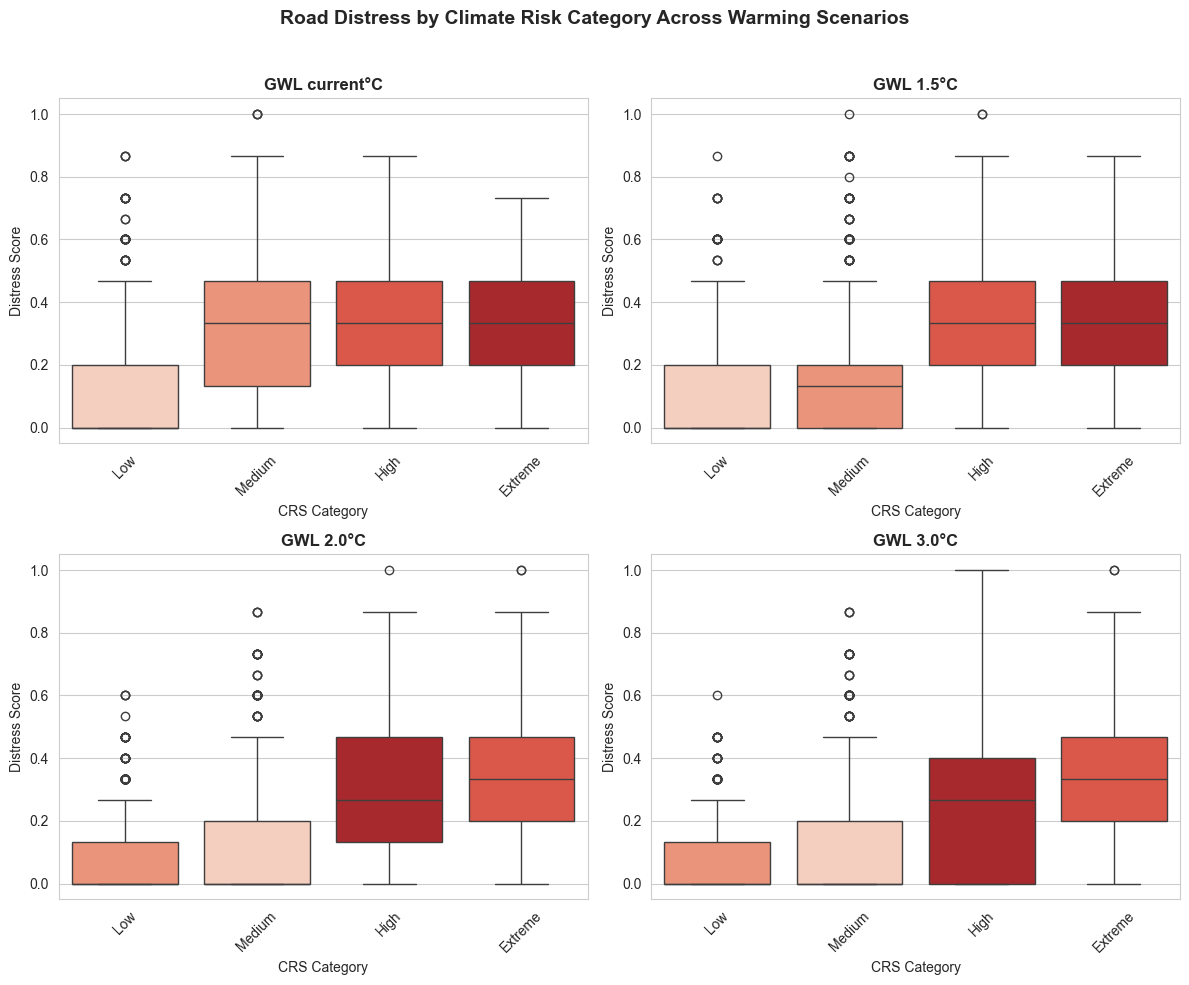

Boxplot saved: ../data/processed/model_app/out_cra\distress_by_crs_boxplot.png


In [7]:
# BOXPLOT OF DISTRESS BY CRS CATEGORY
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import pandas as pd

# Set style
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, sid in enumerate(scenario_ids):
    cat_col = f"CR_Level_comp_norm-{sid}"

    sns.boxplot(
        data=df,
        x=cat_col,
        y="Distress_Score",
        order=level_categories,
        ax=axes[i],
        palette="Reds",
        hue=cat_col,
        legend=False
    )

    axes[i].set_title(f"GWL {sid}°C", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("CRS Category", fontsize=10)
    axes[i].set_ylabel("Distress Score", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Road Distress by Climate Risk Category Across Warming Scenarios",
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle

# Save
plot_path = os.path.join(output_dir, "distress_by_crs_boxplot.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Boxplot saved: {plot_path}")


# Supporting Figures for Reporting

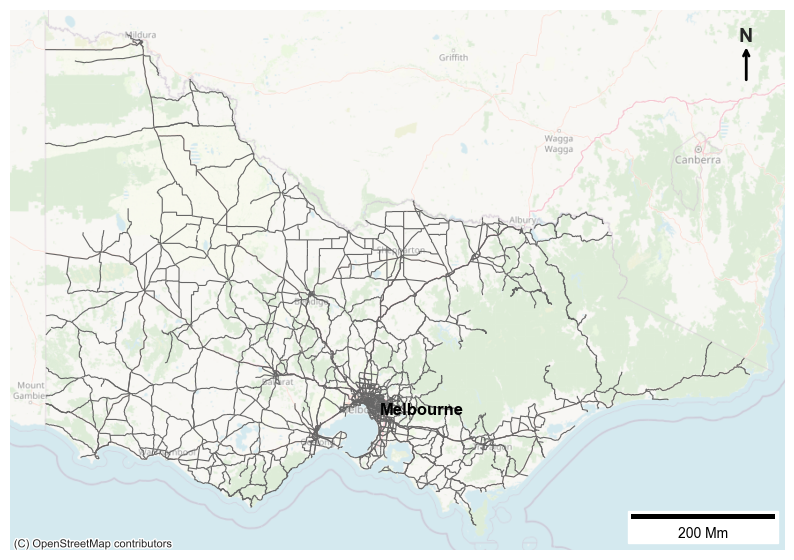

Study area map saved:
   PNG: ../data/processed/model_app/out_cra\fig_study_area_map.png


In [37]:
# STUDY AREA MAP: Victoria, Australia with Road Network
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from matplotlib_scalebar.scalebar import ScaleBar
import os

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_offset.geojson")

# Load data
gdf = gpd.read_file(data_path)

# Ensure CRS is correct (EPSG:3111 → reproject to Web Mercator for basemap)
gdf_web = gdf.to_crs(epsg=3857)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot road network (light gray, thin lines)
gdf_web.plot(ax=ax, color='#666666', linewidth=0.8, alpha=1.0, label='Road Links (n=7,419)')

# Add basemap (light, low opacity)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, alpha=0.5)

# Set title and remove axes
# ax.set_title('Study Area: Road Network of Victoria, Australia', fontsize=14, pad=20)
ax.set_axis_off()

# Add Melbourne label
melbourne_lon, melbourne_lat = 144.9631, -37.8136
melbourne_web = gpd.points_from_xy([melbourne_lon], [melbourne_lat], crs="EPSG:4326").to_crs(epsg=3857)
ax.annotate('Melbourne', xy=(melbourne_web.x[0], melbourne_web.y[0]),
            xytext=(10, -10), textcoords='offset points',
            fontsize=12, fontweight='bold', color='black',
            # bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8)
            )

# Add scale bar
scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right',
                    sep=5, border_pad=0.5, color='black')
ax.add_artist(scalebar)

# Arrow (explicit arrow style)
# Position in axes-fraction coordinates (top-right corner)
x, y, arrow_len = 0.95, 0.95, 0.08  # top-right corner
# "N" label (white box, black border)
ax.annotate(
    'N',
    xy=(x-0.001, y),
    xycoords='axes fraction',
    fontsize=14, fontweight='bold',
    ha='center', va='center',
    # bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.9)
)
# Arrow
ax.annotate(
    '',
    xy=(x, y-0.02),
    xytext=(x, y - arrow_len),
    xycoords='axes fraction',
    arrowprops=dict(
        arrowstyle='->',
        linewidth=2,
        color='black',
        shrinkA=0, shrinkB=0
    )
)

# Save high-res
output_png = os.path.join(output_dir, "fig_study_area_map.png")
# output_pdf = os.path.join(output_dir, "fig_study_area_map.pdf")
fig.savefig(output_png, dpi=300, bbox_inches='tight', facecolor='white')
# fig.savefig(output_pdf, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Study area map saved:\n   PNG: {output_png}")  #\n   PDF: {output_pdf}")


COMPOSITE CLIMATE RISK LEVEL DISTRIBUTION (Current GWL)
Total road links analysed: 7,419

Risk Level   | Count    | Percentage
------------------------------------------
Low          |   4,809 |    64.82%
Medium       |   2,033 |    27.40%
High         |     536 |     7.22%
Extreme      |      41 |     0.55%


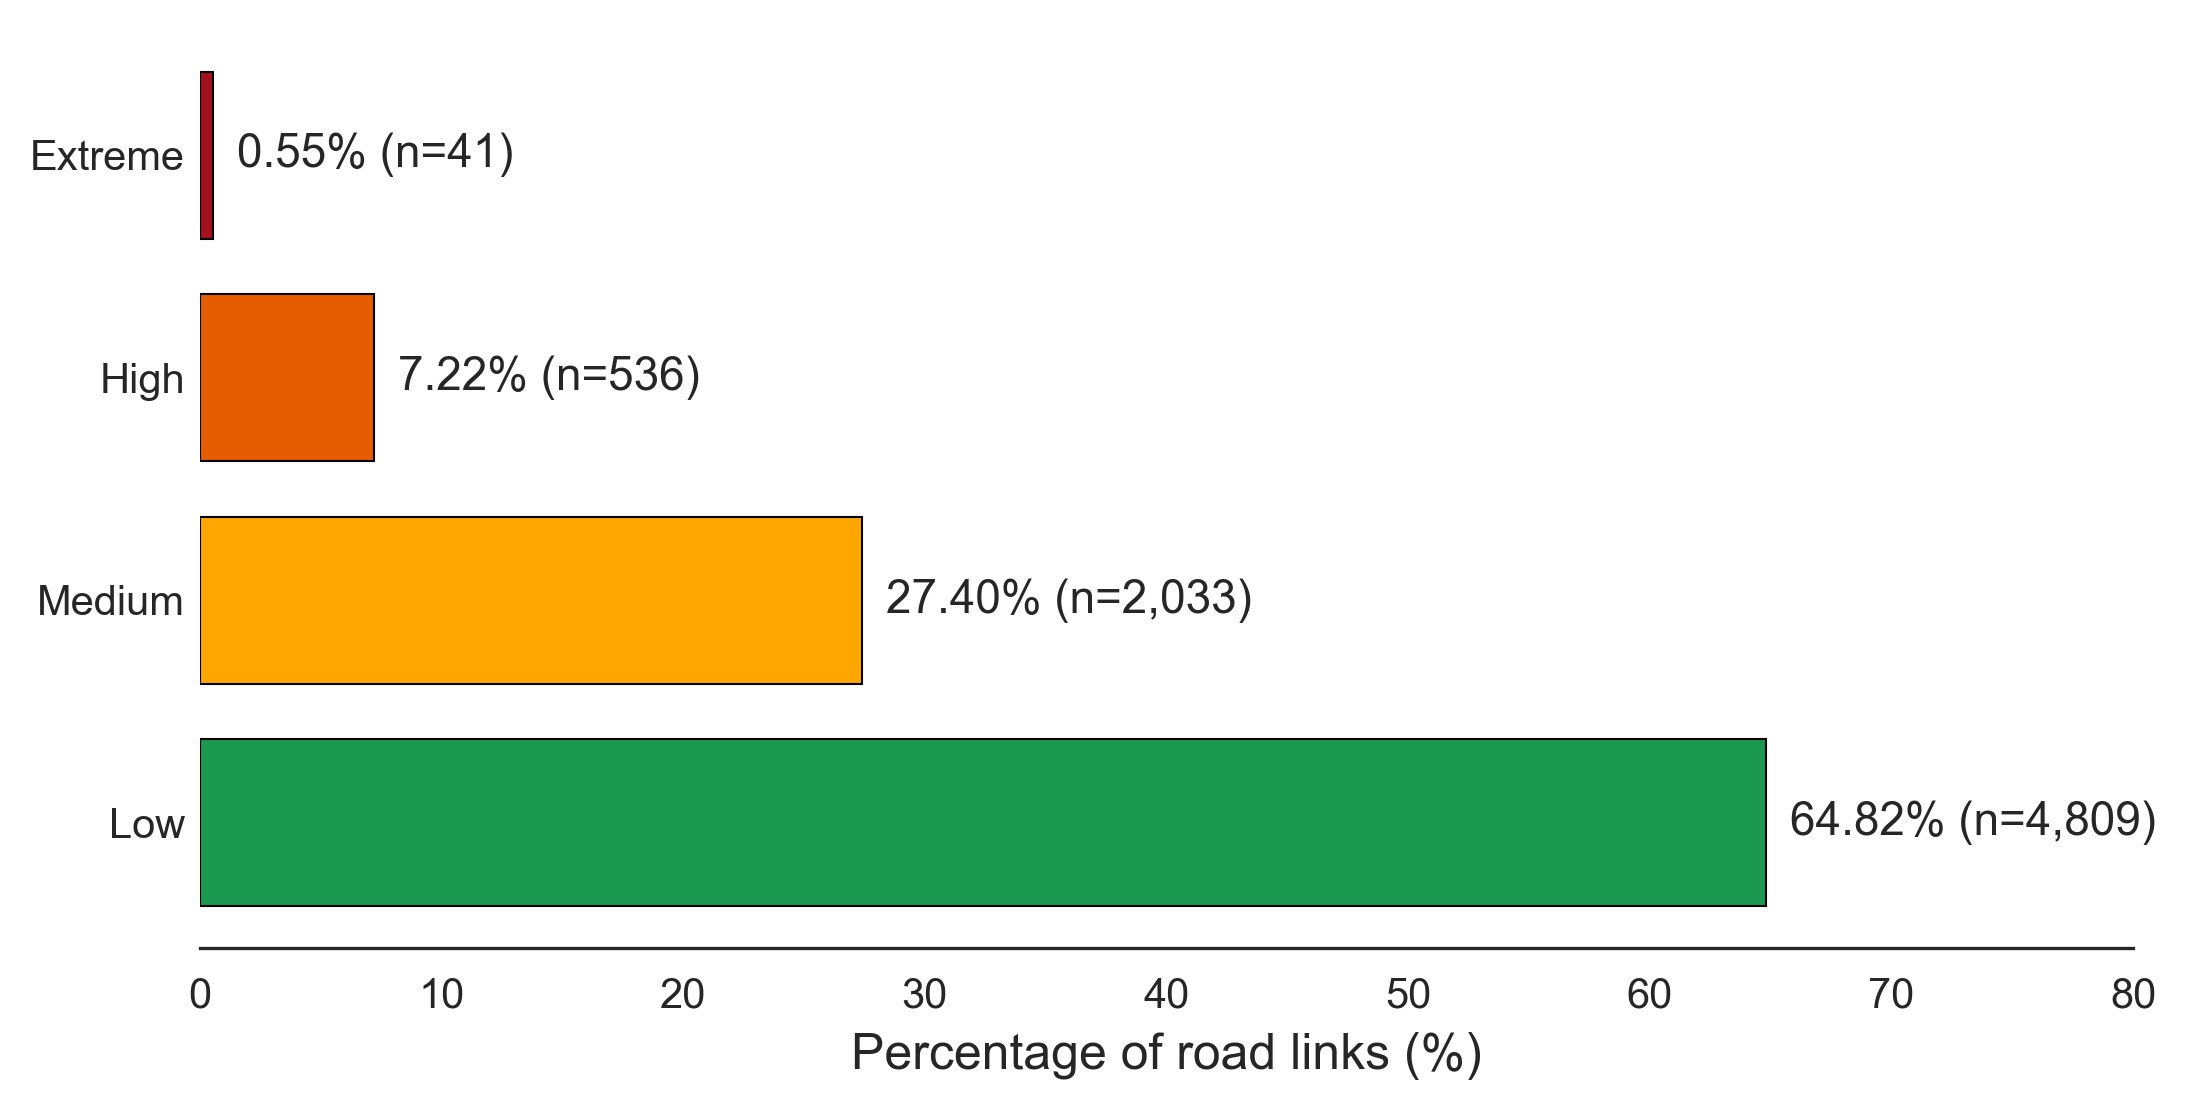

count    7.419000e+03
mean     1.699150e-02
std      2.359718e-02
min      5.590558e-07
25%      1.108387e-03
50%      3.726433e-03
75%      3.084218e-02
max      1.546537e-01
Name: CRS-current, dtype: float64

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-current_{run_id}.csv")

# Load data
df = pd.read_csv(data_path)

# ==================== CR_Level_comp_norm-current distribution ====================
column_risk = 'CR_Level_comp_norm-current'
order = ['Low', 'Medium', 'High', 'Extreme']

counts = df[column_risk].value_counts().reindex(order, fill_value=0)
percentages = (counts / len(df) * 100).round(2)
total_links = len(df)

print("COMPOSITE CLIMATE RISK LEVEL DISTRIBUTION (Current GWL)")
print(f"Total road links analysed: {total_links:,}")
print("\nRisk Level   | Count    | Percentage")
print("-" * 42)
for lvl in order:
    print(f"{lvl:<12} | {counts[lvl]:>7,} | {percentages[lvl]:>8.2f}%")


# ==================== Horizontal bar chart ====================
# Set style
# sns.set_style("whitegrid")
sns.set_style("white")
# sns.set_style("ticks")


fig, ax = plt.subplots(figsize=(7.5, 3.8), dpi=300)

# Risk-increasing colour palette (colour-blind safe where possible)
colors = ['#1a9850', '#ffa600', '#e65c00', '#a1121e']  # green → amber → orange → dark red

# Reverse order so Low appears at the top
bars = ax.barh([lvl for lvl in order[::-1]],
               percentages[::-1],
               color=colors[::-1],
               height=0.75,
               edgecolor='black',
               linewidth=0.5)

# Annotate bars with percentage and count
for bar, pct, cnt in zip(bars, percentages[::-1], counts[::-1]):
    width = bar.get_width()
    ax.text(width + 1,
            bar.get_y() + bar.get_height()/2,
            f'{pct:.2f}% (n={cnt:,})',
            va='center', ha='left', fontsize=11, fontweight='medium')

ax.set_xlabel('Percentage of road links (%)', fontsize=12)
ax.set_xlim(0, 80)
ax.invert_yaxis()
# ax.set_title(f'Distribution of Climate Risk Levels across {total_links:,} road links\n'
#              f'(Current Global Warming Level)',
#              fontsize=13, pad=20, fontweight='bold')

# Minimalist style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)

plt.tight_layout()

# Save plot
output_png = os.path.join(output_dir, "fig_CR_Level_comp_norm_current_distribution.png")
output_pdf = os.path.join(output_dir, "fig_CR_Level_comp_norm_current_distribution.pdf")
plt.savefig(output_png, bbox_inches='tight')
# plt.savefig(output_pdf, bbox_inches='tight', dpi=600)
plt.show()

# ==================== CRS-current descriptive statistics ====================
df['CRS-current'].describe()


   → 7 links missing region → applying nearest fallback
Final missing regions: 0 → All assigned!

=== REGIONAL SUMMARY (GWL 1.2°C (current)) ===
                            VGREG    total_km  high_ext_km  pct_high_ext
            SOUTHERN METROPOLITAN 1725.161059    18.719195          1.09
NORTHERN AND WESTERN METROPOLITAN 1701.248877   194.171870         11.41
                    LODDON MALLEE 4226.496832   457.659701         10.83
                             HUME 3843.156263   236.881670          6.16
                        GRAMPIANS 3550.498057   390.895963         11.01
                        GIPPSLAND 2960.514863    78.290877          2.64
             EASTERN METROPOLITAN 1307.497384    32.935046          2.52
                BARWON SOUTH WEST 3801.984923    81.159330          2.13
----------------------------------------------------------------------
=== REGIONAL SUMMARY (GWL 1.5°C) ===
                            VGREG    total_km  high_ext_km  pct_high_ext
            SOUTH

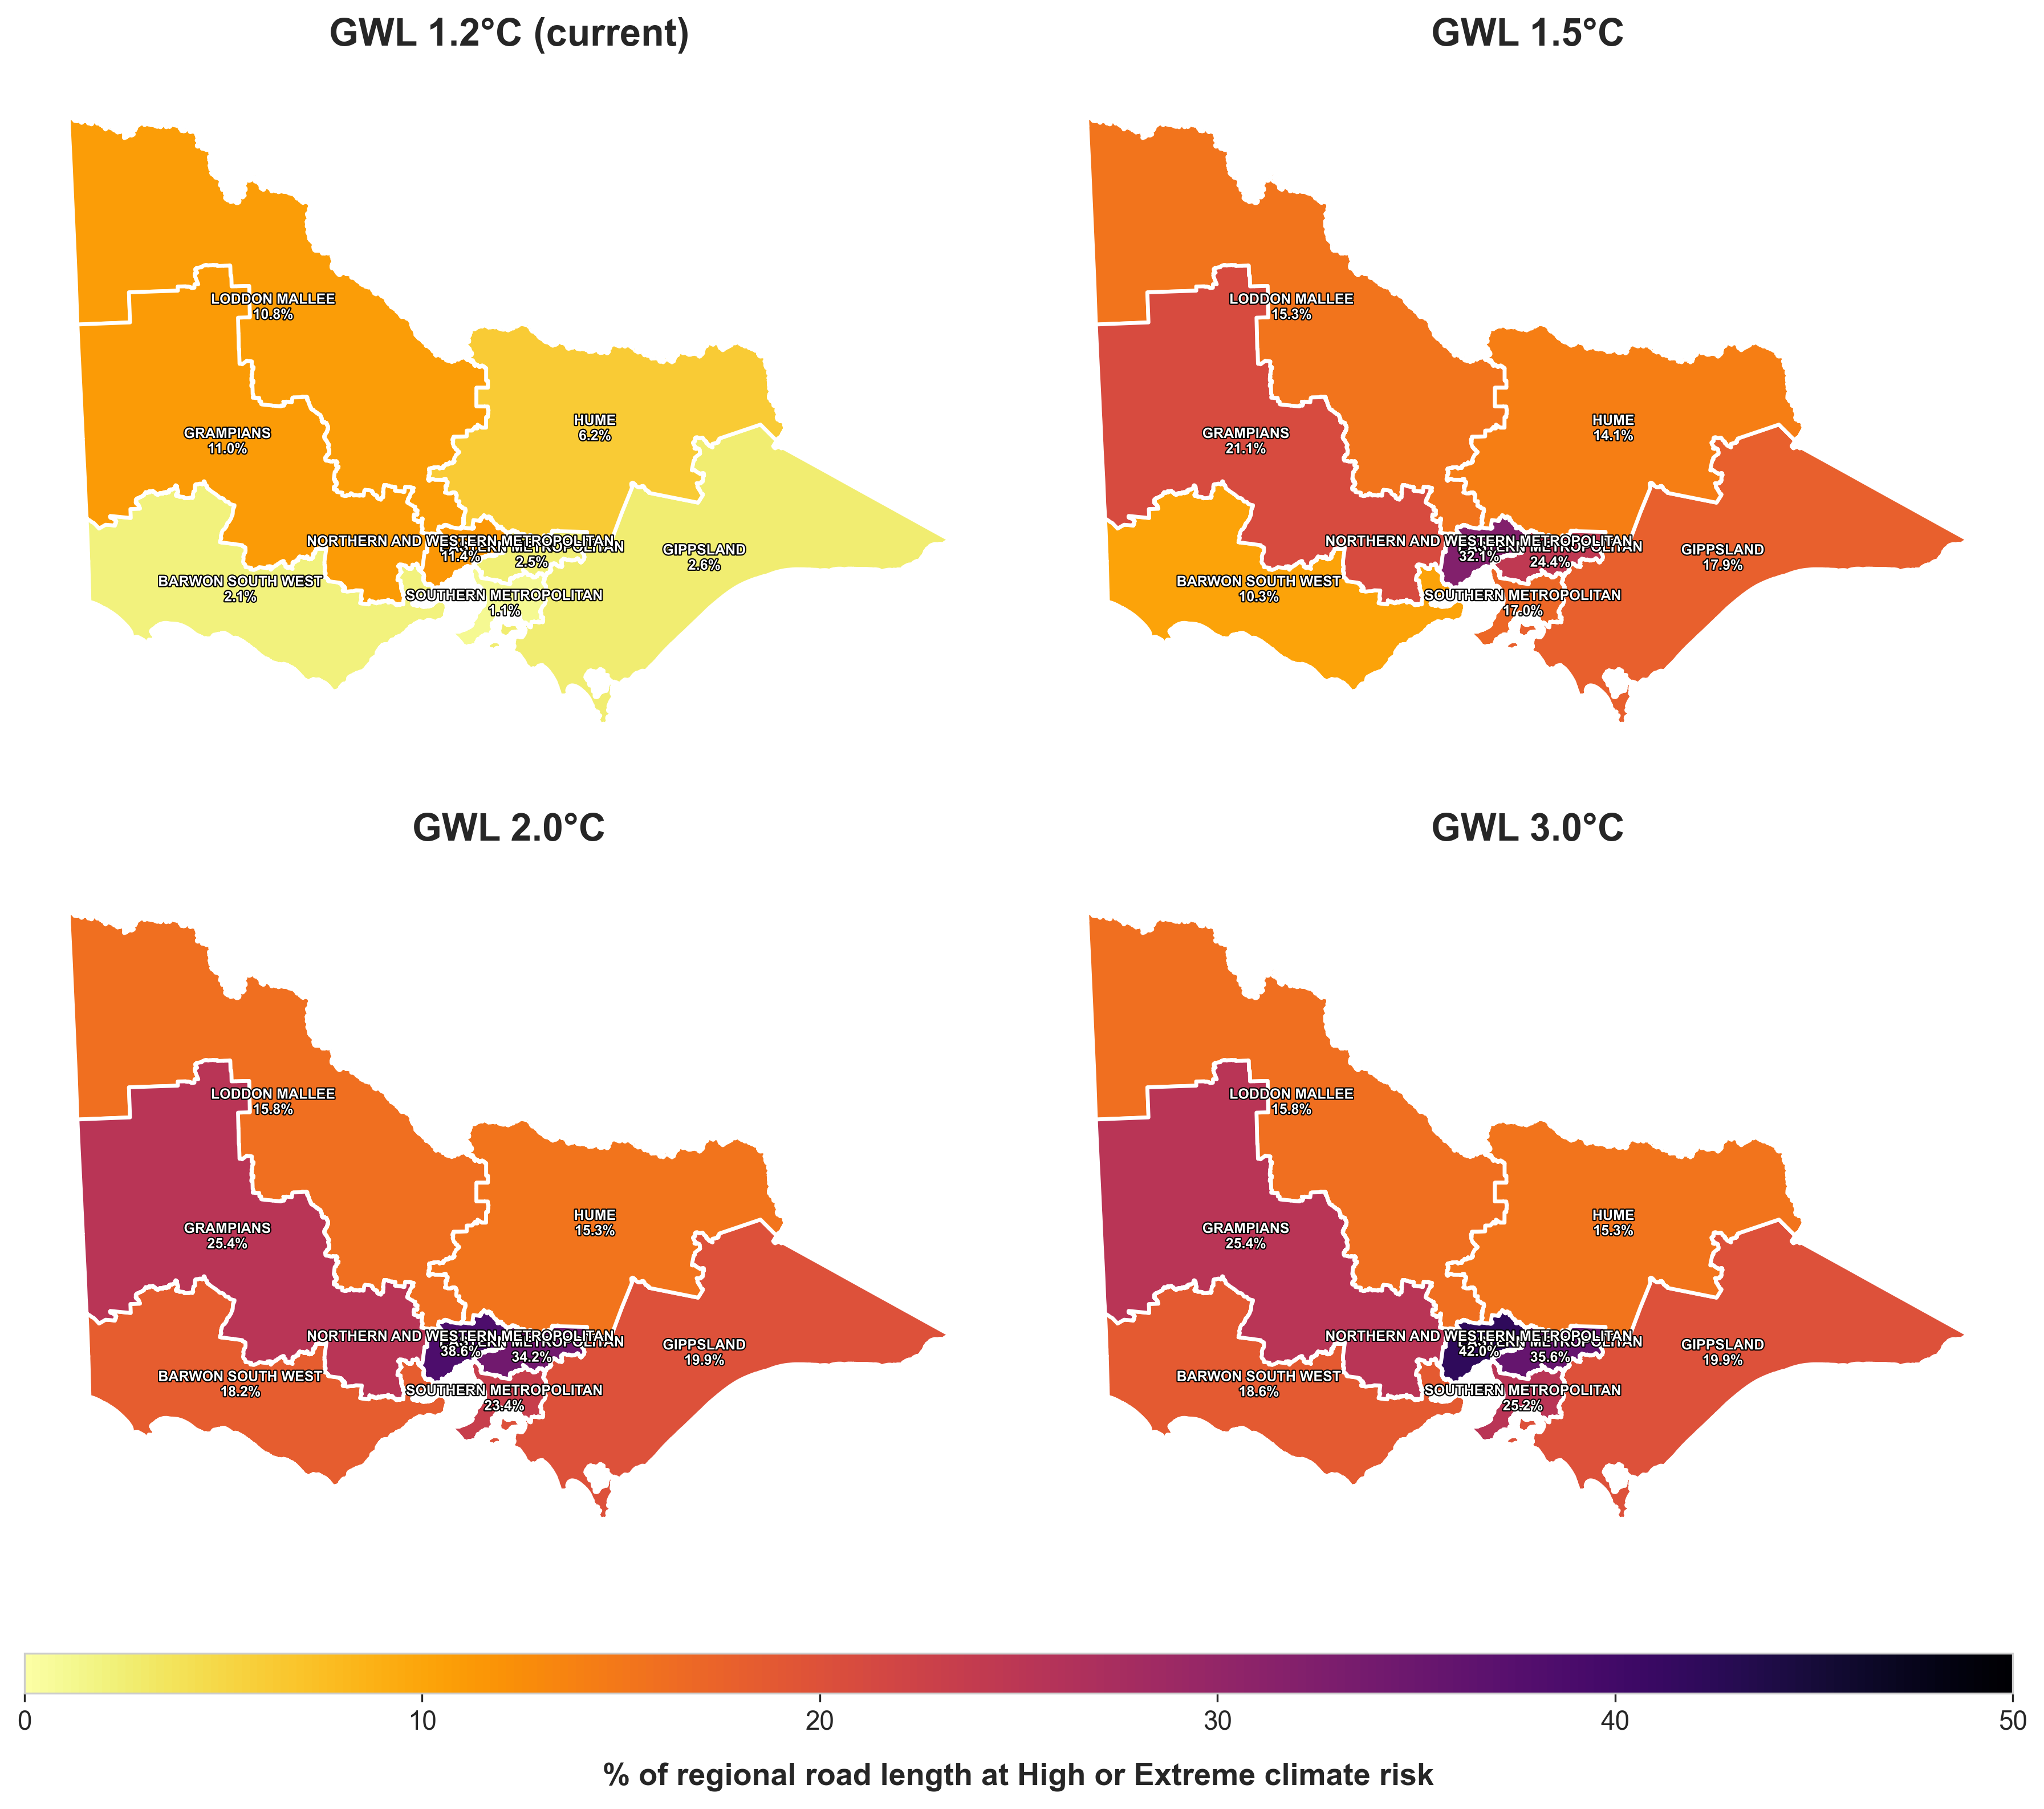


All done! 4 printed summaries + 4 CSVs + 2×2 figure generated.


In [55]:
# # Spatial Join to get VicGov Region Summary
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
import os

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}.geojson")
region_path = os.path.join("../data/raw/VMADMIN", 'VICGOV_REGION.shp')

# Load data
links_gdf = gpd.read_file(data_path)
regions_gdf = gpd.read_file(region_path)
regions_gdf = regions_gdf[regions_gdf['UFI'] != 35828550].copy()
regions_gdf = regions_gdf.to_crs(epsg=3111)

# === SPATIAL JOIN ===
links_with_centroid = links_gdf.copy()
links_with_centroid['centroid'] = links_with_centroid.centroid

joined = gpd.sjoin(
    links_with_centroid.set_geometry('centroid'),
    regions_gdf[['VGREG', 'geometry']],
    how='left',
    predicate='within'
)
joined = joined.set_geometry('geometry').drop(columns='centroid', errors='ignore')

missing_mask = joined['VGREG'].isna()
if missing_mask.sum() > 0:
    print(f"   → {missing_mask.sum()} links missing region → applying nearest fallback")
    missing_gdf = links_gdf.loc[missing_mask].copy()
    nearest = gpd.sjoin_nearest(
        missing_gdf,
        regions_gdf[['VGREG', 'geometry']],
        how='left',
        distance_col='dist_tmp'
    )
    nearest = nearest.sort_values('dist_tmp').groupby(nearest.index).first()
    joined.loc[missing_mask, 'VGREG'] = nearest['VGREG'].reindex(joined.index[missing_mask]).values

print(f"Final missing regions: {joined['VGREG'].isna().sum()} → All assigned!\n")

# === SCENARIOS ===
scenarios = {
    'current': {'label': 'GWL 1.2°C (current)',        'col': 'CR_Level_comp_norm-current'},
    '1.5':     {'label': 'GWL 1.5°C',         'col': 'CR_Level_comp_norm-1.5'},
    '2.0':     {'label': 'GWL 2.0°C',         'col': 'CR_Level_comp_norm-2.0'},
    '3.0':     {'label': 'GWL 3.0°C',         'col': 'CR_Level_comp_norm-3.0'}
}

stats_dict = {}

for key, info in scenarios.items():
    col = info['col']
    if col not in joined.columns:
        print(f"Column {col} not found → skipping {key}")
        continue

    # Flag High/Extreme links
    joined['is_high_ext'] = joined[col].isin(['High', 'Extreme'])

    # Regional aggregation
    stats = (
        joined.groupby('VGREG', as_index=False)
        .agg(
            total_km=('link_length_km', 'sum'),
            high_ext_km=('link_length_km', lambda x: x[joined.loc[x.index, 'is_high_ext']].sum())
        )
    )
    stats['pct_high_ext'] = (stats['high_ext_km'] / stats['total_km'] * 100).round(2)
    stats = stats.sort_values('VGREG', ascending=False).reset_index(drop=True)
    # stats = stats.sort_values('pct_high_ext', ascending=False).reset_index(drop=True)

    # === PRINT SUMMARY  ===
    print(f"=== REGIONAL SUMMARY ({info['label']}) ===")
    print(stats[['VGREG', 'total_km', 'high_ext_km', 'pct_high_ext']].to_string(index=False))
    print("-" * 70)

    # Save CSV
    table_path = os.path.join(output_dir, f"Table_Regional_HighExtreme_Risk_GWL_{key}.csv")
    stats.to_csv(table_path, index=False)

    stats_dict[key] = stats

# === 2×2 MAP FIGURE ===
fig = plt.figure(figsize=(15, 13), dpi=300)
gs = fig.add_gridspec(2, 2, hspace=0.08, wspace=0.05)
vmin, vmax = 0, 50

keys = ['current', '1.5', '2.0', '3.0']

for idx, key in enumerate(keys):
    ax = fig.add_subplot(gs[idx // 2, idx % 2])
    plot_gdf = regions_gdf.merge(stats_dict[key], on='VGREG', how='left')

    plot_gdf.plot(
        column='pct_high_ext',
        cmap='inferno_r',
        linewidth=1.6,
        edgecolor='white',
        ax=ax,
        vmin=vmin, vmax=vmax,
        missing_kwds={'color': 'lightgray'}
    )

    for _, row in plot_gdf.iterrows():
        if pd.notna(row['pct_high_ext']):
            cent = row.geometry.centroid
            ax.text(cent.x, cent.y,
                    f"{row['VGREG']}\n{row['pct_high_ext']:.1f}%",
                    ha='center', va='center', fontsize=6,
                    color='white', fontweight='bold',
                    path_effects=[withStroke(linewidth=1, foreground='black')])

    ax.set_title(scenarios[key]['label'], fontsize=16, pad=15, fontweight='bold')
    ax.set_axis_off()

# Shared colourbar
sm = plt.cm.ScalarMappable(cmap='inferno_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=fig.axes, orientation='horizontal',
                    fraction=0.046, pad=0.06, aspect=50)
cbar.set_label('% of regional road length at High or Extreme climate risk', fontsize=13, labelpad=12)

# plt.suptitle('Evolution of Regional High and Extreme Climate Risk\n'
#              'Victorian Arterial Road Network Across Global Warming Levels',
#              fontsize=20, fontweight='bold', y=0.95)

# Save
output_png = os.path.join(output_dir, "fig_Regional_Risk_Map_2x2_evolution.png")
output_pdf = os.path.join(output_dir, "fig_Regional_Risk_Map_2x2_evolution.pdf")
plt.savefig(output_png, dpi=600, bbox_inches='tight')
# plt.savefig(output_pdf, bbox_inches='tight')
plt.show()

print("\nAll done! 4 printed summaries + 4 CSVs + 2×2 figure generated.")

In [37]:
# --- Generate Top 20 highest-risk road links + Region Summary (current) ---
import json
import pandas as pd
import os

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
data_path = os.path.join(output_dir, f"climate_risk_scores_gwl-all_{run_id}_vgreg.geojson")

# Load GeoJSON
with open(data_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract features into DataFrame
df = pd.DataFrame([{
    'road_link_id': f['properties'].get('road_link_id'),
    'link_length_km': f['properties'].get('link_length_km'),
    'CRS_current': f['properties'].get('CRS-current'),
    'CR_Level_current': f['properties'].get('CR_Level_comp_norm-current'),
    'CR_Level_2p0': f['properties'].get('CR_Level_comp_norm-2.0'),
    'Exposure_current': f['properties'].get('Exposure_sum-current'),
    'VGREG': f['properties'].get('VGREG', 'Unknown'),
} for f in data['features']])

# Total network length
total_km = df['link_length_km'].sum()
print(f"Total assessed road length: {total_km:,.1f} km\n")

# High + Extreme under current climate
high_ext_km_current = df[df['CR_Level_current'].isin(['High', 'Extreme'])]['link_length_km'].sum()
print(f"High + Extreme (current GWL): {high_ext_km_current:.1f} km "
      f"({high_ext_km_current/total_km*100:.2f}% of network)\n")

# Top 20 individual links
print("Top 20 highest-risk road links (current GWL):")
top15 = df.nlargest(20, 'CRS_current')[['road_link_id', 'VGREG', 'CRS_current', 'CR_Level_current', 'link_length_km']]
print(top15.to_string(index=False))
print()

# === REGIONAL SUMMARY – NO WARNINGS (pandas ≥2.1 compatible) ===
df['is_high_ext_current'] = df['CR_Level_current'].isin(['High', 'Extreme'])

# Method 1 – Recommended: use .agg() → fastest and cleanest
regional = (
    df.groupby('VGREG', as_index=False)
    .agg(
        total_km=('link_length_km', 'sum'),
        high_ext_km=('link_length_km', lambda x: x[df.loc[x.index, 'is_high_ext_current']].sum()),
        mean_exposure=('Exposure_current', 'mean'),
        mean_CRS=('CRS_current', 'mean'),
        n_links=('road_link_id', 'count')
    )
)

regional['pct_high_ext'] = (regional['high_ext_km'] / regional['total_km'] * 100).round(2)
regional_sorted = regional.sort_values('pct_high_ext', ascending=False).reset_index(drop=True)

print("Regional ranking – % of road length with High/Extreme risk (current GWL):")
print(regional_sorted[['VGREG', 'total_km', 'high_ext_km', 'pct_high_ext', 'mean_exposure', 'n_links']])

Total assessed road length: 23,116.6 km

High + Extreme (current GWL): 1490.7 km (6.45% of network)

Top 20 highest-risk road links (current GWL):
road_link_id         VGREG  CRS_current CR_Level_current  link_length_km
      3635_1 LODDON MALLEE     0.154654          Extreme        0.484890
     10270_1 LODDON MALLEE     0.145523          Extreme        0.475167
     13417_1          HUME     0.142225          Extreme        0.064669
      2126_1 LODDON MALLEE     0.128829          Extreme        0.031881
     12732_1 LODDON MALLEE     0.128661          Extreme        0.319238
      7810_1          HUME     0.122917          Extreme        0.459907
      4598_1 LODDON MALLEE     0.122632          Extreme        0.416141
      5906_1     GRAMPIANS     0.122073          Extreme        0.029640
     14275_1     GRAMPIANS     0.115444          Extreme        0.125927
      8652_1 LODDON MALLEE     0.113690          Extreme        0.483900
      2909_1 LODDON MALLEE     0.113136          E

In [32]:
# IPCC AR5 Component Contribution Calculator — Aumann–Shapley Method
import pandas as pd
import numpy as np
import os

# ========================= CONFIGURATION =========================
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"

if not os.path.exists(output_dir):
    raise FileNotFoundError(f"Directory not found: {output_dir}")

scenario_ids = ["current", "1.5", "2.0", "3.0"]

print("AR5 Component Contribution Calculator — Aumann–Shapley Method")
print("=" * 70)
print(f"Run ID: {run_id} | Output folder: {outputs_id}")
print(f"Scenarios: {scenario_ids}\n")

# ========================= AUMANN–SHAPLEY FUNCTION =========================
def aumann_shapley_multiplicative(H, E, V, eps=1e-12):
    """
    Exact closed-form Aumann–Shapley allocation for CRS = H × E × V
    Returns: (contrib_Hazard %, contrib_Exposure %, contrib_Vulnerability %)
    """
    H = np.maximum(H, eps)
    E = np.maximum(E, eps)
    V = np.maximum(V, eps)

    # Unnormalised marginal contributions (averaged over all entry orders)
    c_H = (1 + H/(H + E) + (H*E)/(H*E + V)) / 3
    c_E = (1 + E/(E + V) + (E*V)/(E*V + H)) / 3
    c_V = (1 + V/(V + H) + (V*H)/(V*H + E)) / 3

    total = c_H + c_E + c_V
    return (c_H / total) * 100, (c_E / total) * 100, (c_V / total) * 100

# ========================= PROCESS EACH SCENARIO =========================
for scenario_id in scenario_ids:
    print(f"\nProcessing scenario: {scenario_id.upper()}")
    print("-" * 60)

    filename = f"climate_risk_scores_gwl-{scenario_id}_{run_id}.csv"
    crs_path = os.path.join(output_dir, filename)

    if not os.path.exists(crs_path):
        print(f"File NOT found: {filename} → Skipping")
        continue

    print(f"Loading: {filename}")
    df = pd.read_csv(crs_path)

    # Required columns
    req_cols = [
        f'CRS-{scenario_id}',
        f'Hazard_sum-{scenario_id}',
        f'Exposure_sum-{scenario_id}',
        f'Vulnerability_sum-{scenario_id}'   # ← Fixed line
    ]
    missing = [c for c in req_cols if c not in df.columns]
    if missing:
        print(f"Missing columns in {scenario_id}: {missing} → Skipping")
        continue

    # Valid links (CRS > 0) — used only for reporting, not filtering
    mask = df[f'CRS-{scenario_id}'] > 0
    valid_count = mask.sum()
    total_count = len(df)
    print(f"Valid rows (CRS > 0): {valid_count:,} / {total_count:,} ({100*valid_count/total_count:.1f}%)")

    # Extract component arrays
    H = df[f'Hazard_sum-{scenario_id}'].values
    E = df[f'Exposure_sum-{scenario_id}'].values
    V = df[f'Vulnerability_sum-{scenario_id}'].values

    # Compute Aumann–Shapley contributions (vectorised)
    contrib_H, contrib_E, contrib_V = aumann_shapley_multiplicative(H, E, V)

    # Assign to dataframe
    df['Hazard_contrib_pct']       = contrib_H
    df['Exposure_contrib_pct']     = contrib_E
    df['Vulnerability_contrib_pct'] = contrib_V

    # Verification: should be exactly 100.000000%
    df['total_contrib_pct'] = df[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']].sum(axis=1)
    mean_total = df['total_contrib_pct'].mean()
    print(f"Mean total contribution: {mean_total:.6f}%")

    # Summary statistics (only valid links)
    contrib_cols = ['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']
    print("\nAumann–Shapley Contribution Summary (%):")
    print(df.loc[mask, contrib_cols].describe().round(2))

    # Save output
    output_filename = f"climate_risk_scores_with_component_contributions_gwl-{scenario_id}_{run_id}.csv"
    output_path = os.path.join(output_dir, output_filename)
    df.to_csv(output_path, index=False)
    print(f"Saved: {output_filename}")

print("\n" + "="*70)
print("All scenarios processed successfully!")
print("Method: Exact Aumann–Shapley value for multiplicative CRS = H × E × V")
print("Fully consistent with manuscript methodology")

AR5 Component Contribution Calculator — Aumann–Shapley Method
Run ID: model_app | Output folder: out_cra
Scenarios: ['current', '1.5', '2.0', '3.0']


Processing scenario: CURRENT
------------------------------------------------------------
Loading: climate_risk_scores_gwl-current_model_app.csv
Valid rows (CRS > 0): 7,419 / 7,419 (100.0%)
Mean total contribution: 100.000000%

Aumann–Shapley Contribution Summary (%):
       Hazard_contrib_pct  Exposure_contrib_pct  Vulnerability_contrib_pct
count             7419.00               7419.00                    7419.00
mean                32.90                 28.25                      38.85
std                  4.32                  8.53                       5.69
min                 21.69                 17.59                      23.37
25%                 29.95                 20.55                      33.83
50%                 33.76                 25.01                      40.79
75%                 36.37                 38.49        

Generating boxplots for all scenarios...



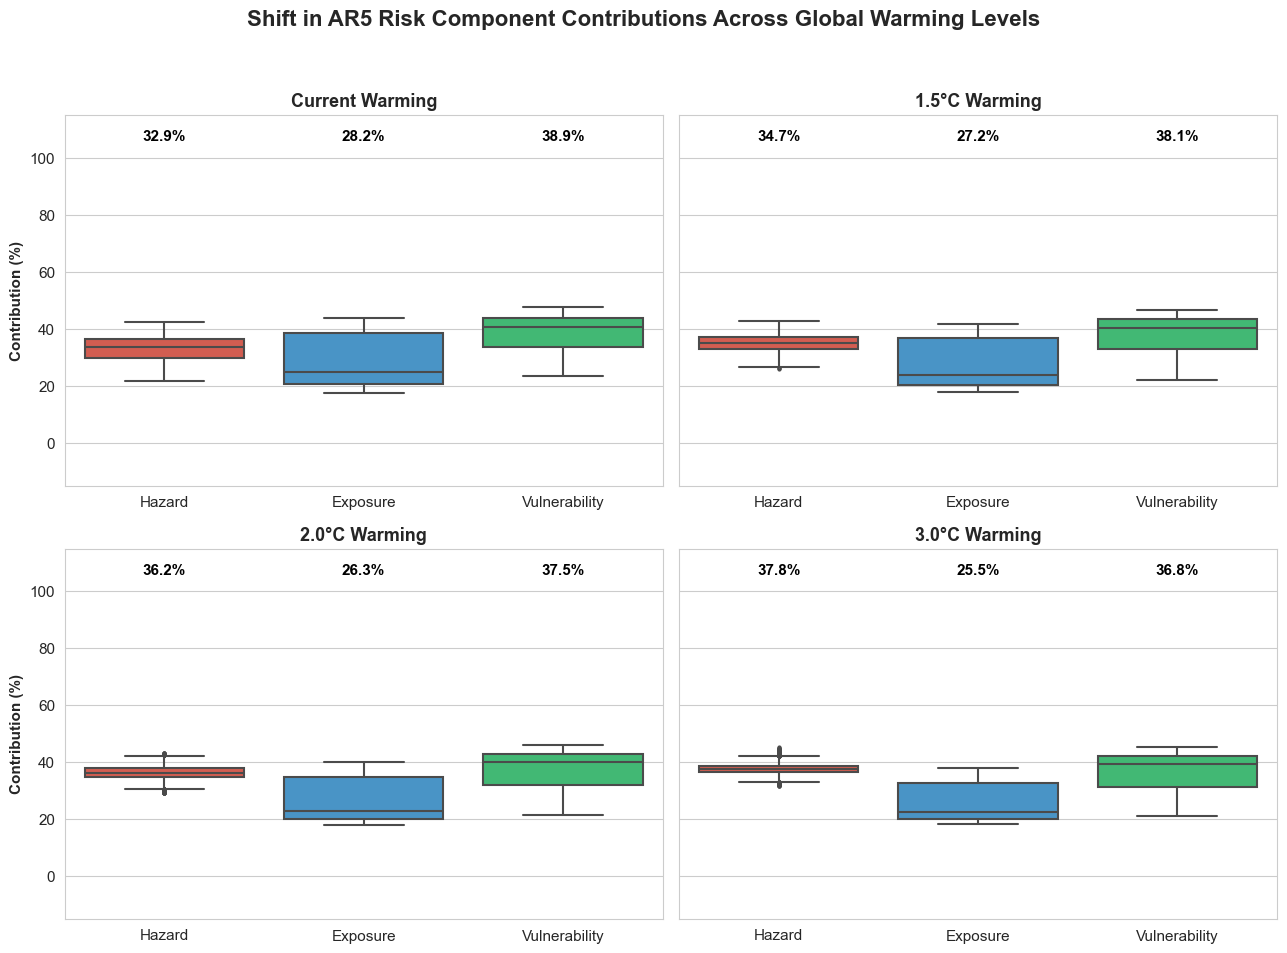


All done! Figures saved to:
../data/processed/model_app/out_cra\figures


In [39]:
# =====================================================================
# AR5 Component Contribution Boxplots - All Scenarios
# =====================================================================
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ========================= CONFIGURATION =========================
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"

scenario_ids = ["current", "1.5", "2.0", "3.0"]
scenario_labels = ["Current", "1.5°C", "2.0°C", "3.0°C"]

fig_dir = os.path.join(output_dir, "figures")
os.makedirs(fig_dir, exist_ok=True)

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 11, 'axes.labelweight': 'bold'})

# Correct palette — must match the FINAL column names after renaming!
palette = ['#e74c3c', '#3498db', '#2ecc71']  # Red, Blue, Green → Hazard, Exposure, Vulnerability

print("Generating boxplots for all scenarios...\n")

# =================================================================
# Combined 4-panel figure
# =================================================================
fig, axes = plt.subplots(2, 2, figsize=(13, 10), sharey=True)
axes = axes.flatten()

for idx, (scenario_id, label) in enumerate(zip(scenario_ids, scenario_labels)):
    file_path = os.path.join(output_dir,
                             f"climate_risk_scores_with_component_contributions_gwl-{scenario_id}_{run_id}.csv")

    if not os.path.exists(file_path):
        print(f"Missing: {file_path}")
        continue

    df = pd.read_csv(file_path)

    # Use correct scenario-specific CRS column
    crs_col = f'CRS-{scenario_id}'
    mask = df[crs_col] > 0

    # Select and rename columns for clean plotting
    data = df.loc[mask, ['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']].copy()
    data.columns = ['Hazard', 'Exposure', 'Vulnerability']  # Critical: rename here

    # Melt for seaborn
    melted = data.melt(var_name='Component', value_name='Contribution (%)')

    # Boxplot
    sns.boxplot(
        ax=axes[idx],
        data=melted,
        x='Component',
        y='Contribution (%)',
        hue='Component',
        palette=palette,        # Now matches ['Hazard', 'Exposure', 'Vulnerability']
        legend=False,
        linewidth=1.5,
        fliersize=2
    )

    axes[idx].set_title(f'{label} Warming', fontweight='bold', fontsize=13)
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Contribution (%)' if idx % 2 == 0 else '')
    axes[idx].set_ylim(-15, 115)

    # Add mean values on top
    means = data.mean().round(1)
    for i, mean_val in enumerate(means):
        axes[idx].text(i, 105, f'{mean_val}%', ha='center', va='bottom',
                       fontweight='bold', fontsize=11, color='black')

# Main title
fig.suptitle('Shift in AR5 Risk Component Contributions Across Global Warming Levels',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(output_dir, "fig_driver_attribution_boxplots_network.png"), dpi=300, bbox_inches='tight')
# plt.savefig(os.path.join(output_dir, "fig_driver_attribution_boxplots_network.pdf"), bbox_inches='tight')
plt.show()
print(f"\nAll done! Figures saved to:\n{fig_dir}")

In [33]:
# DRIVER ATTRIBUTION ACROSS GLOBAL WARMING LEVELS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"

# Master file with VGREG (already contains all links)
vgreg_path = os.path.join(output_dir, "climate_risk_scores_gwl-all_model_app_vgreg.geojson")
gdf = gpd.read_file(vgreg_path)
print(f"Loaded {len(gdf):,} links with VGREG from master file")

# Contribution files for each GWL
contrib_files = {
    'current': "climate_risk_scores_with_component_contributions_gwl-current_model_app.csv",
    '1.5':     "climate_risk_scores_with_component_contributions_gwl-1.5_model_app.csv",
    '2.0':     "climate_risk_scores_with_component_contributions_gwl-2.0_model_app.csv",
    '3.0':     "climate_risk_scores_with_component_contributions_gwl-3.0_model_app.csv",
}

driver_tables = {}

for gwl_label, filename in contrib_files.items():
    path = os.path.join(output_dir, filename)
    if not os.path.exists(path):
        print(f"Missing: {filename}")
        continue

    print(f"Processing {filename} ...")
    contrib = pd.read_csv(path,
                          usecols=['road_link_id',
                                   'Hazard_contrib_pct',
                                   'Exposure_contrib_pct',
                                   'Vulnerability_contrib_pct'])

    # Merge with VGREG
    merged = contrib.merge(gdf[['road_link_id', 'VGREG']], on='road_link_id', how='left')
    missing = merged['VGREG'].isna().sum()
    if missing > 0:
        print(f"   → {missing} links missing VGREG (should be 0)")

    # Regional mean contributions
    summary = (merged.groupby('VGREG')
               .agg({
        'Hazard_contrib_pct': 'mean',
        'Exposure_contrib_pct': 'mean',
        'Vulnerability_contrib_pct': 'mean'
    })
               .round(1)
               .sort_values('Hazard_contrib_pct', ascending=False))

    summary = summary[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']]
    driver_tables[gwl_label] = summary

    # Print clean table
    print("\n" + "="*90)
    print(f"DRIVER ATTRIBUTION AT GWL {gwl_label.upper().replace('CURRENT','≈1.2°C')} ")
    print("="*90)
    print(summary.to_string())
    print("="*90)

    # Save CSV
    summary.to_csv(os.path.join(output_dir, f"Table_Region_Driver_Contributions_GWL_{gwl_label}.csv"))


print("\nAll driver attribution tables generated successfully!")
print("Files saved in:", output_dir)

Loaded 7,419 links with VGREG from master file
Processing climate_risk_scores_with_component_contributions_gwl-current_model_app.csv ...

DRIVER ATTRIBUTION AT GWL ≈1.2°C 
                                   Hazard_contrib_pct  Exposure_contrib_pct  Vulnerability_contrib_pct
VGREG                                                                                                 
HUME                                             36.7                  24.8                       38.5
LODDON MALLEE                                    35.7                  25.3                       39.0
GRAMPIANS                                        35.4                  25.9                       38.7
GIPPSLAND                                        35.1                  26.3                       38.6
BARWON SOUTH WEST                                33.4                  27.0                       39.6
SOUTHERN METROPOLITAN                            31.5                  28.8                       39.7
EAST

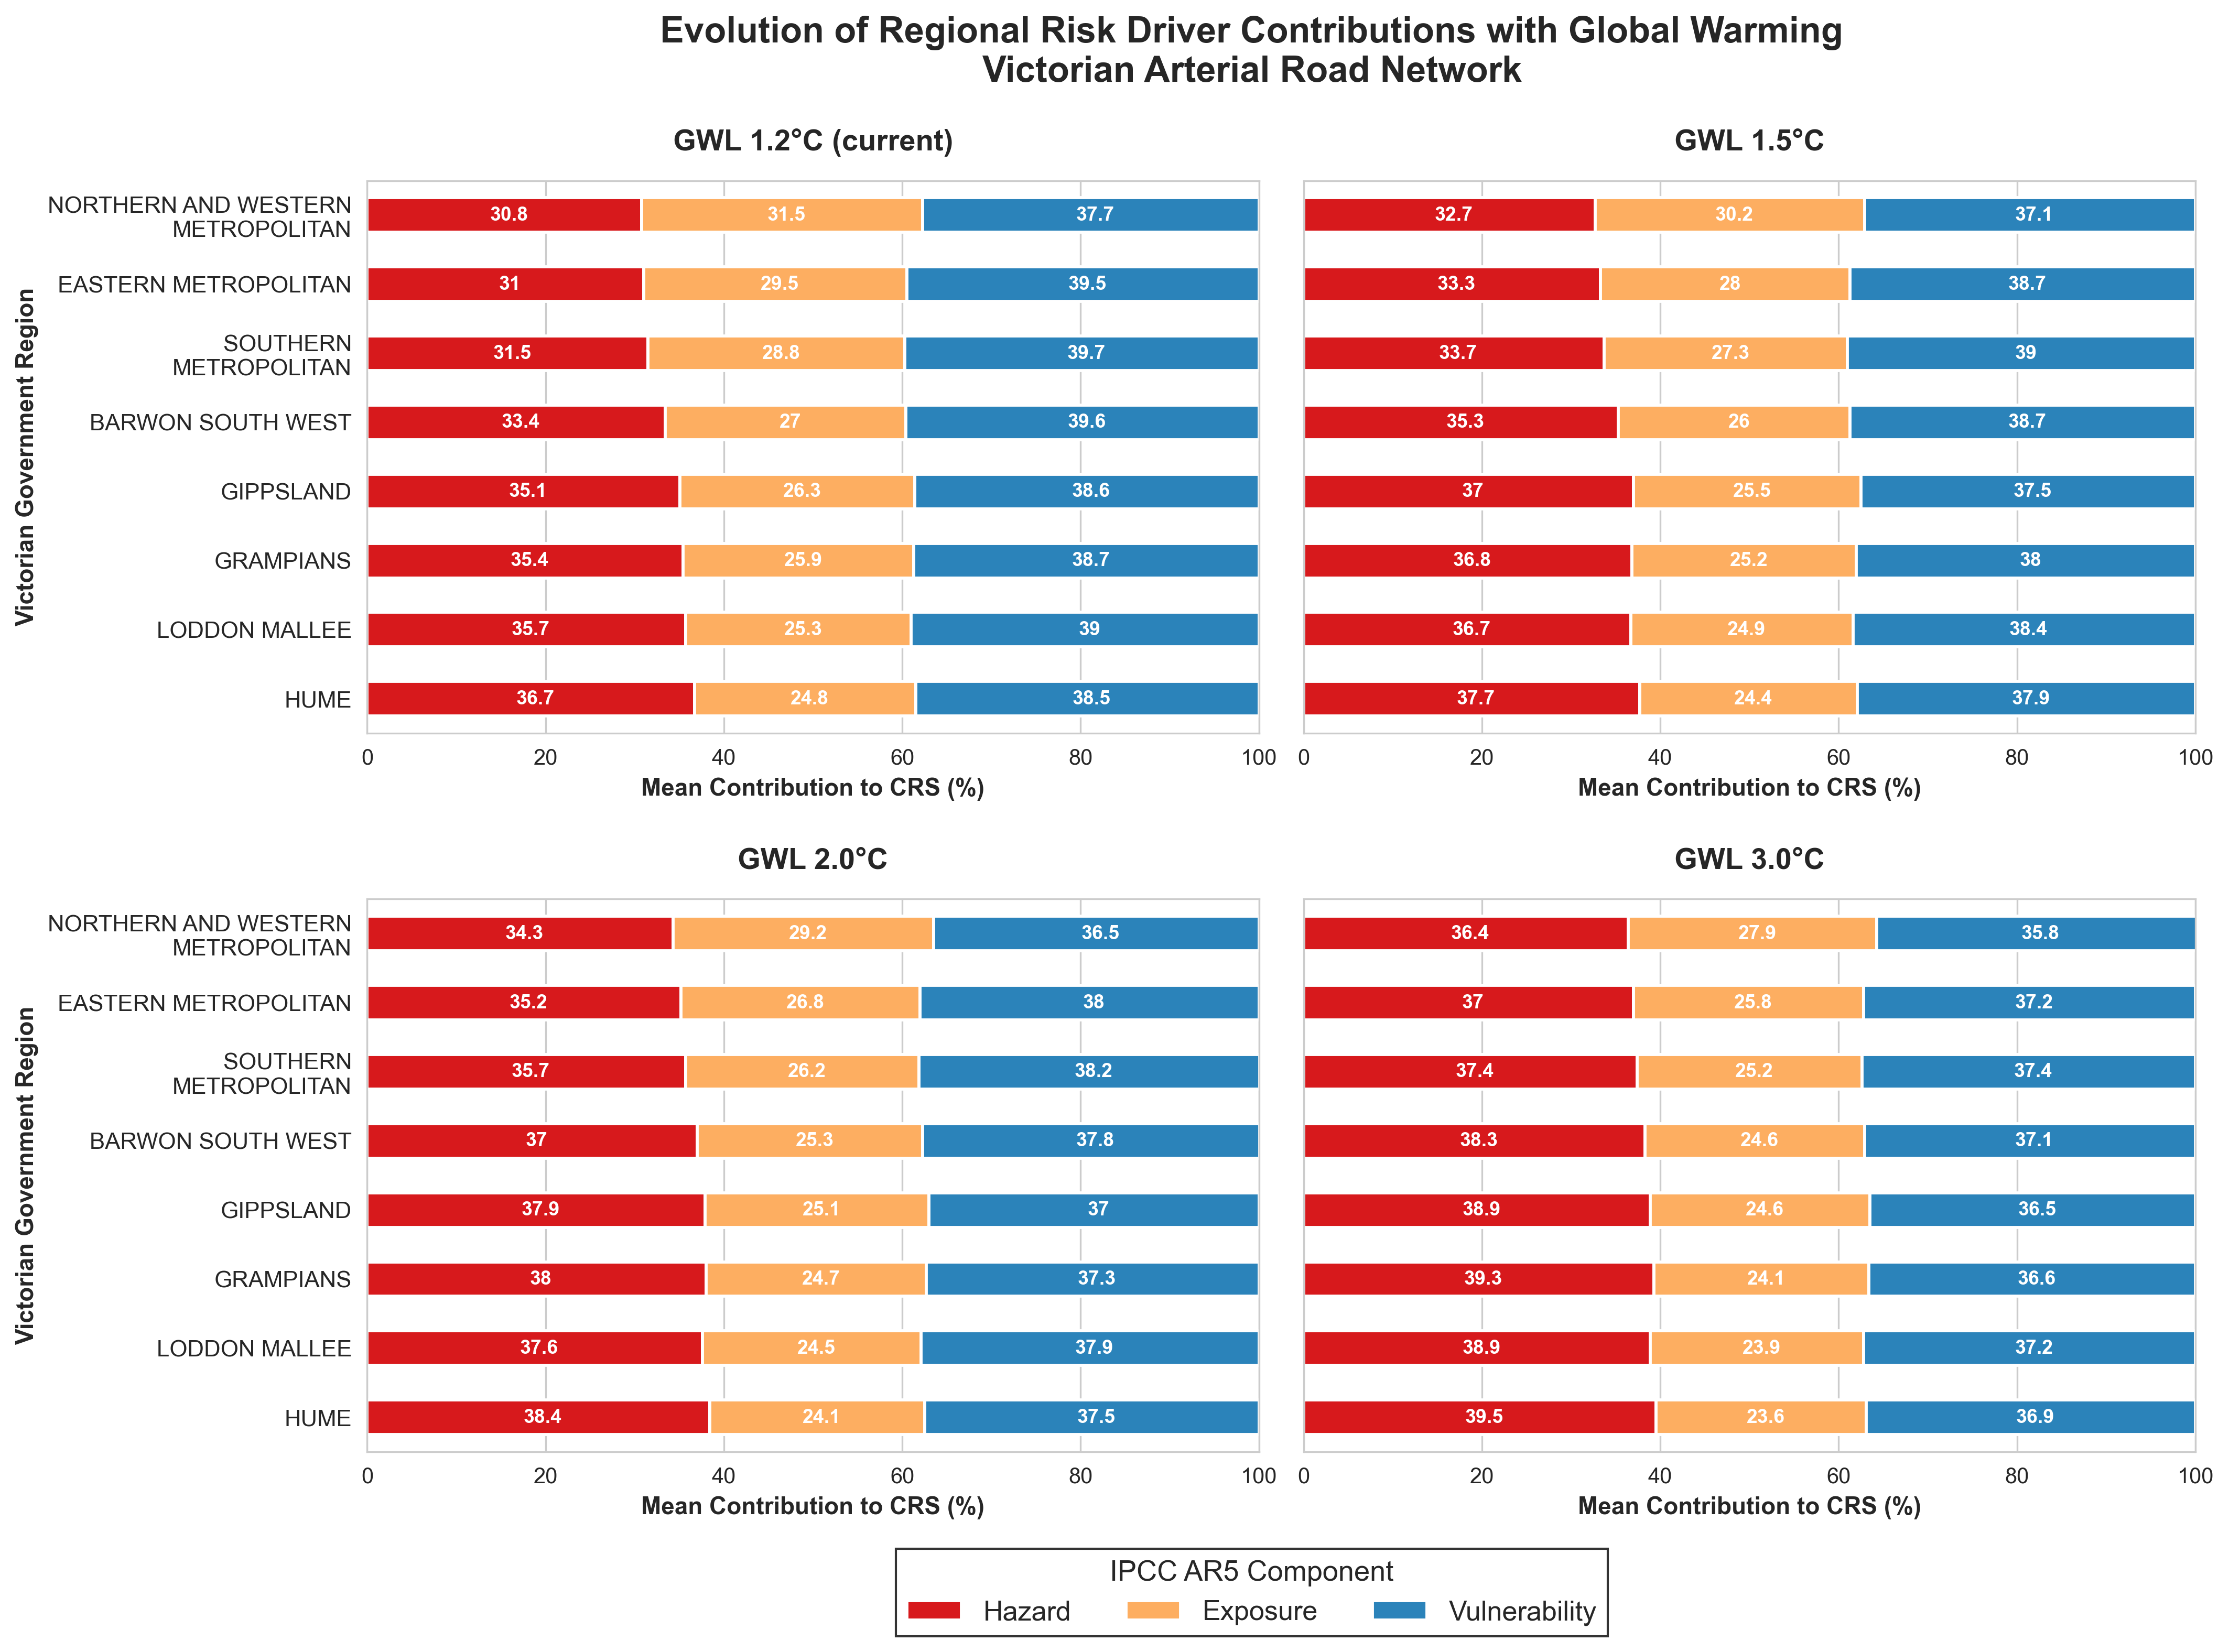

[2025-11-23 13:40:38.749728] 2×2 driver evolution figure saved.


In [14]:
# 2×2 DRIVER EVOLUTION FIGURE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import textwrap

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
vgreg_path = os.path.join(output_dir, "climate_risk_scores_gwl-all_model_app_vgreg.geojson")
gdf = gpd.read_file(vgreg_path)

# Contribution files
contrib_files = {
    'current': "climate_risk_scores_with_component_contributions_gwl-current_model_app.csv",
    '1.5':     "climate_risk_scores_with_component_contributions_gwl-1.5_model_app.csv",
    '2.0':     "climate_risk_scores_with_component_contributions_gwl-2.0_model_app.csv",
    '3.0':     "climate_risk_scores_with_component_contributions_gwl-3.0_model_app.csv",
}

titles = {
    'current': 'GWL 1.2°C (current)',
    '1.5':     'GWL 1.5°C',
    '2.0':     'GWL 2.0°C',
    '3.0':     'GWL 3.0°C',
}

# Prepare summaries
summaries = {}
region_order = None  # Will be set from first (current) panel

for label, filename in contrib_files.items():
    path = os.path.join(output_dir, filename)
    if not os.path.exists(path):
        print(f"Missing: {filename}")
        continue

    contrib = pd.read_csv(path, usecols=['road_link_id','Hazard_contrib_pct','Exposure_contrib_pct','Vulnerability_contrib_pct'])
    merged = contrib.merge(gdf[['road_link_id','VGREG']], on='road_link_id', how='left')

    summary = (merged.groupby('VGREG')
    .mean(numeric_only=True)
    .round(1)[['Hazard_contrib_pct', 'Exposure_contrib_pct', 'Vulnerability_contrib_pct']])

    # Use consistent region order (from current conditions)
    if label == 'current':
        region_order = summary.sort_values('Hazard_contrib_pct', ascending=False).index
    summary = summary.loc[region_order]

    summaries[label] = summary

# === 2×2 PLOT WITH SHARED Y-AXIS & WRAPPED LABELS ===
sns.set_style("whitegrid")
fig = plt.figure(figsize=(15, 10.5), dpi=300)

gs = fig.add_gridspec(2, 2, hspace=0.30, wspace=0.05)  # tight wspace for shared y-axis

colors = ['#d7191c', '#fdae61', '#2b83ba']  # Hazard, Exposure, Vulnerability
handles = None

for idx, (label, summary) in enumerate(summaries.items()):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])

    summary.plot(kind='barh', stacked=True, ax=ax, color=colors,
                 edgecolor='white', linewidth=1.4, legend=False)

    ax.set_xlim(0, 100)
    ax.set_title(titles[label], fontsize=13.5, fontweight='bold', pad=14)
    ax.set_xlabel('Mean Contribution to CRS (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Victorian Government Region', fontsize=11, fontweight='bold')

    # === Y-axis: only show on left column (shared) ===
    if col == 0:
        # Wrap long region names to two lines
        wrapped_labels = [ '\n'.join(textwrap.wrap(reg, width=20)) for reg in summary.index ]
        ax.set_yticklabels(wrapped_labels, fontsize=10.5)
    else:
        ax.set_yticks([])  # hide y-tick labels on right
        ax.set_ylabel('')

    # Percentage labels inside bars
    for container in ax.containers:
        ax.bar_label(container, label_type='center', fontsize=9, color='white', fontweight='bold', padding=2)

    if handles is None:
        handles = ax.containers

# === Shared horizontal legend at bottom ===
fig.legend(handles, ['Hazard', 'Exposure', 'Vulnerability'],
           title='IPCC AR5 Component', loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.01), fontsize=12.5, title_fontsize=13, frameon=True, fancybox=False, edgecolor='black')

plt.suptitle('Evolution of Regional Risk Driver Contributions with Global Warming\nVictorian Arterial Road Network',
             fontsize=16.5, fontweight='bold', y=0.98)

# Save
plt.savefig(os.path.join(output_dir, "fig_driver_attribution_regions.png"),
            dpi=600, bbox_inches='tight')
# plt.savefig(os.path.join(output_dir, "fig_driver_attribution_regions.pdf"),
#             bbox_inches='tight')
plt.show()

from datetime import datetime
print(f"[{datetime.now()}] 2×2 driver evolution figure saved.")


## Climate Projections

Loading master GeoJSON...

ESCALATION OF HIGH/EXTREME RISK LENGTH WITH GLOBAL WARMING
     GWL (°C)  Total Network (km)  High/Extreme (km)  % High/Extreme
1.2 (current)             23116.6             1490.7            6.45
          1.5             23116.6             4016.5           17.38
          2.0             23116.6             4952.9           21.43
          3.0             23116.6             5072.7           21.94


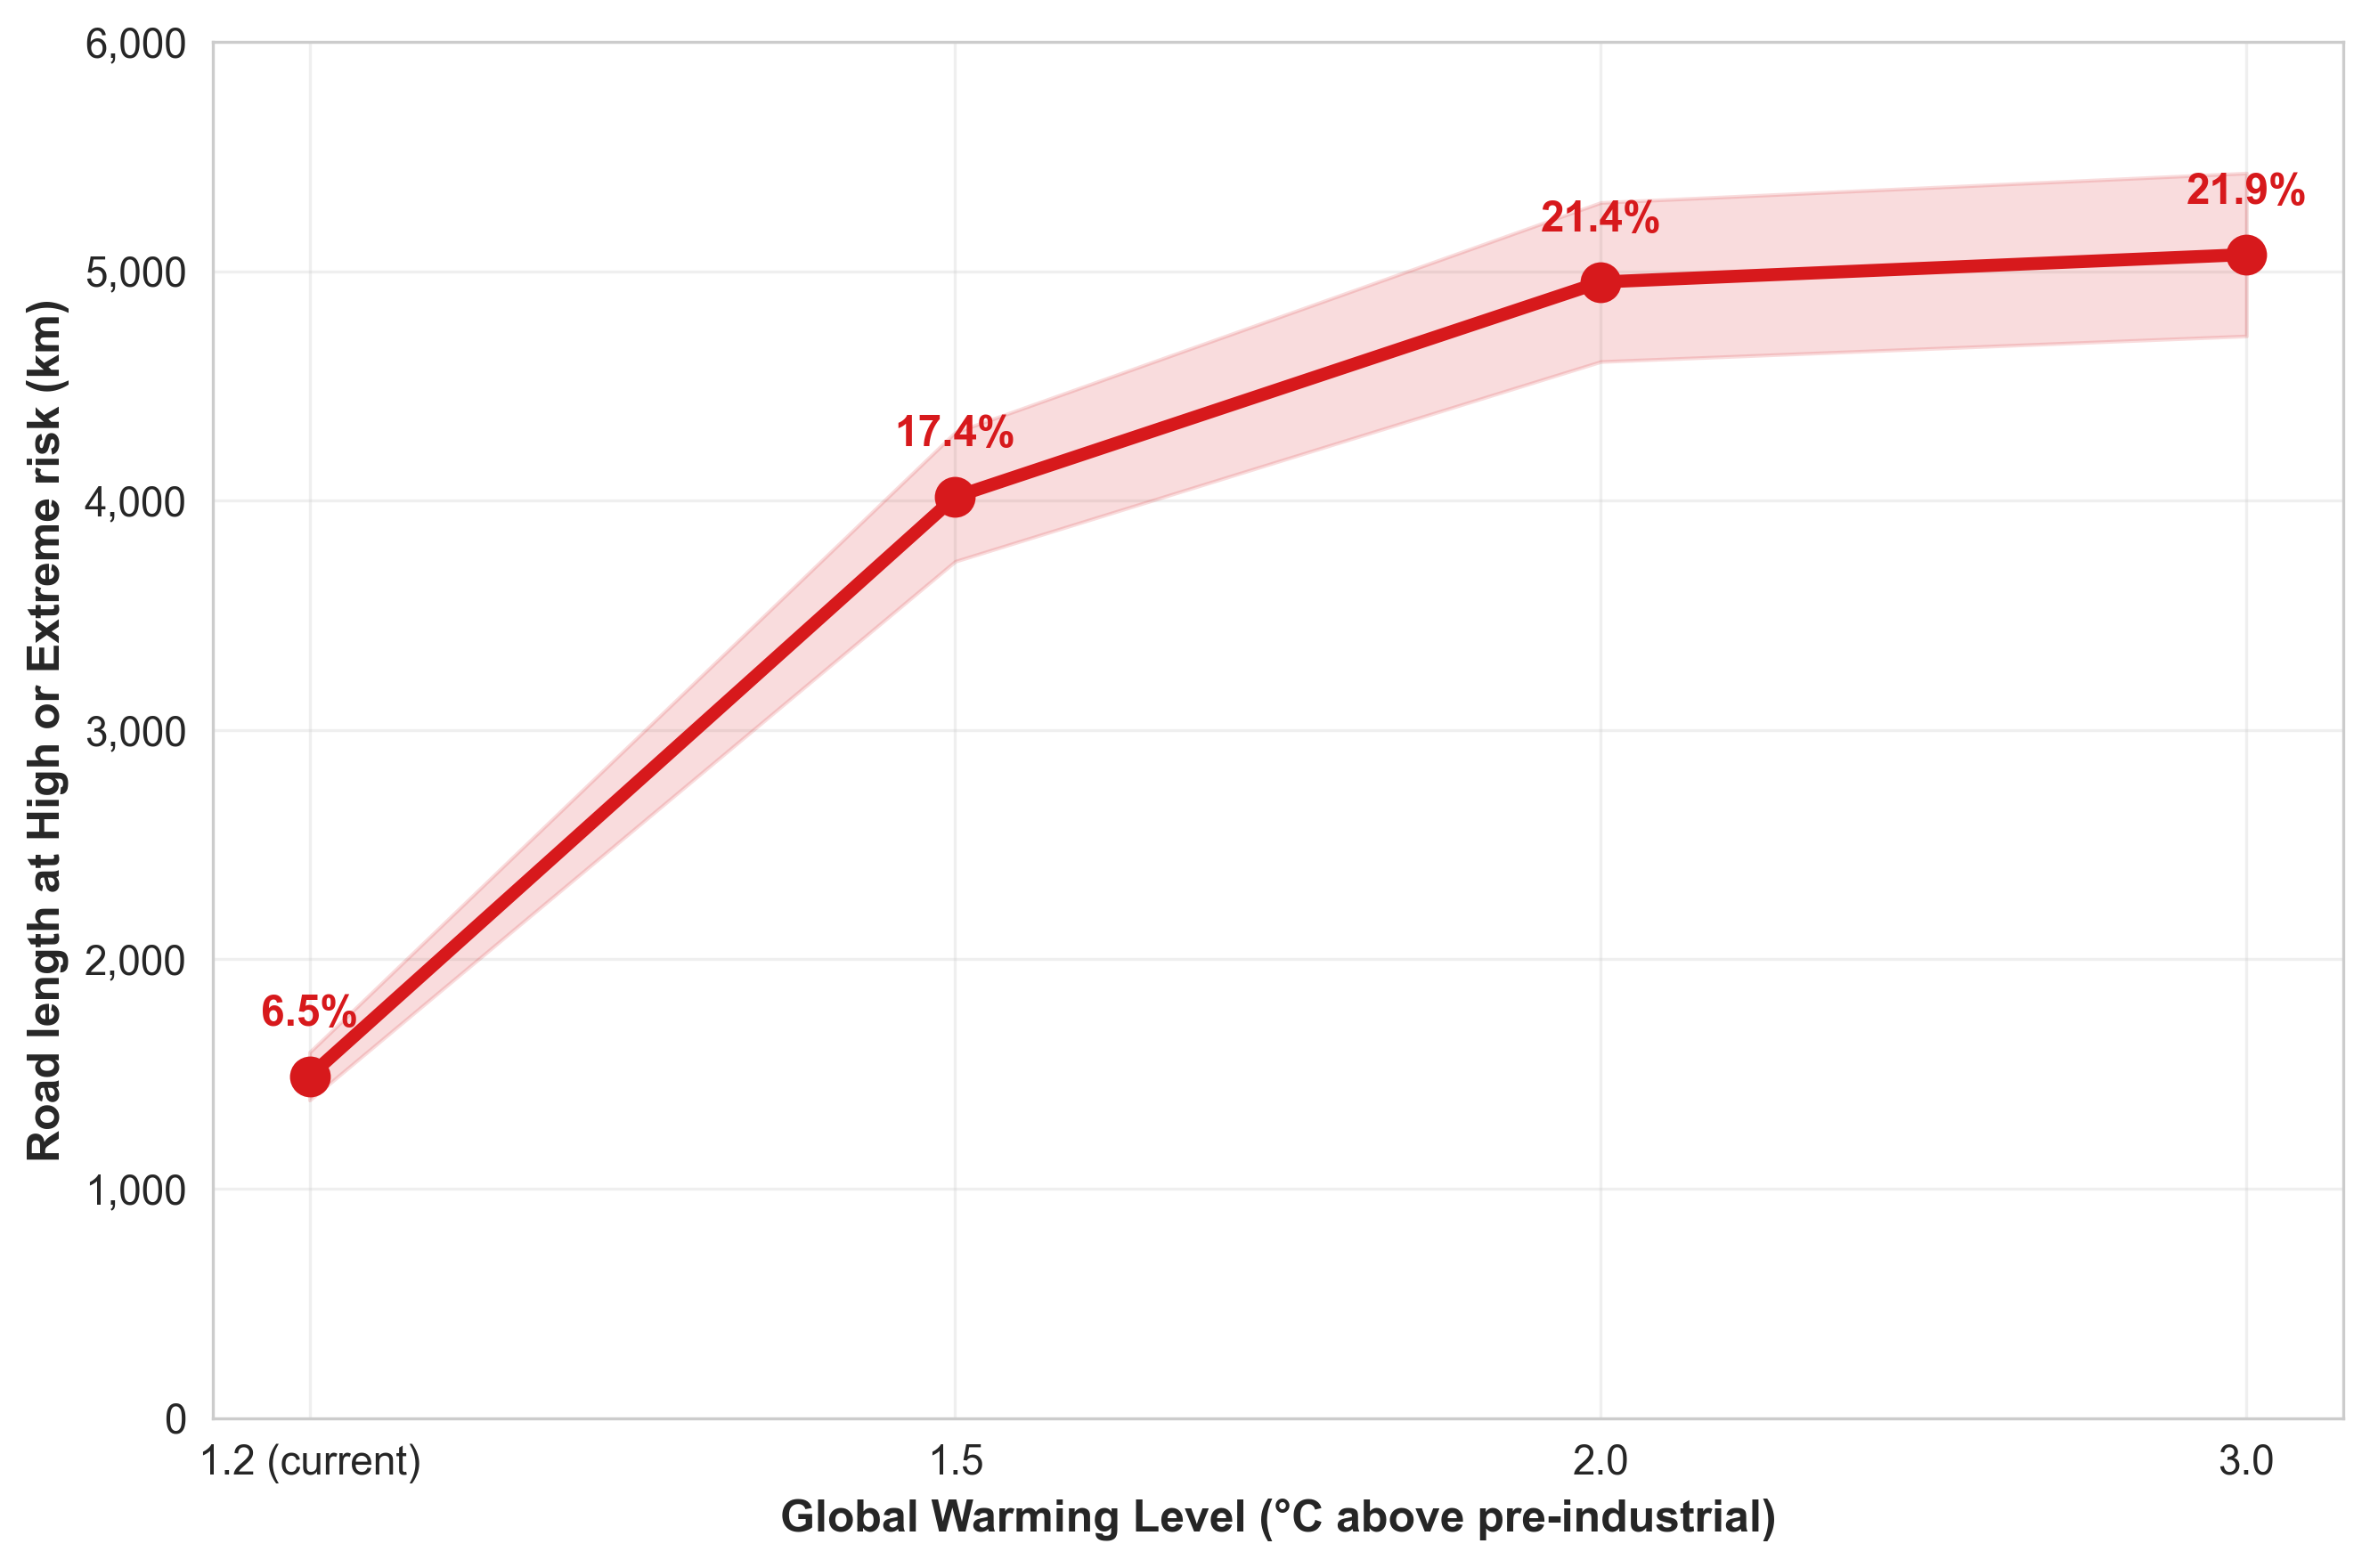

Figure saved with y-axis in kilometres and annotations in %:
→ fig_risk_escalation_trajectory_km.png / .pdf


In [44]:
# PROJECTED RISK ESCALATION
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuration ---
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"
filepath = os.path.join(output_dir, "climate_risk_scores_gwl-all_model_app_vgreg.geojson")

# Load the master file
print("Loading master GeoJSON...")
gdf = gpd.read_file(filepath)

# Define warming levels and corresponding CR_Level column names
gwl_config = {
    '1.2 (current)': 'CR_Level_comp_norm-current',
    '1.5': 'CR_Level_comp_norm-1.5',
    '2.0': 'CR_Level_comp_norm-2.0',
    '3.0': 'CR_Level_comp_norm-3.0'
}

# === ESCALATION OF HIGH/EXTREME RISK LENGTH ===
print("\n" + "="*90)
print("ESCALATION OF HIGH/EXTREME RISK LENGTH WITH GLOBAL WARMING")
print("="*90)

escalation_results = []

for gwl_str, level_col in gwl_config.items():
    if level_col not in gdf.columns:
        print(f"Warning: {level_col} not found!")
        continue

    total_km = gdf['link_length_km'].sum()
    high_ext_km = gdf[gdf[level_col].isin(['High', 'Extreme'])]['link_length_km'].sum()
    pct = high_ext_km / total_km * 100

    escalation_results.append({
        'GWL (°C)': gwl_str,
        'Total Network (km)': round(total_km, 1),
        'High/Extreme (km)': round(high_ext_km, 1),
        '% High/Extreme': round(pct, 2)
    })

escalation_df = pd.DataFrame(escalation_results)
print(escalation_df.to_string(index=False))
print("="*90)

# Save table
escalation_df.to_csv(os.path.join(output_dir, "Table_Risk_Escalation_by_GWL.csv"), index=False)

# === PLOT: Y-AXIS IN KM, LABELS SHOW % ===
plt.figure(figsize=(9, 6), dpi=300)
sns.set_style("whitegrid")

# Plot absolute km
plt.plot(escalation_df['GWL (°C)'], escalation_df['High/Extreme (km)'],
         marker='o', linewidth=3.5, markersize=10, color='#d7191c', zorder=5)

# Shaded band (±7% of the percentage value, converted back to km)
lower_km = escalation_df['High/Extreme (km)'] * 0.93
upper_km = escalation_df['High/Extreme (km)'] * 1.07
plt.fill_between(escalation_df['GWL (°C)'], lower_km, upper_km,
                 color='#d7191c', alpha=0.15, label='±7% indicative spread')

# Label x- and y-axis
plt.ylabel('Road length at High or Extreme risk (km)', fontsize=12)
plt.xlabel('Global Warming Level (°C above pre-industrial)', fontsize=12)

# Format y-axis
import matplotlib.ticker as mticker
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 6000)
plt.grid(True, alpha=0.3)

# Annotations: still show percentage
for _, row in escalation_df.iterrows():
    plt.text(row['GWL (°C)'], row['High/Extreme (km)'] + 220,
             f"{row['% High/Extreme']:.1f}%",
             ha='center', fontsize=11.5, fontweight='bold', color='#d7191c')

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save
output_png = os.path.join(output_dir, "fig_risk_escalation_trajectory.png")
output_pdf = os.path.join(output_dir, "fig_risk_escalation_trajectory.pdf")
plt.savefig(output_png, dpi=600, bbox_inches='tight')
# plt.savefig(output_pdf, bbox_inches='tight')
plt.show()

print("Figure saved with y-axis in kilometres and annotations in %:")
print("→ fig_risk_escalation_trajectory_km.png / .pdf")


# SENSITIVITY TEST - Traffic Growth

In [15]:
# COMPUTE CLIMATE RISK WITH TRAFFIC GROWTH SENSITIVITY TEST
# ONLY CHANGE: ALLVEHS_AA and TRUCKS_AAD are scaled by growth factor

import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime
from loguru import logger

# ============================================================
# 1. Normalisation factors (unchanged – from "current" scenario)
# ============================================================
run_id_dev = "model_dev"
outputs_id_dev = "out_crisks"
scenario_id_dev = "current"
data_path = f"../data/processed/{run_id_dev}/{outputs_id_dev}/climate_risk_scores_gwl-{scenario_id_dev}_{run_id_dev}.csv"
gdf = gpd.read_file(data_path)

outlier_condition = (gdf['road_link_id'] == "5093_1")
gdf_filtered = gdf[~outlier_condition].copy()
cols = ["Hazard_sum-current", "Exposure_sum-current", "Vulnerability_sum-current"]
gdf_filtered[cols] = gdf_filtered[cols].astype(float)

max_hazard = gdf_filtered["Hazard_sum-current"].max()
max_exposure = gdf_filtered["Exposure_sum-current"].max()
max_vulnerability = gdf_filtered["Vulnerability_sum-current"].max()

hazard_norm_fac = 1.0 / max_hazard
exposure_norm_fac = 1.0 / max_exposure
vulnerability_norm_fac = 1.0 / max_vulnerability

print("# CR Component Normalisation Factors")
print(f"hazard_norm_fac = {hazard_norm_fac:.10f}")
print(f"exposure_norm_fac = {exposure_norm_fac:.10f}")
print(f"vulnerability_norm_fac = {vulnerability_norm_fac:.10f}\n")

# =================
# 2. Configuration
# =================
run_id = "model_app"
outputs_id = "out_cra_st"           # sensitivity test folder
output_dir = f"../data/processed/{run_id}/{outputs_id}"
os.makedirs(output_dir, exist_ok=True)

# scenario_id = "current"                 # ← CHANGE THIS: "current", "1.5", "2.0", or "3.0"
# scenario_id = "1.5"                 # ← CHANGE THIS: "current", "1.5", "2.0", or "3.0"
# scenario_id = "2.0"                 # ← CHANGE THIS: "current", "1.5", "2.0", or "3.0"
scenario_id = "3.0"                 # ← CHANGE THIS: "current", "1.5", "2.0", or "3.0"

# Traffic growth factors
growth_factor = {
    "current": 1.0,
    "1.5":     1.6,   # +60% by ~2050
    "2.0":     2.0,   # +100% by ~2070
    "3.0":     2.4    # +140% by ~2090
}[scenario_id]

print(f"TRAFFIC GROWTH SENSITIVITY TEST – GWL {scenario_id.upper()}")
print(f"Applying growth factor {growth_factor:.1f} × to ALLVEHS_AA and TRUCKS_AAD\n")

# Paths (unchanged)
path_cra_calc     = f"../data/processed/{run_id_dev}/gdf_road_clim_cln_final_cra_calc.geojson"
path_shap_weights = f"../data/processed/{run_id_dev}/shap_weights_{run_id_dev}.json"
path_norm_params  = f"../data/processed/{run_id_dev}/normalization_params_{run_id_dev}.json"
matrix_path       = f"../data/processed/{run_id}/climate_risk_matrix_input_5h5e5v_4cat.csv"

# ============================================================
# 3. Load main dataset and APPLY TRAFFIC GROWTH IMMEDIATELY
# ============================================================
gdf = gpd.read_file(path_cra_calc)

# Scale traffic exposure right at the start
gdf["ALLVEHS_AA"] = gdf["ALLVEHS_AA"] * growth_factor
gdf["TRUCKS_AAD"] = gdf["TRUCKS_AAD"] * growth_factor
print(f"Applied {growth_factor:.1f}× growth → ALLVEHS_AA and TRUCKS_AAD updated")

# ============================================================
# 4. Everything below is 100% identical to your original code
# ============================================================
# validate_performance = (scenario_id == "current")   # only validate on current

# Load supporting files
with open(path_shap_weights, "r") as f:
    shap_weights = json.load(f)["Mean_Abs_SHAP"]
with open(path_norm_params, "r") as f:
    normalization_params = json.load(f)

# SHAP weights (unchanged)
SHAP_WEIGHTS = {
    "Hazard": ["Thermal_Diff-current", "tx40_gwl-current", "spi3_gwl-current", "tn02_gwl-current", "rx5d_gwl-current"],
    "Exposure": ["ALLVEHS_AA", "HATI_Categ_Code", "TRUCKS_AAD"],
    "Vulnerability": ["SEAL_WIDTH", "Surface_Ty_Code", "RMA_CLSFCN_Code", "Texture__L_Code"]
}

# Risk level functions (unchanged)
def map_crs_level(score):
    if score < 0.05:  return "Category 1"
    elif score <= 0.10: return "Category 2"
    elif score <= 0.15: return "Category 3"
    else: return "Category 4"

def map_hazard_exposure_level_norm(score):
    if score < 0.2: return "Very Unlikely"
    elif score <= 0.4: return "Unlikely"
    elif score <= 0.6: return "Possible"
    elif score <= 0.8: return "Likely"
    else: return "Almost Certain"

def map_vulnerability_level_norm(score):
    if score < 0.2: return "Insignificant"
    elif score <= 0.4: return "Minor"
    elif score <= 0.6: return "Moderate"
    elif score <= 0.8: return "Major"
    else: return "Catastrophic"

print(f"[{datetime.now()}] ---- Computing Climate Risk Scores (GWL-{scenario_id}) ----")

# Validate required columns
required_cols = ["road_link_id"] + [f.replace("current", scenario_id) for sublist in SHAP_WEIGHTS.values() for f in sublist]
missing_cols = [c for c in required_cols if c not in gdf.columns]
if missing_cols:
    raise ValueError(f"Missing columns: {missing_cols}")

df = gdf[required_cols].copy()
base_features = [item for sublist in SHAP_WEIGHTS.values() for item in sublist]

for feature in base_features:
    base_name = feature
    scenario_name = feature.replace("current", scenario_id)
    df[f"{base_name}_shap"] = shap_weights.get(base_name, 0)
    df[f"{base_name}_min"]  = normalization_params[base_name]["min"]
    df[f"{base_name}_max"]  = normalization_params[base_name]["max"]
    df[scenario_name] = df[scenario_name]   # ensures column exists

# Normalise and compute contributions
for comp, features in SHAP_WEIGHTS.items():
    for feature in features:
        base_name = feature
        scenario_name = feature.replace("current", scenario_id)
        df[f"{base_name}_norm"] = (df[scenario_name] - df[f"{base_name}_min"]) / (df[f"{base_name}_max"] - df[f"{base_name}_min"])
        df[f"{base_name}_contrib"] = df[f"{base_name}_shap"] * df[f"{base_name}_norm"]
    df[f"{comp}_sum-{scenario_id}"] = df[[f"{f}_contrib" for f in features]].sum(axis=1)

# Component normalisation and CRS
df[f"Hazard_sum_norm-{scenario_id}"]       = df[f"Hazard_sum-{scenario_id}"]       * hazard_norm_fac
df[f"Exposure_sum_norm-{scenario_id}"]     = df[f"Exposure_sum-{scenario_id}"]     * exposure_norm_fac
df[f"Vulnerability_sum_norm-{scenario_id}"] = df[f"Vulnerability_sum-{scenario_id}"] * vulnerability_norm_fac

df[f"CRS-{scenario_id}"] = df[f"Hazard_sum-{scenario_id}"] * df[f"Exposure_sum-{scenario_id}"] * df[f"Vulnerability_sum-{scenario_id}"]
df[f"CRS_Level-{scenario_id}"] = df[f"CRS-{scenario_id}"].apply(map_crs_level)

df[f"Hazard_sum_norm_Level-{scenario_id}"]       = df[f"Hazard_sum_norm-{scenario_id}"].apply(map_hazard_exposure_level_norm)
df[f"Exposure_sum_norm_Level-{scenario_id}"]     = df[f"Exposure_sum_norm-{scenario_id}"].apply(map_hazard_exposure_level_norm)
df[f"Vulnerability_sum_norm_Level-{scenario_id}"] = df[f"Vulnerability_sum_norm-{scenario_id}"].apply(map_vulnerability_level_norm)

# 5×5×5 risk matrix
matrix_df = pd.read_csv(matrix_path)
risk_matrix = {(row["Hazard_Level"], row["Exposure_Level"], row["Vulnerability_Level"]): row["Climate_Risk_Level"]
               for _, row in matrix_df.iterrows()}

def map_climate_risk_from_matrix_norm(row):
    h = row[f"Hazard_sum_norm_Level-{scenario_id}"]
    e = row[f"Exposure_sum_norm_Level-{scenario_id}"]
    v = row[f"Vulnerability_sum_norm_Level-{scenario_id}"]
    return risk_matrix.get((h, e, v), "Unknown")

df[f"CR_Level_comp_norm-{scenario_id}"] = df.apply(map_climate_risk_from_matrix_norm, axis=1)


# Output columns (unchanged)
output_cols = ["road_link_id"]
output_cols.extend([f for f in required_cols if f not in ["road_link_id", "link_length_km"]])
for feature in base_features:
    output_cols.extend([f"{feature}_shap", f"{feature}_min", f"{feature}_max", f"{feature}_norm", f"{feature}_contrib"])
for comp in SHAP_WEIGHTS.keys():
    output_cols.extend([f"{comp}_sum-{scenario_id}",
                        f"{comp}_sum_norm-{scenario_id}",
                        f"{comp}_sum_norm_Level-{scenario_id}"])
output_cols.extend([f"CRS-{scenario_id}", f"CRS_Level-{scenario_id}", f"CR_Level_comp_norm-{scenario_id}"])

climate_scores = df[output_cols].copy()

# Save
output_path = os.path.join(output_dir, f"climate_risk_scores_gwl-{scenario_id}_traffic_sensitivity_{run_id}.csv")
climate_scores.to_csv(output_path, index=False)
print(f"\n[{datetime.now()}] SUCCESS → {output_path}")
print(f"Completed GWL {scenario_id} with traffic growth factor {growth_factor:.1f}×\n")


# CR Component Normalisation Factors
hazard_norm_fac = 1.8898162325
exposure_norm_fac = 1.1837572313
vulnerability_norm_fac = 1.3376986238

TRAFFIC GROWTH SENSITIVITY TEST – GWL 3.0
Applying growth factor 2.4 × to ALLVEHS_AA and TRUCKS_AAD

Applied 2.4× growth → ALLVEHS_AA and TRUCKS_AAD updated
[2025-11-22 22:29:27.271979] ---- Computing Climate Risk Scores (GWL-3.0) ----

[2025-11-22 22:29:28.269214] SUCCESS → ../data/processed/model_app/out_cra_st\climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app.csv
Completed GWL 3.0 with traffic growth factor 2.4×



In [44]:
# ADD VGREG AND link_length_km TO ALL TRAFFIC SENSITIVITY FILES
# Output: climate_risk_scores_gwl-X.X_traffic_sensitivity_model_app_vgreg.csv

import pandas as pd
import geopandas as gpd
import os

# ------------------------------------------------------------------
# Paths
# ------------------------------------------------------------------
run_id = "model_app"

# Core results (contains VGREG and link_length_km for all links)
core_dir = f"../data/processed/{run_id}/out_cra"
vgreg_master_path = os.path.join(core_dir, "climate_risk_scores_gwl-all_model_app_vgreg.csv")

# Sensitivity test folder
sens_dir = f"../data/processed/{run_id}/out_cra_st"

# Four sensitivity files to enrich
crs_files = {
    'current': f"climate_risk_scores_gwl-current_traffic_sensitivity_{run_id}.csv",
    '1.5':     f"climate_risk_scores_gwl-1.5_traffic_sensitivity_{run_id}.csv",
    '2.0':     f"climate_risk_scores_gwl-2.0_traffic_sensitivity_{run_id}.csv",
    '3.0':     f"climate_risk_scores_gwl-3.0_traffic_sensitivity_{run_id}.csv",
}

# ------------------------------------------------------------------
# Load master file with VGREG and length
# ------------------------------------------------------------------
print(f"Loading master file with VGREG and link_length_km...")
gdf_master = gpd.read_file(vgreg_master_path)
print(f"   → {len(gdf_master):,} links loaded")

# Keep only the columns we need for merging
vgreg_lookup = gdf_master[['road_link_id', 'VGREG', 'link_length_km']].copy()
vgreg_lookup['road_link_id'] = vgreg_lookup['road_link_id'].astype(str)

print(f"Master lookup ready: {len(vgreg_lookup):,} unique road_link_id\n")

# ------------------------------------------------------------------
# Process each sensitivity file
# ------------------------------------------------------------------
for gwl, filename in crs_files.items():
    input_path = os.path.join(sens_dir, filename)
    output_path = os.path.join(sens_dir, filename.replace(".csv", "_vgreg.csv"))

    if not os.path.exists(input_path):
        print(f"Warning: Not found → {filename}")
        continue

    print(f"Processing GWL {gwl:>5} → {filename}")

    # Load sensitivity result
    df = pd.read_csv(input_path)
    n_before = len(df)

    # Ensure road_link_id is string
    df['road_link_id'] = df['road_link_id'].astype(str)

    # Merge with VGREG and length
    df_merged = df.merge(vgreg_lookup, on='road_link_id', how='left')

    # Verify no loss
    if len(df_merged) != n_before:
        print(f"   Warning: Row count changed: {n_before} → {len(df_merged)}")

    missing_vgreg = df_merged['VGREG'].isna().sum()
    missing_len   = df_merged['link_length_km'].isna().sum()
    if missing_vgreg > 0 or missing_len > 0:
        print(f"   Warning: {missing_vgreg} missing VGREG, {missing_len} missing length")

    # Save enriched version
    df_merged.to_csv(output_path, index=False)
    print(f"   Success: Saved → {os.path.basename(output_path)}")
    print(f"      Links: {len(df_merged):,} | VGREG complete: {df_merged['VGREG'].notna().sum():,}\n")

print("ALL FOUR SENSITIVITY FILES NOW HAVE VGREG AND link_length_km")


Loading master file with VGREG and link_length_km...
   → 7,419 links loaded
Master lookup ready: 7,419 unique road_link_id

Processing GWL current → climate_risk_scores_gwl-current_traffic_sensitivity_model_app.csv
   Success: Saved → climate_risk_scores_gwl-current_traffic_sensitivity_model_app_vgreg.csv
      Links: 7,419 | VGREG complete: 7,419

Processing GWL   1.5 → climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app.csv
   Success: Saved → climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_vgreg.csv
      Links: 7,419 | VGREG complete: 7,419

Processing GWL   2.0 → climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app.csv
   Success: Saved → climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app_vgreg.csv
      Links: 7,419 | VGREG complete: 7,419

Processing GWL   3.0 → climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app.csv
   Success: Saved → climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app_vgreg.csv
      Links: 7,419 | VGREG complete: 7,41

In [51]:
# AUMANN–SHAPLEY COMPONENT CONTRIBUTIONS FOR TRAFFIC SENSITIVITY RUNS
# Fully consistent with core manuscript method (multiplicative CRS = H × E × V)
# Computes High/Extreme risk using link_length_km

import pandas as pd
import numpy as np
import os

# ========================= CONFIGURATION =========================
run_id = "model_app"
sens_dir = f"../data/processed/{run_id}/out_cra_st"

input_files = {
    'current': "climate_risk_scores_gwl-current_traffic_sensitivity_model_app_vgreg.csv",
    '1.5':     "climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_vgreg.csv",
    '2.0':     "climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app_vgreg.csv",
    '3.0':     "climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app_vgreg.csv",
}

print("TRAFFIC GROWTH SENSITIVITY — Aumann–Shapley Contributions + Length-Based Risk")
print("="*80)

# ========================= AUMANN–SHAPLEY EXACT FUNCTION =========================
def aumann_shapley_multiplicative(H, E, V, eps=1e-12):
    H = np.maximum(H, eps)
    E = np.maximum(E, eps)
    V = np.maximum(V, eps)
    c_H = (1 + H/(H+E) + (H*E)/(H*E + V)) / 3
    c_E = (1 + E/(E+V) + (E*V)/(E*V + H)) / 3
    c_V = (1 + V/(V+H) + (V*H)/(V*H + E)) / 3
    total = c_H + c_E + c_V
    return (c_H/total)*100, (c_E/total)*100, (c_V/total)*100

# ========================= PROCESS EACH GWL =========================
summary_table = []

for gwl, filename in input_files.items():
    input_path = os.path.join(sens_dir, filename)
    if not os.path.exists(input_path):
        print(f"File not found: {filename}")
        continue

    print(f"\nProcessing GWL {gwl.upper():<5} → {filename}")
    df = pd.read_csv(input_path)

    # Column names
    crs_col   = f"CRS-{gwl}" if gwl != "current" else "CRS-current"
    h_col     = f"Hazard_sum-{gwl}" if gwl != "current" else "Hazard_sum-current"
    e_col     = f"Exposure_sum-{gwl}" if gwl != "current" else "Exposure_sum-current"
    v_col     = f"Vulnerability_sum-{gwl}" if gwl != "current" else "Vulnerability_sum-current"
    level_col = f"CR_Level_comp_norm-{gwl}" if gwl != "current" else "CR_Level_comp_norm-current"

    required = [crs_col, h_col, e_col, v_col, level_col, 'link_length_km']
    missing = [c for c in required if c not in df.columns]
    if missing:
        print(f"   Missing columns: {missing} → skipping")
        continue

    # 1. Aumann–Shapley contributions
    H = df[h_col].values
    E = df[e_col].values
    V = df[v_col].values
    contrib_H, contrib_E, contrib_V = aumann_shapley_multiplicative(H, E, V)

    df['Hazard_contrib_pct_AS']     = contrib_H
    df['Exposure_contrib_pct_AS']   = contrib_E
    df['Vulnerability_contrib_pct_AS'] = contrib_V
    df['total_contrib_check'] = df[['Hazard_contrib_pct_AS', 'Exposure_contrib_pct_AS', 'Vulnerability_contrib_pct_AS']].sum(axis=1)

    # 2. High/Extreme risk by length (km)
    total_km = df['link_length_km'].sum()
    high_ext_km = df[df[level_col].isin(['High', 'Extreme'])]['link_length_km'].sum()
    pct_high_ext = high_ext_km / total_km * 100 if total_km > 0 else 0

    mean_crs = df[crs_col].mean()

    # Network-wide mean contributions
    mean_H = df['Hazard_contrib_pct_AS'].mean()
    mean_E = df['Exposure_contrib_pct_AS'].mean()
    mean_V = df['Vulnerability_contrib_pct_AS'].mean()

    # Northern & Western Metropolitan spotlight
    metro = df[
        df['VGREG'].str.contains("Northern", case=False, na=False) &
        df['VGREG'].str.contains("Western",  case=False, na=False)
        ].copy()

    if len(metro) > 0:
        metro_E           = metro['Exposure_contrib_pct_AS'].mean()
        metro_total_km    = metro['link_length_km'].sum()
        metro_high_km     = metro[metro[level_col].isin(['High', 'Extreme'])]['link_length_km'].sum()
        metro_high_pct_km = (metro_high_km / metro_total_km * 100) if metro_total_km > 0 else 0.0

        print(f"   N&W Metro Exposure     : {metro_E:5.1f}% | "
              f"High/Extreme {metro_high_pct_km:5.1f}% "
              f"({metro_high_km:,.0f} of {metro_total_km:,.0f} km)")

        # Values for final table (length-based %)
        metro_E_for_table      = round(metro_E, 1)
        metro_high_pct_for_table = round(metro_high_pct_km, 1)
    else:
        metro_E_for_table = metro_high_pct_for_table = None
        print("   Warning: Northern & Western Metropolitan region not found")

    # === Save file ===
    out_name = filename.replace("_vgreg.csv", "_with_contributions_vgreg.csv")
    out_path = os.path.join(sens_dir, out_name)
    df.to_csv(out_path, index=False)

    # === Summary print ===
    print(f"   Mean CRS               : {mean_crs:.4f}")
    print(f"   High/Extreme length    : {high_ext_km:6.0f} km → {pct_high_ext:5.1f}%")
    print(f"   Contributions (AS)     : H {mean_H:4.1f}% | E {mean_E:4.1f}% | V {mean_V:4.1f}%")
    print(f"   Saved → {out_name}")

    # === Append to summary using CORRECT variables ===
    summary_table.append({
        'GWL': gwl,
        'Mean_CRS': round(mean_crs, 4),
        '%_High_Extreme': round(pct_high_ext, 1),
        'High_Extreme_km': round(high_ext_km),
        'Hazard_%': round(mean_H, 1),
        'Exposure_%': round(mean_E, 1),
        'Vulnerability_%': round(mean_V, 1),
        # 'N&W_Metro_Exposure_%': metro_E_for_table,
        # 'N&W_Metro_HighExt_%': metro_high_for_table,
        'N&W_Metro_Exposure_%': metro_E_for_table,
        'N&W_Metro_HighExt_%' : metro_high_pct_for_table,
    })

# ========================= FINAL SUMMARY TABLE =========================
print("\n" + "="*80)
print("FINAL COPY-PASTE TABLE FOR MANUSCRIPT")
print("="*80)
print("GWL   | Mean CRS | High/Ext % | High/Ext km | H %  | E %  | V %  | N&W Metro E% | N&W High/Ext %")
print("-"*80)
for row in summary_table:
    nw_e = f"{row['N&W_Metro_Exposure_%']}" if row['N&W_Metro_Exposure_%'] else "-"
    nw_h = f"{row['N&W_Metro_HighExt_%']}" if row['N&W_Metro_HighExt_%'] else "-"
    print(f"{row['GWL']:>5} | {row['Mean_CRS']:8.4f} | {row['%_High_Extreme']:9.1f}% | {row['High_Extreme_km']:11,} | "
          f"{row['Hazard_%']:4} | {row['Exposure_%']:4} | {row['Vulnerability_%']:4} | {nw_e:>11} | {nw_h:>12}")

print("\nDone. All files now have correct Aumann–Shapley contributions and length-based risk metrics.")


TRAFFIC GROWTH SENSITIVITY — Aumann–Shapley Contributions + Length-Based Risk

Processing GWL CURRENT → climate_risk_scores_gwl-current_traffic_sensitivity_model_app_vgreg.csv
   N&W Metro Exposure     :  31.5% | High/Extreme  11.4% (194 of 1,701 km)
   Mean CRS               : 0.0170
   High/Extreme length    :   1491 km →   6.4%
   Contributions (AS)     : H 32.9% | E 28.2% | V 38.9%
   Saved → climate_risk_scores_gwl-current_traffic_sensitivity_model_app_with_contributions_vgreg.csv

Processing GWL 1.5   → climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_vgreg.csv
   N&W Metro Exposure     :  31.7% | High/Extreme  36.4% (619 of 1,701 km)
   Mean CRS               : 0.0296
   High/Extreme length    :   4169 km →  18.0%
   Contributions (AS)     : H 34.4% | E 28.4% | V 37.2%
   Saved → climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_with_contributions_vgreg.csv

Processing GWL 2.0   → climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app_vgreg.csv
   N&W Metro E

Total assessed arterial network length: 23,117 km


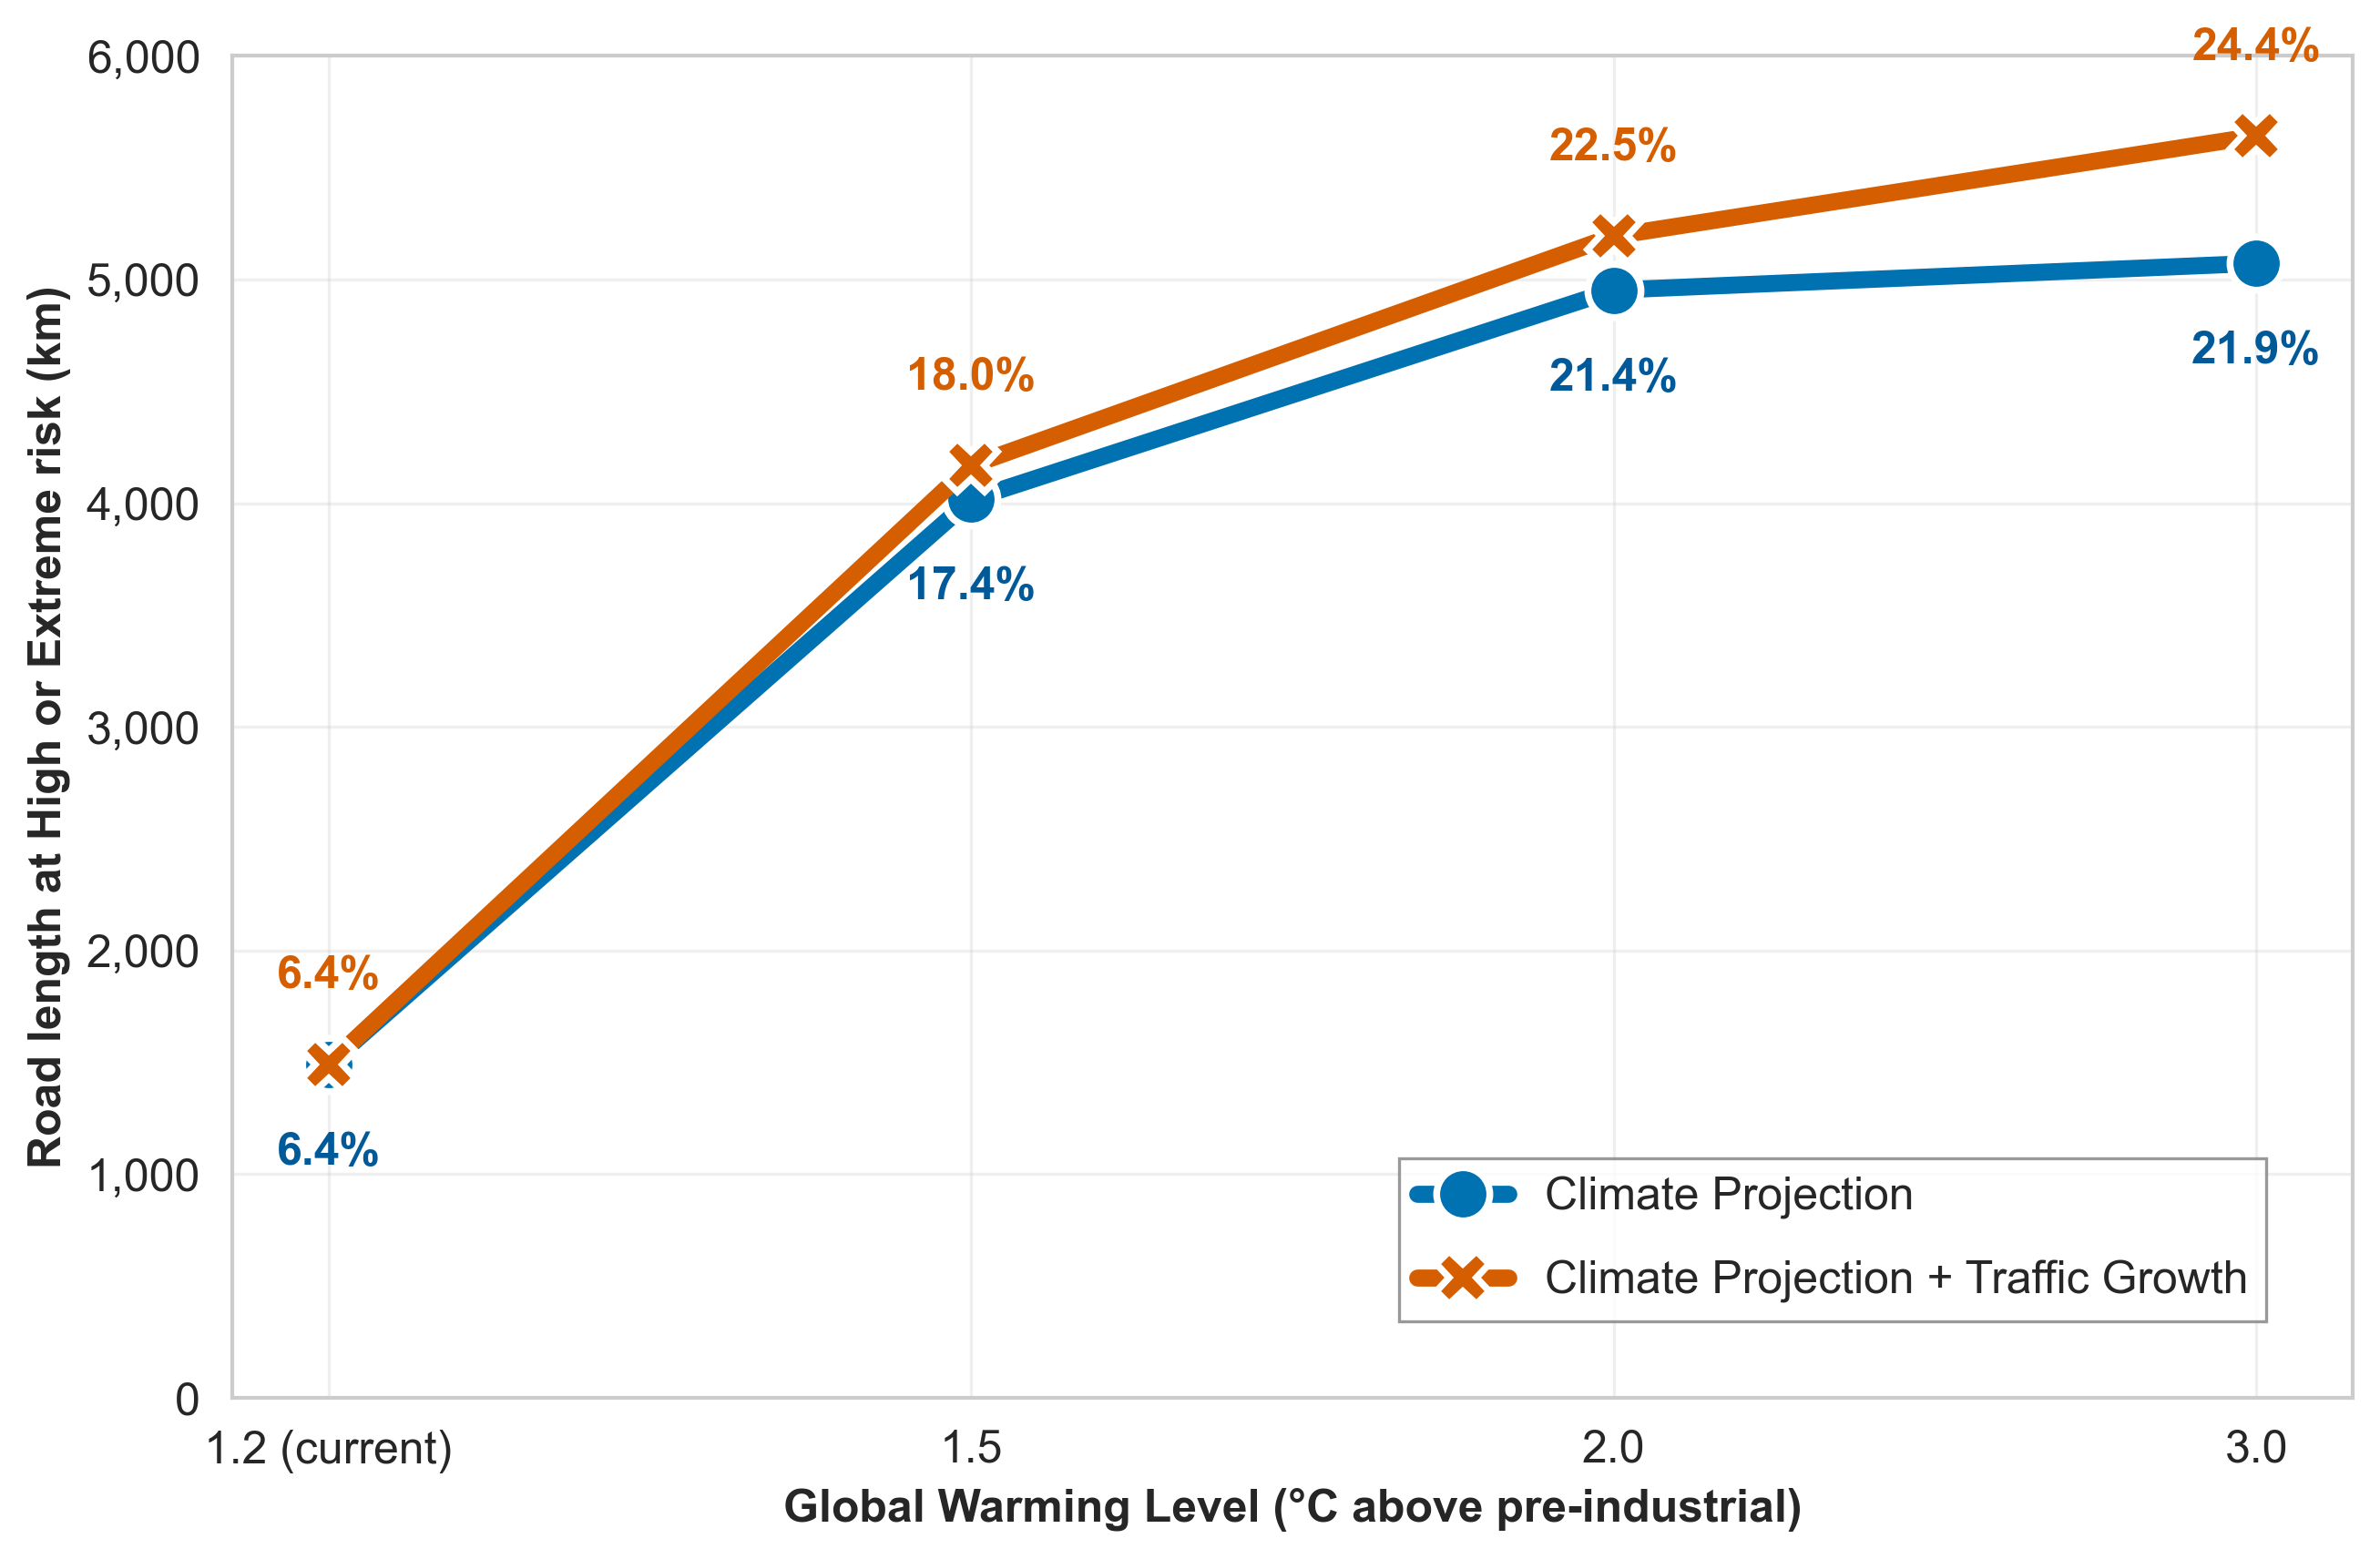


[2025-11-23 12:57:42.509414] FIGURE SUCCESSFULLY SAVED: ../data/processed/model_app/out_cra_st\fig_risk_escalation_trajectory_sensitivity.png


In [122]:
# fig_risk_escalation_trajectory_sensitivity.png

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ------------------------------------------------------------------
run_id = "model_app"
core_dir = f"../data/processed/{run_id}/out_cra"
sens_dir = f"../data/processed/{run_id}/out_cra_st"

core_path = os.path.join(core_dir, "climate_risk_scores_gwl-all_model_app_vgreg.geojson")
sens_files = {
    'current': "climate_risk_scores_gwl-current_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '1.5':     "climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '2.0':     "climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '3.0':     "climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
}

# ------------------------------------------------------------------
# Load total network length
gdf_core = gpd.read_file(core_path)
total_km = gdf_core['link_length_km'].sum()
print(f"Total assessed arterial network length: {total_km:,.0f} km")

# ------------------------------------------------------------------
# Core (climate-only) results
core_data = []
gwl_map = {
    '1.2 (current)': 'CR_Level_comp_norm-current',
    '1.5':  'CR_Level_comp_norm-1.5',
    '2.0':  'CR_Level_comp_norm-2.0',
    '3.0':  'CR_Level_comp_norm-3.0',
}

for label, col in gwl_map.items():
    if col not in gdf_core.columns:
        print(f"Missing column: {col}")
        continue
    high_km = gdf_core[gdf_core[col].isin(['High', 'Extreme'])]['link_length_km'].sum()
    pct = high_km / total_km * 100
    core_data.append({'GWL': label, 'km': high_km, 'pct': pct, 'Scenario': 'Climate Projection'})

# ------------------------------------------------------------------
# Sensitivity (traffic growth) results
sens_data = []
for label, key in [('1.2 (current)', 'current'), ('1.5', '1.5'), ('2.0', '2.0'), ('3.0', '3.0')]:
    filepath = os.path.join(sens_dir, sens_files[key])
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        continue
    df = pd.read_csv(filepath)
    level_col = f"CR_Level_comp_norm-{key}" if key != "current" else "CR_Level_comp_norm-current"
    high_km = df[df[level_col].isin(['High', 'Extreme'])]['link_length_km'].sum()
    pct = high_km / total_km * 100
    sens_data.append({'GWL': label, 'km': high_km, 'pct': pct, 'Scenario': 'Climate Projection + Traffic Growth'})

# ------------------------------------------------------------------
# Combine and prepare for plotting
plot_df = pd.DataFrame(core_data + sens_data)
plot_df['GWL'] = pd.Categorical(plot_df['GWL'], categories=['1.2 (current)', '1.5', '2.0', '3.0'], ordered=True)

# ------------------------------------------------------------------
# Plot
plt.figure(figsize=(9, 6), dpi=300)
sns.set_style("whitegrid")

palette = {
    "Climate Projection": "#0072B2",
    "Climate Projection + Traffic Growth": "#D55E00"}

ax = sns.lineplot(
    data=plot_df,
    x='GWL', y='km',
    hue='Scenario', style='Scenario',
    markers=True, dashes=False,
    linewidth=4.5, markersize=14,
    palette=palette, marker='o',
    markeredgecolor='white', markeredgewidth=1.8
)

# Format y-axis
import matplotlib.ticker as mticker
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(0, 6000)
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)

# Label x- and y-axis
ax.set_ylabel('Road length at High or Extreme risk (km)', fontsize=12, fontweight='bold')
ax.set_xlabel('Global Warming Level (°C above pre-industrial)', fontsize=12, fontweight='bold')
# ax.set_title("Escalation of High or Extreme Climate Risk\n"
#              "Victorian Road Network — Traffic Growth Sensitivity",
#              fontsize=17, fontweight='bold', pad=28)

# Annotation
offset_km = 300
for _, row in plot_df.iterrows():
    if row['Scenario'] == 'Climate Projection':
        y_pos = row['km'] - offset_km
        va = 'top'
        color = "#005a9a"  # slightly darker blue for contrast
    else:
        y_pos = row['km'] + offset_km
        va = 'bottom'
        color = "#D55E00"

    ax.text(
        x=row['GWL'], y=y_pos,
        s=f"{row['pct']:.1f}%",
        ha='center', va=va,
        fontsize=12, fontweight='bold', color=color,
        # bbox=dict(boxstyle="round,pad=0.35",
        #           facecolor='white', edgecolor='none', alpha=0.92)
    )

# Legend: inside lower-right
ax.legend(
    title="",
    loc='lower right',
    bbox_to_anchor=(0.97, 0.04),
    frameon=True,
    fancybox=False,
    edgecolor='gray',
    fontsize=12,
    labelspacing=0.9
)

plt.tight_layout()
output_png = os.path.join(sens_dir, "fig_risk_escalation_trajectory_sensitivity.png")
plt.savefig(output_png, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

from datetime import datetime
print(f"\n[{datetime.now()}] FIGURE SUCCESSFULLY SAVED: {output_png}")



AUMANN–SHAPLEY CONTRIBUTIONS (%) — FINAL VALUES FOR MANUSCRIPT
GWL        Scenario                          Hazard    Exposure   Vulnerability
--------------------------------------------------------------------------------------------
1.2 (current) Climate Projection                32.9%      28.2%         38.9%
1.2 (current) Climate Projection + Traffic Growth    32.9%      28.2%         38.9%
1.5°C      Climate Projection                34.7%      27.2%         38.1%
1.5°C      Climate Projection + Traffic Growth    34.4%      28.4%         37.2%
2.0°C      Climate Projection                36.2%      26.3%         37.5%
2.0°C      Climate Projection + Traffic Growth    36.0%      28.0%         36.0%
3.0°C      Climate Projection                37.8%      25.5%         36.8%
3.0°C      Climate Projection + Traffic Growth    37.8%      27.4%         34.8%


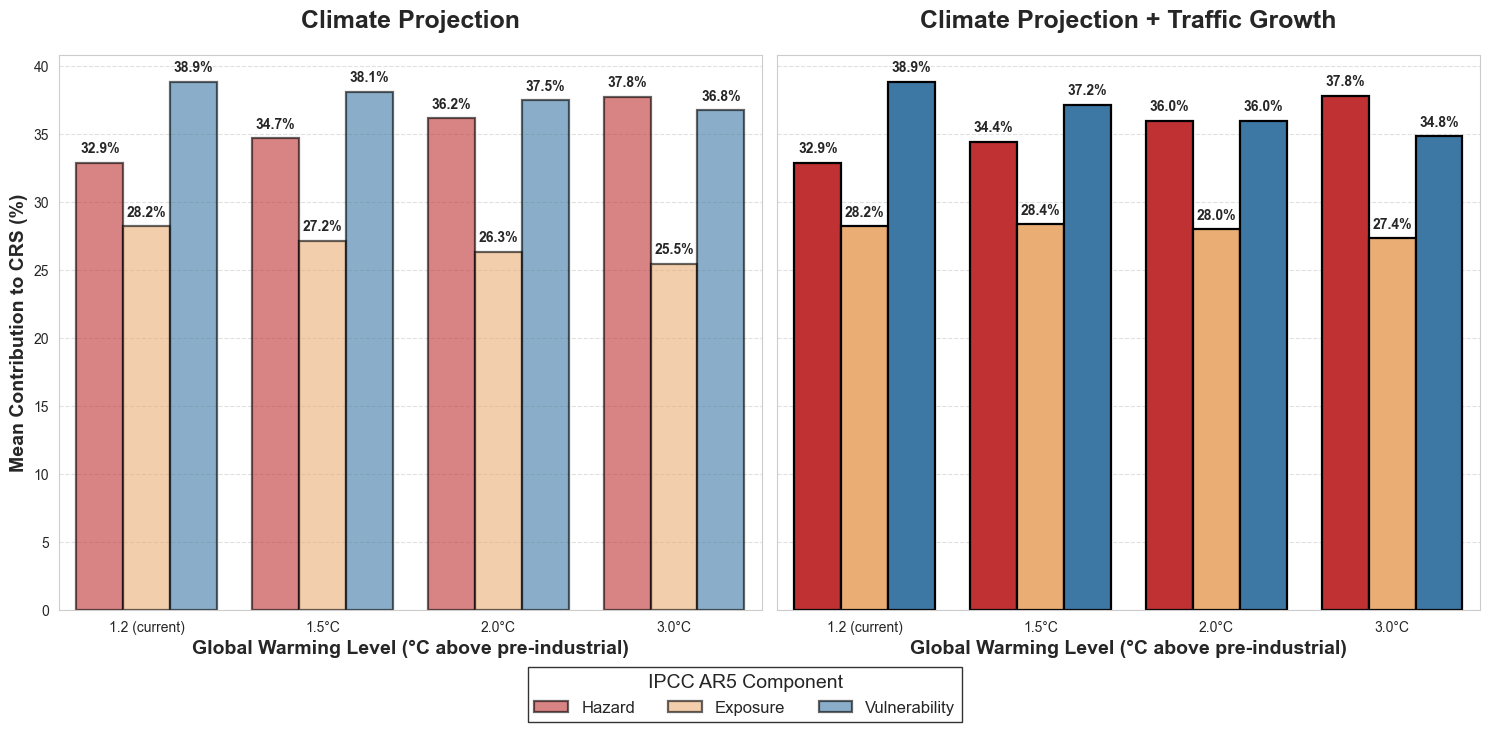


[2025-11-23 13:56:17.035016] FIGURE SUCCESSFULLY SAVED: ../data/processed/model_app/out_cra_st\fig_driver_attribution_sensitivity.png


In [26]:
# fig_driver_attribution_sensitivity.png

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os

run_id = "model_app"

# Aumann–Shapley function
def aumann_shapley_multiplicative(H, E, V, eps=1e-12):
    H = np.maximum(H, eps); E = np.maximum(E, eps); V = np.maximum(V, eps)
    c_H = (1 + H/(H+E) + (H*E)/(H*E + V)) / 3
    c_E = (1 + E/(E+V) + (E*V)/(E*V + H)) / 3
    c_V = (1 + V/(V+H) + (V*H)/(V*H + E)) / 3
    total = c_H + c_E + c_V
    return (c_H/total)*100, (c_E/total)*100, (c_V/total)*100

# 1. CORE (Climate-only)
core_path = f"../data/processed/{run_id}/out_cra/climate_risk_scores_gwl-all_model_app_vgreg.geojson"
df_core = gpd.read_file(core_path)

core_results = []
for gwl in ['current', '1.5', '2.0', '3.0']:
    suffix = '-current' if gwl == 'current' else f"-{gwl}"
    H = df_core[f"Hazard_sum{suffix}"].values
    E = df_core[f"Exposure_sum{suffix}"].values
    V = df_core[f"Vulnerability_sum{suffix}"].values
    contrib_H, contrib_E, contrib_V = aumann_shapley_multiplicative(H, E, V)
    label = "1.2 (current)" if gwl == "current" else f"{gwl}°C"
    core_results.append({'GWL': label, 'Scenario': 'Climate Projection',
                         'Hazard': np.mean(contrib_H), 'Exposure': np.mean(contrib_E), 'Vulnerability': np.mean(contrib_V)})

# 2. SENSITIVITY
sens_dir = f"../data/processed/{run_id}/out_cra_st"
sens_files = {
    'current': "climate_risk_scores_gwl-current_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '1.5': "climate_risk_scores_gwl-1.5_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '2.0': "climate_risk_scores_gwl-2.0_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
    '3.0': "climate_risk_scores_gwl-3.0_traffic_sensitivity_model_app_with_contributions_vgreg.csv",
}

sens_results = []
for gwl, fname in sens_files.items():
    df = pd.read_csv(f"{sens_dir}/{fname}")
    label = "1.2 (current)" if gwl == "current" else f"{gwl}°C"
    sens_results.append({'GWL': label, 'Scenario': 'Climate Projection + Traffic Growth',
                         'Hazard': df['Hazard_contrib_pct_AS'].mean(),
                         'Exposure': df['Exposure_contrib_pct_AS'].mean(),
                         'Vulnerability': df['Vulnerability_contrib_pct_AS'].mean()})

# Combine and print numbers
all_df = pd.concat([pd.DataFrame(core_results), pd.DataFrame(sens_results)], ignore_index=True)

print("\n" + "="*92)
print("AUMANN–SHAPLEY CONTRIBUTIONS (%) — FINAL VALUES FOR MANUSCRIPT")
print("="*92)
print(f"{'GWL':<10} {'Scenario':<30} {'Hazard':>9} {'Exposure':>11} {'Vulnerability':>15}")
print("-"*92)
for _, row in all_df.round(1).sort_values(['GWL', 'Scenario']).iterrows():
    print(f"{row['GWL']:<10} {row['Scenario']:<30} {row['Hazard']:>7.1f}% {row['Exposure']:>9.1f}% {row['Vulnerability']:>12.1f}%")
print("="*92)

# Plotting — using standard subplots for full legend control
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5), sharey=True)
sns.set_style("whitegrid")

palette = {'Hazard': '#d7191c', 'Exposure': '#fdae61', 'Vulnerability': '#2c7bb6'}

scenarios = ['Climate Projection', 'Climate Projection + Traffic Growth']
for idx, scenario in enumerate(scenarios):
    data = all_df[all_df['Scenario'] == scenario]
    plot_data = data.melt(id_vars='GWL', value_vars=['Hazard', 'Exposure', 'Vulnerability'],
                          var_name='Driver', value_name='Contribution (%)')
    plot_data['GWL'] = pd.Categorical(plot_data['GWL'], categories=['1.2 (current)', '1.5°C', '2.0°C', '3.0°C'])

    # sns.barplot(data=plot_data, x='GWL', y='Contribution (%)', hue='Driver',
    #             palette=palette, ax=axes[idx], edgecolor='black', linewidth=1.6)

    if scenario == 'Climate Projection':
        sns.barplot(data=plot_data, x='GWL', y='Contribution (%)', hue='Driver',
                    palette=palette, ax=axes[idx], edgecolor='black', linewidth=1.6, alpha=0.6)
    else:
        sns.barplot(data=plot_data, x='GWL', y='Contribution (%)', hue='Driver',
                    palette=palette, ax=axes[idx], edgecolor='black', linewidth=1.6)

    axes[idx].set_title(scenario, fontsize=18, fontweight='bold', pad=20)
    axes[idx].set_xlabel('Global Warming Level (°C above pre-industrial)', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Mean Contribution to CRS (%)' if idx == 0 else '', fontsize=14, fontweight='bold')
    axes[idx].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Value labels
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.1f%%', padding=5, fontsize=10, fontweight='bold')

# # Main title
# fig.suptitle("Risk Driver Attribution: Climate Projection vs Climate Projection + Traffic Growth Sensitivity\n"
#              "Exact Aumann–Shapley Decomposition of CRS = H × E × V",
#              fontsize=20, fontweight='bold', y=0.98)

# Single legend at bottom centre
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='IPCC AR5 Component', loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.02), fontsize=12, title_fontsize=14,
           frameon=True, fancybox=False, edgecolor='black')

# Remove individual legends
axes[0].legend_.remove()
axes[1].legend_.remove()

plt.tight_layout()
plt.subplots_adjust(bottom=0.14, top=0.88)
output_png = os.path.join(sens_dir, "fig_driver_attribution_sensitivity.png")
plt.savefig(output_png, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

from datetime import datetime
print(f"\n[{datetime.now()}] FIGURE SUCCESSFULLY SAVED: {output_png}")


Loading data...
Pre-computing normalised feature values at +3.0°C GWL...

Running true SHAP weight perturbation tests (±20%) at +3.0°C GWL...

Baseline                                 → computing... DONE
+20% Thermal Diff weight                 → computing... DONE
−20% Thermal Diff weight                 → computing... DONE
+20% tx40 weight                         → computing... DONE
−20% tx40 weight                         → computing... DONE
+20% spi3 weight                         → computing... DONE
−20% spi3 weight                         → computing... DONE
+20% tn02 weight                         → computing... DONE
−20% tn02 weight                         → computing... DONE
+20% rx5d weight                         → computing... DONE
−20% rx5d weight                         → computing... DONE
+20% ALLVEHS weight                      → computing... DONE
−20% ALLVEHS weight                      → computing... DONE

TRUE SHAP WEIGHT PERTURBATION TEST — ±20% ON IMPORTANCE WEIGHTS

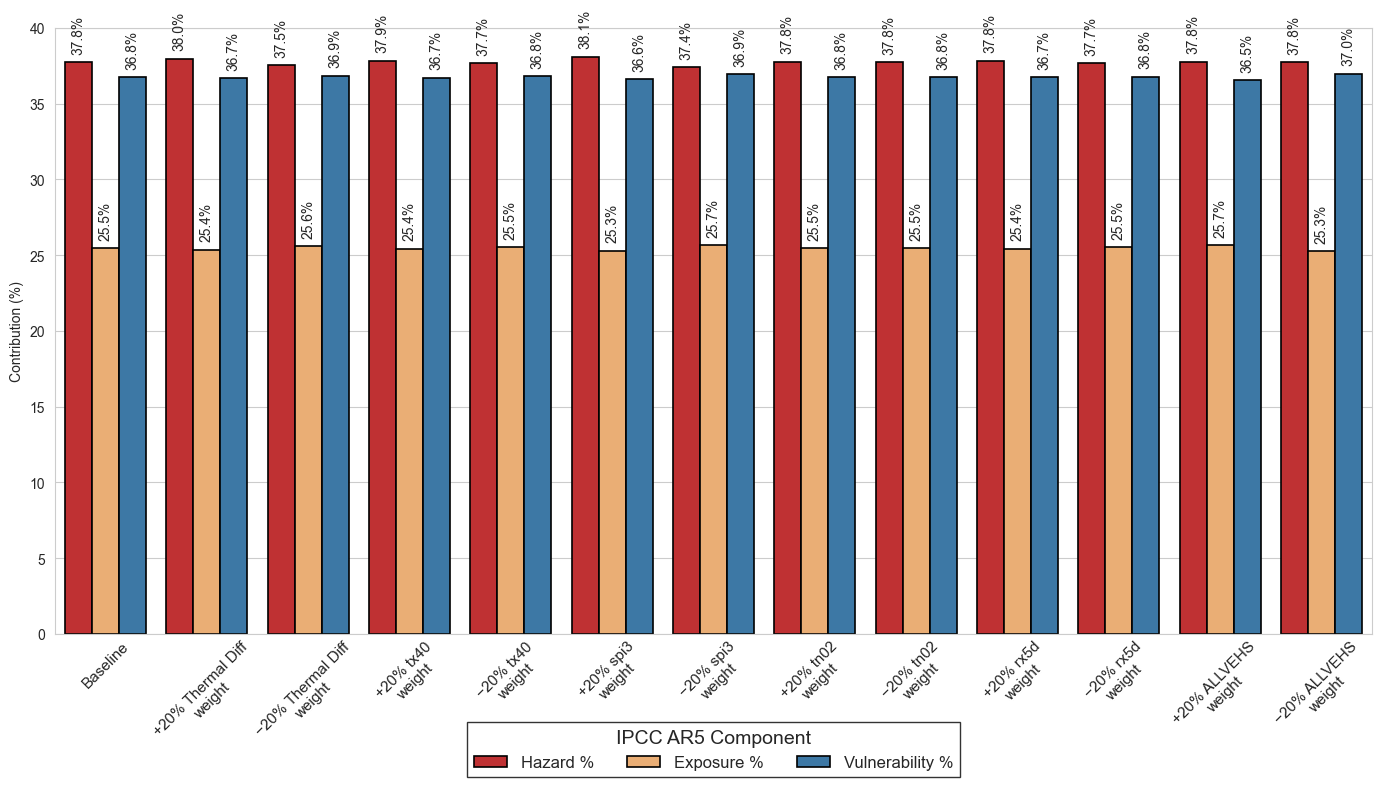

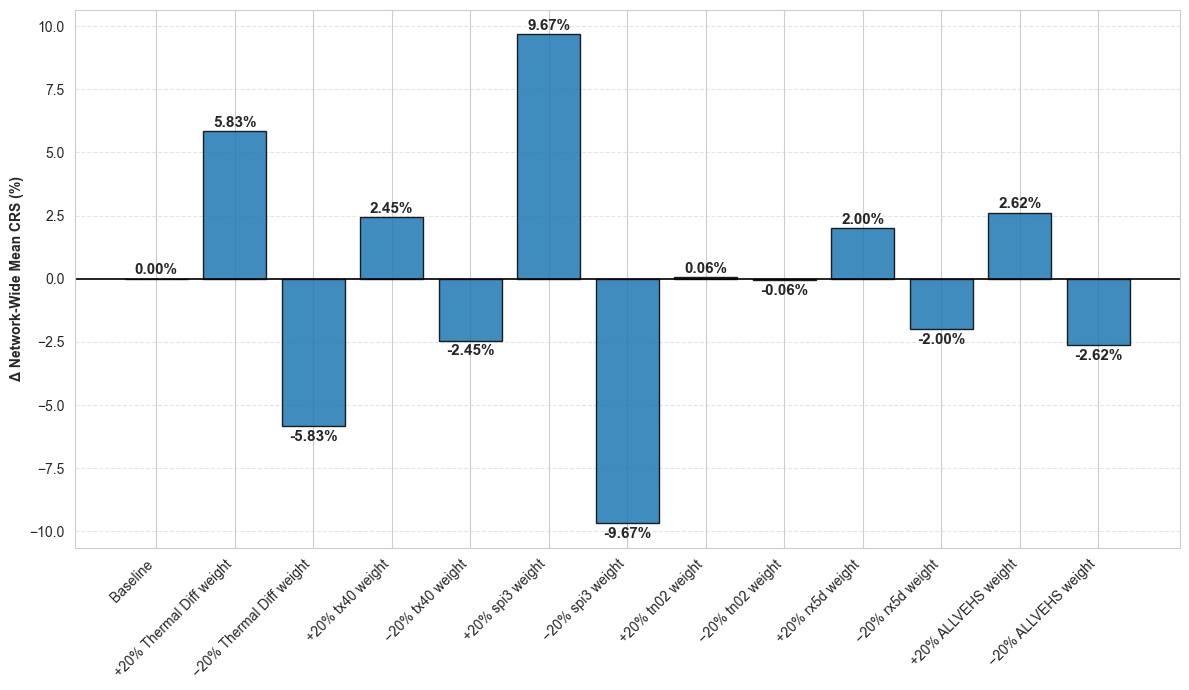

[2025-11-24 00:34:08.643361] Analysis complete. Results saved. Figures generated.


In [51]:
# =============================================================================
# TRUE SHAP WEIGHT PERTURBATION TEST (±20%) — UNILATERAL, ONE-BY-ONE
# Robustness of Aumann–Shapley driver attribution to model uncertainty
# =============================================================================

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
from copy import deepcopy

# -------------------------------
# 1. Configuration & Data Loading
# -------------------------------
gwl = "3.0"
run_id = "model_app"
outputs_id = "out_cra"
output_dir = f"../data/processed/{run_id}/{outputs_id}"

run_id_dev = "model_dev"
cra_path = os.path.join(output_dir, f"../../{run_id_dev}/gdf_road_clim_cln_final_cra_calc.geojson")  #from `model_dev`
shap_path = os.path.join(output_dir, f"../../{run_id_dev}/shap_weights_{run_id_dev}.json")  #from `model_dev`
norm_path = os.path.join(output_dir, f"../../{run_id_dev}/normalization_params_{run_id_dev}.json")  #from `model_dev`
# cra_path  = base_dir / "model_dev" / "gdf_road_clim_cln_final_cra_calc.geojson"
# shap_path = base_dir / "model_dev" / "shap_weights_model_dev.json"
# norm_path = base_dir / "model_dev" / "normalization_params_model_dev.json"


print("Loading data...")
gdf = gpd.read_file(cra_path)
with open(shap_path) as f:
    base_shap_weights = json.load(f)["Mean_Abs_SHAP"]
with open(norm_path) as f:
    norm_params = json.load(f)

df = gdf.copy()

# -------------------------------
# 2. Pre-compute normalised feature values at +3.0°C GWL (fixed inputs)
# -------------------------------
print("Pre-computing normalised feature values at +3.0°C GWL...")

feature_to_column = {
    "Thermal_Diff-current": "Thermal_Diff-3.0",
    "tx40_gwl-current":     "tx40_gwl-3.0",
    "spi3_gwl-current":     "spi3_gwl-3.0",
    "tn02_gwl-current":     "tn02_gwl-3.0",
    "rx5d_gwl-current":     "rx5d_gwl-3.0",
    "ALLVEHS_AA":           "ALLVEHS_AA",
    "HATI_Categ_Code":      "HATI_Categ_Code",
    "TRUCKS_AAD":           "TRUCKS_AAD",
    "SEAL_WIDTH":           "SEAL_WIDTH",
    "Surface_Ty_Code":      "Surface_Ty_Code",
    "RMA_CLSFCN_Code":      "RMA_CLSFCN_Code",
    "Texture__L_Code":      "Texture__L_Code"
}

norm_values = {}
for key, col in feature_to_column.items():
    if col not in df.columns:
        print(f"   Warning: Column {col} missing — skipping {key}")
        continue
    mn = norm_params[key]["min"]
    mx = norm_params[key]["max"]
    norm_values[key] = (df[col] - mn) / (mx - mn + 1e-12)

# -------------------------------
# 3. Exact Aumann–Shapley attribution
# -------------------------------
def aumann_shapley(H, E, V, eps=1e-12):
    H, E, V = np.maximum(H, eps), np.maximum(E, eps), np.maximum(V, eps)
    cH = (1 + H/(H+E) + (H*E)/(H*E + V)) / 3
    cE = (1 + E/(E+V) + (E*V)/(E*V + H)) / 3
    cV = (1 + V/(V+H) + (V*H)/(V*H + E)) / 3
    total = cH + cE + cV
    return (cH/total)*100, (cE/total)*100, (cV/total)*100

# -------------------------------
# 4. Core function: perturb ONE SHAP weight at a time
# -------------------------------
def compute_with_shap_perturbation(perturb_key=None, factor=1.0):
    shap = deepcopy(base_shap_weights)
    if perturb_key is not None:
        if perturb_key not in shap:
            print(f"   → SHAP key {perturb_key} not found!")
            return None
        shap[perturb_key] *= factor

    # Recompute component sums using perturbed weights
    H_sum = sum(norm_values[key] * shap.get(key, 0) for key in
                ["Thermal_Diff-current","tx40_gwl-current","spi3_gwl-current",
                 "tn02_gwl-current","rx5d_gwl-current"])
    E_sum = sum(norm_values[key] * shap.get(key, 0) for key in
                ["ALLVEHS_AA","HATI_Categ_Code","TRUCKS_AAD"])
    V_sum = sum(norm_values[key] * shap.get(key, 0) for key in
                ["SEAL_WIDTH","Surface_Ty_Code","RMA_CLSFCN_Code","Texture__L_Code"])

    CRS = H_sum * E_sum * V_sum
    cH, cE, cV = aumann_shapley(H_sum, E_sum, V_sum)

    return {
        "Mean_CRS": CRS.mean(),
        "Hazard %": cH.mean(),
        "Exposure %": cE.mean(),
        "Vulnerability %": cV.mean()
    }

# -------------------------------
# 5. Define unilateral ±20% perturbations
# -------------------------------
perturbations = {
    "Baseline":                              (None, 1.0),
    "+20% Thermal Diff weight":             ("Thermal_Diff-current", 1.20),
    "−20% Thermal Diff weight":             ("Thermal_Diff-current", 0.80),
    "+20% tx40 weight":                      ("tx40_gwl-current", 1.20),
    "−20% tx40 weight":                      ("tx40_gwl-current", 0.80),
    "+20% spi3 weight":                      ("spi3_gwl-current", 1.20),
    "−20% spi3 weight":                      ("spi3_gwl-current", 0.80),
    "+20% tn02 weight":                      ("tn02_gwl-current", 1.20),
    "−20% tn02 weight":                      ("tn02_gwl-current", 0.80),
    "+20% rx5d weight":                      ("rx5d_gwl-current", 1.20),
    "−20% rx5d weight":                      ("rx5d_gwl-current", 0.80),
    "+20% ALLVEHS weight":                   ("ALLVEHS_AA", 1.20),
    "−20% ALLVEHS weight":                   ("ALLVEHS_AA", 0.80),
}

# -------------------------------
# 6. Run all tests
# -------------------------------
print("\nRunning true SHAP weight perturbation tests (±20%) at +3.0°C GWL...\n")
results = []
baseline_crs = None

for label, (key, factor) in perturbations.items():
    print(f"{label:40} → computing...", end=" ")
    res = compute_with_shap_perturbation(perturb_key=key, factor=factor)
    if res is None:
        print("FAILED")
        continue
    print("DONE")

    if baseline_crs is None:
        baseline_crs = res["Mean_CRS"]
    res["ΔCRS (%)"] = (res["Mean_CRS"] / baseline_crs - 1) * 100
    res["Perturbation"] = label
    results.append(res)

df_res = pd.DataFrame(results)[["Perturbation","Hazard %","Exposure %","Vulnerability %","ΔCRS (%)"]].round(2)

# -------------------------------
# 7. Print table
# -------------------------------
print("\n" + "="*130)
print("TRUE SHAP WEIGHT PERTURBATION TEST — ±20% ON IMPORTANCE WEIGHTS (+3.0°C GWL)")
print("="*130)
print(f"{'Perturbation':<44} {'Hazard (%)':>11} {'Exposure (%)':>14} {'Vulnerability (%)':>18} {'ΔCRS (%)':>12}")
print("-"*130)
for _, row in df_res.iterrows():
    print(f"{row['Perturbation']:<44} {row['Hazard %']:>10.2f} {row['Exposure %']:>14.2f} {row['Vulnerability %']:>17.2f} {row['ΔCRS (%)']:>12.2f}")
print("="*130 + "\n")

# -------------------------------
# 8. Save results and generate figures
# -------------------------------
csv_output = os.path.join(output_dir, f"../../model_app/out_cra_st/shap_weight_perturbation_results.csv")
df_res.to_csv(csv_output, index=False)


# ------------------------------------------------------------------
# Figure: Driver attribution robustness
# ------------------------------------------------------------------
from matplotlib.ticker import FixedLocator
plot_df = df_res.melt(id_vars="Perturbation",
                      value_vars=["Hazard %","Exposure %","Vulnerability %"],
                      var_name="Driver", value_name="Contribution (%)")

plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

ax = sns.barplot(data=plot_df, x="Perturbation", y="Contribution (%)", hue="Driver",
                 palette={"Hazard %":"#d7191c",
                          "Exposure %":"#fdae61",
                          "Vulnerability %":"#2c7bb6"},
                 edgecolor="black", linewidth=1.2)

new_labels = [
    "Baseline",
    "+20% Thermal Diff\nweight",  "−20% Thermal Diff\nweight",
    "+20% tx40\nweight",          "−20% tx40\nweight",
    "+20% spi3\nweight",          "−20% spi3\nweight",
    "+20% tn02\nweight",          "−20% tn02\nweight",
    "+20% rx5d\nweight",          "−20% rx5d\nweight",
    "+20% ALLVEHS\nweight",      "−20% ALLVEHS\nweight"
]
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, ha='center', va='top',
                   fontsize=11, rotation=45)
ax.tick_params(axis='x', which='major', pad=0)
ax.set_xlabel('')
# ax.set_title("Robustness of Risk Driver Attribution to ±20% SHAP Weight Perturbation\n(GWL 3.0°C)",
#              fontsize=16, fontweight="bold", pad=20)
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%", padding=6, fontsize=10, rotation=90)
ax.legend(title='IPCC AR5 Component', loc='lower center', ncol=3,
           bbox_to_anchor=(0.5, -0.25), fontsize=12, title_fontsize=14,
           frameon=True, fancybox=False, edgecolor='black')

# sns.despine(trim=True)
plt.tight_layout()
fig1_output = os.path.join(output_dir, f"../../model_app/out_cra_st/fig_shap_weight_perturbation_attribution.png")
plt.savefig(fig1_output, dpi=300, bbox_inches="tight")
plt.show()


# ------------------------------------------------------------------
# Figure: Total CRS sensitivity
# ------------------------------------------------------------------
plt.figure(figsize=(12, 7))
bars = plt.bar(df_res["Perturbation"], df_res["ΔCRS (%)"],
               color="#1f78b4", edgecolor="black", alpha=0.85)
plt.xticks(rotation=45, ha="right")
plt.axhline(0, color="black", linewidth=1.2)
plt.ylabel("Δ Network-Wide Mean CRS (%)", fontweight="bold")
# plt.title("Total CRS Sensitivity to ±20% SHAP Weight Perturbation (GWL 3.0°C)",
#           fontsize=16, fontweight="bold", pad=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + (0.05 if h >= 0 else -0.15),
             f"{h:.2f}%", ha="center", va="bottom" if h >= 0 else "top",
             fontweight="bold", fontsize=11)
# sns.despine(trim=True)
plt.tight_layout()
fig2_output = os.path.join(output_dir, f"../../model_app/out_cra_st/fig_shap_weight_perturbation_crs.png")
plt.savefig(fig2_output, dpi=300, bbox_inches="tight")
plt.show()
print(f"[{datetime.now()}] Analysis complete. Results saved. Figures generated.")
